In [3]:
# 0221 Update: weighted center, tree nodes
# 0308 Update: prob calculation

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import matplotlib.patches as patches

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            return time_stamp, total_flux
    return None, None

def remove_enclosed_rectangles(large_rectangles):
    # Create a new list for rectangles that are not fully enclosed
    filtered_rectangles = []
    
    for i, rect1 in enumerate(large_rectangles):
        rect1_area = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])  # Calculate area of rect1
        is_enclosed = False
        
        for j, rect2 in enumerate(large_rectangles):
            if i != j:  # Don't compare a rectangle with itself
                # Calculate overlap area
                overlap_left = max(rect1[0], rect2[0])
                overlap_right = min(rect1[1], rect2[1])
                overlap_bottom = max(rect1[2], rect2[2])
                overlap_top = min(rect1[3], rect2[3])
                
                if overlap_right > overlap_left and overlap_top > overlap_bottom:
                    overlap_area = (overlap_right - overlap_left) * (overlap_top - overlap_bottom)
                    if overlap_area / rect1_area >= 0.7:
                        is_enclosed = True
                        break

        if not is_enclosed:
            filtered_rectangles.append(rect1)
    return filtered_rectangles


def update_large_rectangles(box):
    global large_rectangles
    box_left, box_right, box_bottom, box_top = box

    # Adjust for wrap around
    if box_right < box_left:
        box_right += flux_difference.shape[1]

    new_rect_area = (box_right - box_left) * (box_top - box_bottom)

    for large_rect in large_rectangles:
        rect_left, rect_right, rect_bottom, rect_top = large_rect

        # Adjust for wrap around
        if rect_right < rect_left:
            rect_right += flux_difference.shape[1]

        # Calculate overlap area
        overlap_left = max(box_left, rect_left)
        overlap_right = min(box_right, rect_right)
        overlap_bottom = max(box_bottom, rect_bottom)
        overlap_top = min(box_top, rect_top)

        # Ensure there is an overlap
        if overlap_right > overlap_left and overlap_top > overlap_bottom:
            overlap_area = (overlap_right - overlap_left) * (overlap_top - overlap_bottom)
        else:
            overlap_area = 0

        # Check if the new rectangle is mostly enclosed by an existing one
        if overlap_area / new_rect_area >= 0.8:
            return  # Skip adding this rectangle

        # Update the large rectangle's boundaries if there's overlap
        if not (box_right < rect_left or box_left > rect_right or box_top < rect_bottom or box_bottom > rect_top):
            large_rect[0] = min(rect_left, box_left)
            large_rect[1] = max(rect_right, box_right)
            large_rect[2] = min(rect_bottom, box_bottom)
            large_rect[3] = max(rect_top, box_top)
            return

    # If the rectangle is not mostly enclosed by any existing rectangle, add it
    large_rectangles.append([box_left, box_right % flux_difference.shape[1], box_bottom, box_top])

    
    large_rectangles.append([box_left, box_right % flux_difference.shape[1], box_bottom, box_top])

def draw_rectangles(ax, rectangles, flux_difference_shape):
    for rect in rectangles:
        left, right, bottom, top = rect
        
        if right < left:
            rect_left = patches.Rectangle((left, bottom), flux_difference_shape - left, top - bottom + 1, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect_left)
            rect_right = patches.Rectangle((0, bottom), right, top - bottom + 1, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect_right)
        else:
            rect = patches.Rectangle((left, bottom), right - left, top - bottom + 1, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)

def calculate_weighted_center(rectangle, flux_difference):
    left, right, bottom, top = rectangle
    # Handle wrap-around by adjusting the indices
    if right < left:
        if (right - 0) > (240 - left):
            weighted_center_x = (0+right) / 2
            weighted_center_y = (top + bottom) / 2
        else:
            weighted_center_x = (240+left) / 2
            weighted_center_y = (top + bottom) / 2
    else:    
        x_indices, y_indices = np.meshgrid(np.arange(left, right) % flux_difference.shape[1], np.arange(bottom, top+1))
        area_values = flux_difference[bottom:top+1, left:right] if right <= flux_difference.shape[1] else np.hstack((flux_difference[bottom:top+1, left:], flux_difference[bottom:top+1, :right % flux_difference.shape[1]]))
        total_weight = np.sum(area_values)
        weighted_center_x = np.sum(x_indices.flatten() * area_values.flatten()) / total_weight
        weighted_center_y = np.sum(y_indices.flatten() * area_values.flatten()) / total_weight
        # Adjust the weighted center x-coordinate for wrap-around
        weighted_center_x = weighted_center_x % flux_difference.shape[1]
    return weighted_center_x, weighted_center_y


input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/"
os.makedirs(output_directory, exist_ok=True)

pattern = re.compile(r'F[1]_[\d]{4}_[\d]{4}_(12|01|02)_[\d]{2}_(00|06|12|18).npy')

f1_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

results = Parallel(n_jobs=-2)(delayed(load_single_flux_data)(input_directory, f, pattern) for f in tqdm(f1_files))

flux_data = {time_stamp: flux for time_stamp, flux in results if time_stamp is not None}

flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")

rectangle_data = []

for time_stamp, total_flux in flux_data.items():
    large_rectangles = []  # This should be before updating rectangles for the current timestamp
    flux_difference = total_flux - flux_capacity_2d
    
    fig, ax = plt.subplots(figsize=(20, 12))
    heatmap = ax.imshow(flux_difference, cmap='coolwarm', aspect='auto', vmin=-1000, vmax=500, origin='lower')
    plt.colorbar(heatmap, label='Flux Difference')
    ax.set_title(f'2D Heatmap of Flux Difference: {time_stamp}')
    ax.set_xlabel('Dimension 1 - lon steps')
    ax.set_ylabel('Dimension 2 - lat steps')
    
    num_squares = 0  # Initialize counter for squares

    square_size = 8
    dim2_range = range(76, 97)
    
    for i in dim2_range:
        for j in range(flux_difference.shape[1]):
            left = j
            right = (j + square_size) % flux_difference.shape[1]
            bottom = i
            top = i + square_size - 1

            if right > left:
                box_values = flux_difference[bottom:top+1, left:right]
            else:
                box_values_left = flux_difference[bottom:top+1, left:]
                box_values_right = flux_difference[bottom:top+1, :right]
                box_values = np.hstack((box_values_left, box_values_right))

            if np.sum(box_values > 100) / box_values.size >= 0.8:
                update_large_rectangles((left, right % flux_difference.shape[1], bottom, top))
                num_squares += 1  # Update counter for squares

    # Filter large rectangles for enclosures here after they are all added
    large_rectangles = remove_enclosed_rectangles(large_rectangles)

    draw_rectangles(ax, large_rectangles, flux_difference.shape[1])
    
    plt.savefig(os.path.join(output_directory, f"flux_difference_{time_stamp}.png"))
    plt.close()

    print(f"Total number of squares with all positive flux difference for {time_stamp}: {num_squares}")
    print(f"Total number of large rectangles for {time_stamp}: {len(large_rectangles)}")  # Use len() for accurate count

    for rect in large_rectangles:
        wc_x, wc_y = calculate_weighted_center(rect, flux_difference)
        rectangle_data.append([time_stamp, rect[0] % flux_difference.shape[1], rect[1] % flux_difference.shape[1], rect[2], rect[3], wc_x, wc_y])

# Convert rectangle_data to DataFrame and save to CSV as before, including the new weighted center columns
df = pd.DataFrame(rectangle_data, columns=['TimeStamp', 'Left', 'Right', 'Bottom', 'Top', 'WeightedCenterX', 'WeightedCenterY'])
df['MinLon'] = df['Left'] * 1.5
df['MaxLon'] = df['Right'] * 1.5
df['MinLat'] = (df['Bottom'] * 1.5) - 90
df['MaxLat'] = (df['Top'] * 1.5) - 90

df['MaxLon'] = df['MaxLon'].apply(lambda x: x - 360 if x > 360 else x)

csv_file = os.path.join(output_directory, "flux_difference_rectangles.csv")
df.to_csv(csv_file, index=False)
print(f"Data written to {csv_file}")


100%|██████████| 13606/13606 [00:26<00:00, 521.96it/s]


Total number of squares with all positive flux difference for 2007_01_29_00: 334
Total number of large rectangles for 2007_01_29_00: 4
Total number of squares with all positive flux difference for 2013_02_01_12: 282
Total number of large rectangles for 2013_02_01_12: 6
Total number of squares with all positive flux difference for 1999_12_08_00: 195
Total number of large rectangles for 1999_12_08_00: 4
Total number of squares with all positive flux difference for 2006_12_18_06: 454
Total number of large rectangles for 2006_12_18_06: 2
Total number of squares with all positive flux difference for 2013_02_09_12: 172
Total number of large rectangles for 2013_02_09_12: 3
Total number of squares with all positive flux difference for 1984_01_21_12: 132
Total number of large rectangles for 1984_01_21_12: 3
Total number of squares with all positive flux difference for 1999_12_25_12: 546
Total number of large rectangles for 1999_12_25_12: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1996_01_18_18: 142
Total number of large rectangles for 1996_01_18_18: 4
Total number of squares with all positive flux difference for 1994_12_12_00: 204
Total number of large rectangles for 1994_12_12_00: 5
Total number of squares with all positive flux difference for 1980_01_10_18: 61
Total number of large rectangles for 1980_01_10_18: 3
Total number of squares with all positive flux difference for 2001_01_30_06: 19
Total number of large rectangles for 2001_01_30_06: 1
Total number of squares with all positive flux difference for 1996_01_31_00: 183
Total number of large rectangles for 1996_01_31_00: 2
Total number of squares with all positive flux difference for 1979_02_04_00: 157
Total number of large rectangles for 1979_02_04_00: 3
Total number of squares with all positive flux difference for 1990_12_10_18: 125
Total number of large rectangles for 1990_12_10_18: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1985_01_23_18: 197
Total number of large rectangles for 1985_01_23_18: 4
Total number of squares with all positive flux difference for 2001_01_19_00: 53
Total number of large rectangles for 2001_01_19_00: 3
Total number of squares with all positive flux difference for 2007_12_25_12: 117
Total number of large rectangles for 2007_12_25_12: 2
Total number of squares with all positive flux difference for 2002_01_28_00: 254
Total number of large rectangles for 2002_01_28_00: 4
Total number of squares with all positive flux difference for 1985_01_29_18: 186
Total number of large rectangles for 1985_01_29_18: 6
Total number of squares with all positive flux difference for 2015_02_08_12: 355
Total number of large rectangles for 2015_02_08_12: 4
Total number of squares with all positive flux difference for 2003_02_01_00: 84
Total number of large rectangles for 2003_02_01_00: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1996_12_24_00: 20
Total number of large rectangles for 1996_12_24_00: 1
Total number of squares with all positive flux difference for 1992_12_09_12: 196
Total number of large rectangles for 1992_12_09_12: 3
Total number of squares with all positive flux difference for 2007_02_01_18: 395
Total number of large rectangles for 2007_02_01_18: 7
Total number of squares with all positive flux difference for 2011_02_09_00: 272
Total number of large rectangles for 2011_02_09_00: 5
Total number of squares with all positive flux difference for 1989_12_16_06: 271
Total number of large rectangles for 1989_12_16_06: 4
Total number of squares with all positive flux difference for 1980_12_27_12: 566
Total number of large rectangles for 1980_12_27_12: 4
Total number of squares with all positive flux difference for 1995_01_23_00: 258
Total number of large rectangles for 1995_01_23_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2006_01_18_12: 310
Total number of large rectangles for 2006_01_18_12: 3
Total number of squares with all positive flux difference for 1997_02_15_12: 247
Total number of large rectangles for 1997_02_15_12: 4
Total number of squares with all positive flux difference for 1983_12_08_00: 19
Total number of large rectangles for 1983_12_08_00: 2
Total number of squares with all positive flux difference for 2011_12_18_00: 50
Total number of large rectangles for 2011_12_18_00: 2
Total number of squares with all positive flux difference for 1991_02_23_00: 297
Total number of large rectangles for 1991_02_23_00: 5
Total number of squares with all positive flux difference for 2012_12_26_12: 71
Total number of large rectangles for 2012_12_26_12: 2
Total number of squares with all positive flux difference for 1991_01_22_18: 190
Total number of large rectangles for 1991_01_22_18: 4
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1993_02_10_12: 87
Total number of large rectangles for 1993_02_10_12: 4
Total number of squares with all positive flux difference for 2008_01_18_06: 387
Total number of large rectangles for 2008_01_18_06: 3
Total number of squares with all positive flux difference for 1981_12_09_00: 94
Total number of large rectangles for 1981_12_09_00: 2
Total number of squares with all positive flux difference for 2015_12_04_06: 411
Total number of large rectangles for 2015_12_04_06: 5
Total number of squares with all positive flux difference for 1982_01_25_06: 108
Total number of large rectangles for 1982_01_25_06: 3
Total number of squares with all positive flux difference for 2011_12_29_12: 408
Total number of large rectangles for 2011_12_29_12: 3
Total number of squares with all positive flux difference for 2010_12_07_06: 81
Total number of large rectangles for 2010_12_07_06: 2
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1982_12_11_00: 83
Total number of large rectangles for 1982_12_11_00: 5
Total number of squares with all positive flux difference for 2011_02_02_00: 148
Total number of large rectangles for 2011_02_02_00: 4
Total number of squares with all positive flux difference for 2004_01_09_06: 89
Total number of large rectangles for 2004_01_09_06: 2
Total number of squares with all positive flux difference for 1999_01_30_12: 131
Total number of large rectangles for 1999_01_30_12: 2
Total number of squares with all positive flux difference for 2003_12_12_18: 162
Total number of large rectangles for 2003_12_12_18: 6
Total number of squares with all positive flux difference for 1988_02_12_12: 128
Total number of large rectangles for 1988_02_12_12: 4
Total number of squares with all positive flux difference for 1981_01_01_06: 369
Total number of large rectangles for 1981_01_01_06: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1983_02_20_00: 192
Total number of large rectangles for 1983_02_20_00: 3
Total number of squares with all positive flux difference for 2012_01_03_06: 440
Total number of large rectangles for 2012_01_03_06: 11
Total number of squares with all positive flux difference for 1986_12_23_18: 214
Total number of large rectangles for 1986_12_23_18: 3
Total number of squares with all positive flux difference for 1988_02_09_06: 120
Total number of large rectangles for 1988_02_09_06: 5
Total number of squares with all positive flux difference for 1992_01_24_06: 283
Total number of large rectangles for 1992_01_24_06: 5
Total number of squares with all positive flux difference for 2015_01_18_12: 341
Total number of large rectangles for 2015_01_18_12: 4
Total number of squares with all positive flux difference for 1979_02_26_00: 28
Total number of large rectangles for 1979_02_26_00: 2
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1984_01_11_18: 243
Total number of large rectangles for 1984_01_11_18: 3
Total number of squares with all positive flux difference for 1998_12_19_00: 140
Total number of large rectangles for 1998_12_19_00: 3
Total number of squares with all positive flux difference for 1982_01_06_18: 103
Total number of large rectangles for 1982_01_06_18: 1
Total number of squares with all positive flux difference for 1993_02_25_00: 221
Total number of large rectangles for 1993_02_25_00: 3
Total number of squares with all positive flux difference for 2002_12_12_06: 231
Total number of large rectangles for 2002_12_12_06: 2
Total number of squares with all positive flux difference for 1989_01_21_12: 280
Total number of large rectangles for 1989_01_21_12: 5
Total number of squares with all positive flux difference for 1987_01_27_00: 395
Total number of large rectangles for 1987_01_27_00: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2004_12_01_12: 123
Total number of large rectangles for 2004_12_01_12: 4
Total number of squares with all positive flux difference for 2002_12_09_06: 129
Total number of large rectangles for 2002_12_09_06: 5
Total number of squares with all positive flux difference for 1999_02_15_00: 435
Total number of large rectangles for 1999_02_15_00: 4
Total number of squares with all positive flux difference for 2011_12_03_12: 252
Total number of large rectangles for 2011_12_03_12: 2
Total number of squares with all positive flux difference for 2012_01_25_06: 146
Total number of large rectangles for 2012_01_25_06: 5
Total number of squares with all positive flux difference for 1997_01_29_18: 598
Total number of large rectangles for 1997_01_29_18: 5
Total number of squares with all positive flux difference for 1995_01_27_12: 356
Total number of large rectangles for 1995_01_27_12: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1999_01_01_12: 216
Total number of large rectangles for 1999_01_01_12: 6
Total number of squares with all positive flux difference for 2004_02_10_18: 330
Total number of large rectangles for 2004_02_10_18: 4
Total number of squares with all positive flux difference for 1984_01_29_06: 334
Total number of large rectangles for 1984_01_29_06: 3
Total number of squares with all positive flux difference for 1983_02_04_00: 204
Total number of large rectangles for 1983_02_04_00: 3
Total number of squares with all positive flux difference for 2014_02_04_18: 123
Total number of large rectangles for 2014_02_04_18: 4
Total number of squares with all positive flux difference for 2015_02_02_12: 277
Total number of large rectangles for 2015_02_02_12: 3
Total number of squares with all positive flux difference for 1981_02_08_06: 193
Total number of large rectangles for 1981_02_08_06: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2004_02_16_18: 306
Total number of large rectangles for 2004_02_16_18: 4
Total number of squares with all positive flux difference for 1990_01_30_18: 619
Total number of large rectangles for 1990_01_30_18: 5
Total number of squares with all positive flux difference for 2013_02_03_06: 295
Total number of large rectangles for 2013_02_03_06: 3
Total number of squares with all positive flux difference for 2016_02_01_12: 305
Total number of large rectangles for 2016_02_01_12: 5
Total number of squares with all positive flux difference for 1989_01_04_00: 356
Total number of large rectangles for 1989_01_04_00: 5
Total number of squares with all positive flux difference for 2015_01_25_00: 435
Total number of large rectangles for 2015_01_25_00: 4
Total number of squares with all positive flux difference for 2000_01_15_00: 278
Total number of large rectangles for 2000_01_15_00: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2016_01_08_18: 82
Total number of large rectangles for 2016_01_08_18: 2
Total number of squares with all positive flux difference for 2000_01_24_00: 410
Total number of large rectangles for 2000_01_24_00: 3
Total number of squares with all positive flux difference for 1985_02_02_00: 174
Total number of large rectangles for 1985_02_02_00: 4
Total number of squares with all positive flux difference for 1999_12_21_18: 462
Total number of large rectangles for 1999_12_21_18: 4
Total number of squares with all positive flux difference for 1997_01_11_00: 232
Total number of large rectangles for 1997_01_11_00: 4
Total number of squares with all positive flux difference for 1991_02_01_12: 483
Total number of large rectangles for 1991_02_01_12: 2
Total number of squares with all positive flux difference for 2015_02_23_00: 279
Total number of large rectangles for 2015_02_23_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2001_12_11_18: 60
Total number of large rectangles for 2001_12_11_18: 4
Total number of squares with all positive flux difference for 1997_01_27_00: 206
Total number of large rectangles for 1997_01_27_00: 2
Total number of squares with all positive flux difference for 2012_12_24_06: 231
Total number of large rectangles for 2012_12_24_06: 6
Total number of squares with all positive flux difference for 1987_12_29_12: 199
Total number of large rectangles for 1987_12_29_12: 4
Total number of squares with all positive flux difference for 1993_02_21_12: 239
Total number of large rectangles for 1993_02_21_12: 1
Total number of squares with all positive flux difference for 1997_01_13_00: 121
Total number of large rectangles for 1997_01_13_00: 4
Total number of squares with all positive flux difference for 1995_12_12_12: 342
Total number of large rectangles for 1995_12_12_12: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1988_02_15_06: 92
Total number of large rectangles for 1988_02_15_06: 3
Total number of squares with all positive flux difference for 1979_12_10_18: 126
Total number of large rectangles for 1979_12_10_18: 3
Total number of squares with all positive flux difference for 1987_01_29_00: 248
Total number of large rectangles for 1987_01_29_00: 3
Total number of squares with all positive flux difference for 1996_02_22_06: 246
Total number of large rectangles for 1996_02_22_06: 8
Total number of squares with all positive flux difference for 1985_02_06_12: 120
Total number of large rectangles for 1985_02_06_12: 3
Total number of squares with all positive flux difference for 2004_02_08_12: 582
Total number of large rectangles for 2004_02_08_12: 2
Total number of squares with all positive flux difference for 2000_01_28_06: 470
Total number of large rectangles for 2000_01_28_06: 8
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1983_02_28_00: 329
Total number of large rectangles for 1983_02_28_00: 3
Total number of squares with all positive flux difference for 1990_02_12_18: 456
Total number of large rectangles for 1990_02_12_18: 4
Total number of squares with all positive flux difference for 1995_02_13_00: 238
Total number of large rectangles for 1995_02_13_00: 5
Total number of squares with all positive flux difference for 2000_12_11_06: 73
Total number of large rectangles for 2000_12_11_06: 4
Total number of squares with all positive flux difference for 1996_02_26_12: 183
Total number of large rectangles for 1996_02_26_12: 1
Total number of squares with all positive flux difference for 1992_02_08_12: 160
Total number of large rectangles for 1992_02_08_12: 4
Total number of squares with all positive flux difference for 1988_12_08_12: 281
Total number of large rectangles for 1988_12_08_12: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2007_02_11_00: 103
Total number of large rectangles for 2007_02_11_00: 1
Total number of squares with all positive flux difference for 1989_12_07_06: 79
Total number of large rectangles for 1989_12_07_06: 4
Total number of squares with all positive flux difference for 1991_12_06_18: 293
Total number of large rectangles for 1991_12_06_18: 5
Total number of squares with all positive flux difference for 2003_02_14_00: 236
Total number of large rectangles for 2003_02_14_00: 2
Total number of squares with all positive flux difference for 1988_12_03_00: 171
Total number of large rectangles for 1988_12_03_00: 4
Total number of squares with all positive flux difference for 2002_01_11_18: 223
Total number of large rectangles for 2002_01_11_18: 2
Total number of squares with all positive flux difference for 2016_12_04_00: 94
Total number of large rectangles for 2016_12_04_00: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2003_12_22_06: 542
Total number of large rectangles for 2003_12_22_06: 5
Total number of squares with all positive flux difference for 2013_02_03_12: 226
Total number of large rectangles for 2013_02_03_12: 4
Total number of squares with all positive flux difference for 2009_12_19_00: 44
Total number of large rectangles for 2009_12_19_00: 3
Total number of squares with all positive flux difference for 1993_02_13_00: 80
Total number of large rectangles for 1993_02_13_00: 1
Total number of squares with all positive flux difference for 2005_01_30_00: 120
Total number of large rectangles for 2005_01_30_00: 3
Total number of squares with all positive flux difference for 1979_12_21_00: 198
Total number of large rectangles for 1979_12_21_00: 3
Total number of squares with all positive flux difference for 1987_12_27_06: 76
Total number of large rectangles for 1987_12_27_06: 5
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1996_12_28_12: 113
Total number of large rectangles for 1996_12_28_12: 1
Total number of squares with all positive flux difference for 2015_02_10_18: 277
Total number of large rectangles for 2015_02_10_18: 5
Total number of squares with all positive flux difference for 1988_01_08_12: 197
Total number of large rectangles for 1988_01_08_12: 4
Total number of squares with all positive flux difference for 2015_01_14_12: 118
Total number of large rectangles for 2015_01_14_12: 2
Total number of squares with all positive flux difference for 1994_02_12_18: 71
Total number of large rectangles for 1994_02_12_18: 2
Total number of squares with all positive flux difference for 1991_01_19_12: 214
Total number of large rectangles for 1991_01_19_12: 3
Total number of squares with all positive flux difference for 1979_12_22_18: 196
Total number of large rectangles for 1979_12_22_18: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1984_01_22_06: 342
Total number of large rectangles for 1984_01_22_06: 2
Total number of squares with all positive flux difference for 1985_01_15_06: 386
Total number of large rectangles for 1985_01_15_06: 3
Total number of squares with all positive flux difference for 1998_02_21_06: 485
Total number of large rectangles for 1998_02_21_06: 6
Total number of squares with all positive flux difference for 1993_12_25_12: 184
Total number of large rectangles for 1993_12_25_12: 3
Total number of squares with all positive flux difference for 2000_12_06_18: 163
Total number of large rectangles for 2000_12_06_18: 5
Total number of squares with all positive flux difference for 2001_12_14_00: 468
Total number of large rectangles for 2001_12_14_00: 3
Total number of squares with all positive flux difference for 1988_02_01_00: 246
Total number of large rectangles for 1988_02_01_00: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2009_01_26_00: 122
Total number of large rectangles for 2009_01_26_00: 3
Total number of squares with all positive flux difference for 1979_01_16_18: 334
Total number of large rectangles for 1979_01_16_18: 6
Total number of squares with all positive flux difference for 2001_02_21_18: 32
Total number of large rectangles for 2001_02_21_18: 4
Total number of squares with all positive flux difference for 2012_12_07_06: 42
Total number of large rectangles for 2012_12_07_06: 1
Total number of squares with all positive flux difference for 1998_01_07_00: 0
Total number of large rectangles for 1998_01_07_00: 0
Total number of squares with all positive flux difference for 2000_12_16_06: 182
Total number of large rectangles for 2000_12_16_06: 2
Total number of squares with all positive flux difference for 1998_01_14_18: 56
Total number of large rectangles for 1998_01_14_18: 2
Total number of squares with all positive flux difference fo

Total number of squares with all positive flux difference for 1979_01_14_12: 325
Total number of large rectangles for 1979_01_14_12: 4
Total number of squares with all positive flux difference for 1983_01_14_12: 431
Total number of large rectangles for 1983_01_14_12: 4
Total number of squares with all positive flux difference for 1994_12_06_00: 126
Total number of large rectangles for 1994_12_06_00: 3
Total number of squares with all positive flux difference for 1979_12_09_12: 152
Total number of large rectangles for 1979_12_09_12: 5
Total number of squares with all positive flux difference for 2012_12_16_18: 236
Total number of large rectangles for 2012_12_16_18: 5
Total number of squares with all positive flux difference for 2008_02_26_18: 169
Total number of large rectangles for 2008_02_26_18: 3
Total number of squares with all positive flux difference for 1989_12_12_06: 225
Total number of large rectangles for 1989_12_12_06: 6
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1990_01_09_12: 260
Total number of large rectangles for 1990_01_09_12: 3
Total number of squares with all positive flux difference for 2014_12_02_12: 70
Total number of large rectangles for 2014_12_02_12: 2
Total number of squares with all positive flux difference for 2009_01_09_12: 305
Total number of large rectangles for 2009_01_09_12: 6
Total number of squares with all positive flux difference for 1988_12_09_00: 143
Total number of large rectangles for 1988_12_09_00: 2
Total number of squares with all positive flux difference for 1996_02_03_00: 111
Total number of large rectangles for 1996_02_03_00: 3
Total number of squares with all positive flux difference for 2001_12_11_06: 83
Total number of large rectangles for 2001_12_11_06: 1
Total number of squares with all positive flux difference for 1999_01_04_18: 252
Total number of large rectangles for 1999_01_04_18: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1989_12_10_18: 152
Total number of large rectangles for 1989_12_10_18: 2
Total number of squares with all positive flux difference for 1999_12_06_12: 102
Total number of large rectangles for 1999_12_06_12: 4
Total number of squares with all positive flux difference for 2012_02_12_00: 100
Total number of large rectangles for 2012_02_12_00: 5
Total number of squares with all positive flux difference for 2004_12_12_18: 295
Total number of large rectangles for 2004_12_12_18: 6
Total number of squares with all positive flux difference for 2005_12_12_06: 142
Total number of large rectangles for 2005_12_12_06: 2
Total number of squares with all positive flux difference for 2016_12_27_18: 370
Total number of large rectangles for 2016_12_27_18: 6
Total number of squares with all positive flux difference for 2000_01_09_00: 399
Total number of large rectangles for 2000_01_09_00: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2009_12_29_00: 102
Total number of large rectangles for 2009_12_29_00: 3
Total number of squares with all positive flux difference for 1991_02_05_18: 113
Total number of large rectangles for 1991_02_05_18: 2
Total number of squares with all positive flux difference for 2008_01_26_18: 853
Total number of large rectangles for 2008_01_26_18: 4
Total number of squares with all positive flux difference for 2004_01_04_06: 32
Total number of large rectangles for 2004_01_04_06: 2
Total number of squares with all positive flux difference for 1991_02_07_00: 113
Total number of large rectangles for 1991_02_07_00: 2
Total number of squares with all positive flux difference for 1998_12_28_12: 274
Total number of large rectangles for 1998_12_28_12: 4
Total number of squares with all positive flux difference for 2008_02_01_18: 161
Total number of large rectangles for 2008_02_01_18: 7
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2009_01_29_00: 174
Total number of large rectangles for 2009_01_29_00: 3
Total number of squares with all positive flux difference for 2003_01_17_06: 299
Total number of large rectangles for 2003_01_17_06: 6
Total number of squares with all positive flux difference for 2004_01_02_12: 71
Total number of large rectangles for 2004_01_02_12: 2
Total number of squares with all positive flux difference for 1996_02_25_06: 267
Total number of large rectangles for 1996_02_25_06: 2
Total number of squares with all positive flux difference for 1982_12_27_00: 44
Total number of large rectangles for 1982_12_27_00: 2
Total number of squares with all positive flux difference for 1979_12_01_12: 405
Total number of large rectangles for 1979_12_01_12: 4
Total number of squares with all positive flux difference for 1996_02_24_18: 333
Total number of large rectangles for 1996_02_24_18: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2008_02_04_12: 328
Total number of large rectangles for 2008_02_04_12: 2
Total number of squares with all positive flux difference for 2008_12_11_06: 21
Total number of large rectangles for 2008_12_11_06: 2
Total number of squares with all positive flux difference for 1991_01_21_00: 252
Total number of large rectangles for 1991_01_21_00: 2
Total number of squares with all positive flux difference for 2008_02_07_18: 219
Total number of large rectangles for 2008_02_07_18: 7
Total number of squares with all positive flux difference for 2009_01_13_06: 499
Total number of large rectangles for 2009_01_13_06: 5
Total number of squares with all positive flux difference for 1982_01_30_12: 155
Total number of large rectangles for 1982_01_30_12: 4
Total number of squares with all positive flux difference for 1992_01_21_06: 147
Total number of large rectangles for 1992_01_21_06: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1988_02_10_06: 36
Total number of large rectangles for 1988_02_10_06: 2
Total number of squares with all positive flux difference for 1996_01_22_00: 24
Total number of large rectangles for 1996_01_22_00: 2
Total number of squares with all positive flux difference for 1987_12_12_06: 106
Total number of large rectangles for 1987_12_12_06: 3
Total number of squares with all positive flux difference for 1986_12_08_06: 376
Total number of large rectangles for 1986_12_08_06: 6
Total number of squares with all positive flux difference for 2009_02_14_12: 298
Total number of large rectangles for 2009_02_14_12: 2
Total number of squares with all positive flux difference for 2003_12_23_00: 343
Total number of large rectangles for 2003_12_23_00: 5
Total number of squares with all positive flux difference for 1981_12_12_18: 278
Total number of large rectangles for 1981_12_12_18: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1980_12_22_12: 179
Total number of large rectangles for 1980_12_22_12: 1
Total number of squares with all positive flux difference for 1995_12_21_12: 142
Total number of large rectangles for 1995_12_21_12: 3
Total number of squares with all positive flux difference for 1989_02_27_00: 340
Total number of large rectangles for 1989_02_27_00: 5
Total number of squares with all positive flux difference for 2004_02_14_12: 26
Total number of large rectangles for 2004_02_14_12: 3
Total number of squares with all positive flux difference for 1996_01_09_18: 468
Total number of large rectangles for 1996_01_09_18: 6
Total number of squares with all positive flux difference for 2010_12_19_18: 131
Total number of large rectangles for 2010_12_19_18: 3
Total number of squares with all positive flux difference for 2000_02_09_12: 256
Total number of large rectangles for 2000_02_09_12: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1995_01_19_18: 11
Total number of large rectangles for 1995_01_19_18: 2
Total number of squares with all positive flux difference for 2011_01_08_18: 154
Total number of large rectangles for 2011_01_08_18: 4
Total number of squares with all positive flux difference for 1992_01_18_00: 306
Total number of large rectangles for 1992_01_18_00: 6
Total number of squares with all positive flux difference for 1985_01_22_18: 236
Total number of large rectangles for 1985_01_22_18: 4
Total number of squares with all positive flux difference for 2014_02_11_06: 258
Total number of large rectangles for 2014_02_11_06: 4
Total number of squares with all positive flux difference for 2009_01_25_12: 120
Total number of large rectangles for 2009_01_25_12: 2
Total number of squares with all positive flux difference for 1983_02_01_18: 125
Total number of large rectangles for 1983_02_01_18: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1992_12_19_18: 227
Total number of large rectangles for 1992_12_19_18: 4
Total number of squares with all positive flux difference for 1985_01_09_00: 151
Total number of large rectangles for 1985_01_09_00: 3
Total number of squares with all positive flux difference for 1985_12_17_06: 220
Total number of large rectangles for 1985_12_17_06: 6
Total number of squares with all positive flux difference for 1985_01_25_12: 161
Total number of large rectangles for 1985_01_25_12: 2
Total number of squares with all positive flux difference for 1987_01_02_06: 125
Total number of large rectangles for 1987_01_02_06: 4
Total number of squares with all positive flux difference for 1980_12_23_18: 238
Total number of large rectangles for 1980_12_23_18: 3
Total number of squares with all positive flux difference for 2004_02_11_12: 382
Total number of large rectangles for 2004_02_11_12: 6
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1991_02_06_12: 190
Total number of large rectangles for 1991_02_06_12: 2
Total number of squares with all positive flux difference for 1986_01_04_18: 203
Total number of large rectangles for 1986_01_04_18: 4
Total number of squares with all positive flux difference for 1980_12_25_06: 267
Total number of large rectangles for 1980_12_25_06: 6
Total number of squares with all positive flux difference for 1985_01_23_12: 164
Total number of large rectangles for 1985_01_23_12: 4
Total number of squares with all positive flux difference for 2011_02_04_12: 175
Total number of large rectangles for 2011_02_04_12: 4
Total number of squares with all positive flux difference for 2010_02_28_18: 184
Total number of large rectangles for 2010_02_28_18: 5
Total number of squares with all positive flux difference for 2000_02_28_00: 216
Total number of large rectangles for 2000_02_28_00: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2015_01_15_06: 234
Total number of large rectangles for 2015_01_15_06: 4
Total number of squares with all positive flux difference for 2008_01_07_00: 211
Total number of large rectangles for 2008_01_07_00: 3
Total number of squares with all positive flux difference for 1981_02_27_06: 121
Total number of large rectangles for 1981_02_27_06: 1
Total number of squares with all positive flux difference for 2005_01_25_00: 54
Total number of large rectangles for 2005_01_25_00: 2
Total number of squares with all positive flux difference for 1983_02_23_18: 399
Total number of large rectangles for 1983_02_23_18: 4
Total number of squares with all positive flux difference for 2012_12_23_18: 273
Total number of large rectangles for 2012_12_23_18: 4
Total number of squares with all positive flux difference for 1989_12_09_18: 173
Total number of large rectangles for 1989_12_09_18: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2007_02_27_18: 247
Total number of large rectangles for 2007_02_27_18: 5
Total number of squares with all positive flux difference for 2010_12_26_06: 106
Total number of large rectangles for 2010_12_26_06: 1
Total number of squares with all positive flux difference for 1979_12_22_06: 129
Total number of large rectangles for 1979_12_22_06: 3
Total number of squares with all positive flux difference for 2016_12_17_18: 459
Total number of large rectangles for 2016_12_17_18: 4
Total number of squares with all positive flux difference for 2008_02_25_00: 163
Total number of large rectangles for 2008_02_25_00: 2
Total number of squares with all positive flux difference for 2009_02_22_12: 174
Total number of large rectangles for 2009_02_22_12: 4
Total number of squares with all positive flux difference for 1995_01_12_12: 374
Total number of large rectangles for 1995_01_12_12: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1997_02_19_06: 348
Total number of large rectangles for 1997_02_19_06: 5
Total number of squares with all positive flux difference for 2006_01_20_00: 194
Total number of large rectangles for 2006_01_20_00: 5
Total number of squares with all positive flux difference for 1980_01_30_06: 34
Total number of large rectangles for 1980_01_30_06: 1
Total number of squares with all positive flux difference for 1996_01_13_12: 98
Total number of large rectangles for 1996_01_13_12: 3
Total number of squares with all positive flux difference for 2000_01_25_12: 387
Total number of large rectangles for 2000_01_25_12: 6
Total number of squares with all positive flux difference for 2013_01_12_06: 309
Total number of large rectangles for 2013_01_12_06: 4
Total number of squares with all positive flux difference for 1998_01_12_06: 195
Total number of large rectangles for 1998_01_12_06: 1
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1988_01_21_06: 423
Total number of large rectangles for 1988_01_21_06: 3
Total number of squares with all positive flux difference for 2007_02_13_00: 26
Total number of large rectangles for 2007_02_13_00: 1
Total number of squares with all positive flux difference for 1999_02_03_00: 308
Total number of large rectangles for 1999_02_03_00: 3
Total number of squares with all positive flux difference for 2008_02_13_06: 471
Total number of large rectangles for 2008_02_13_06: 3
Total number of squares with all positive flux difference for 1994_01_22_00: 126
Total number of large rectangles for 1994_01_22_00: 5
Total number of squares with all positive flux difference for 1999_01_26_12: 134
Total number of large rectangles for 1999_01_26_12: 4
Total number of squares with all positive flux difference for 1982_12_09_00: 215
Total number of large rectangles for 1982_12_09_00: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1992_12_26_12: 180
Total number of large rectangles for 1992_12_26_12: 4
Total number of squares with all positive flux difference for 2000_12_18_12: 304
Total number of large rectangles for 2000_12_18_12: 3
Total number of squares with all positive flux difference for 2002_12_22_18: 221
Total number of large rectangles for 2002_12_22_18: 5
Total number of squares with all positive flux difference for 1990_02_13_06: 438
Total number of large rectangles for 1990_02_13_06: 3
Total number of squares with all positive flux difference for 1986_12_10_06: 186
Total number of large rectangles for 1986_12_10_06: 3
Total number of squares with all positive flux difference for 1982_12_19_12: 371
Total number of large rectangles for 1982_12_19_12: 7
Total number of squares with all positive flux difference for 1995_02_19_12: 102
Total number of large rectangles for 1995_02_19_12: 2
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2004_02_02_06: 307
Total number of large rectangles for 2004_02_02_06: 4
Total number of squares with all positive flux difference for 2001_01_06_12: 281
Total number of large rectangles for 2001_01_06_12: 6
Total number of squares with all positive flux difference for 1996_12_15_12: 47
Total number of large rectangles for 1996_12_15_12: 2
Total number of squares with all positive flux difference for 1985_01_28_00: 230
Total number of large rectangles for 1985_01_28_00: 5
Total number of squares with all positive flux difference for 1993_02_05_18: 396
Total number of large rectangles for 1993_02_05_18: 6
Total number of squares with all positive flux difference for 1989_12_02_00: 419
Total number of large rectangles for 1989_12_02_00: 7
Total number of squares with all positive flux difference for 2007_12_21_18: 133
Total number of large rectangles for 2007_12_21_18: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1992_12_28_18: 120
Total number of large rectangles for 1992_12_28_18: 5
Total number of squares with all positive flux difference for 2007_02_19_06: 268
Total number of large rectangles for 2007_02_19_06: 4
Total number of squares with all positive flux difference for 1993_12_20_06: 287
Total number of large rectangles for 1993_12_20_06: 5
Total number of squares with all positive flux difference for 1982_02_02_12: 49
Total number of large rectangles for 1982_02_02_12: 3
Total number of squares with all positive flux difference for 1983_01_02_18: 111
Total number of large rectangles for 1983_01_02_18: 2
Total number of squares with all positive flux difference for 2015_01_04_12: 508
Total number of large rectangles for 2015_01_04_12: 4
Total number of squares with all positive flux difference for 1981_01_03_00: 208
Total number of large rectangles for 1981_01_03_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2009_12_11_06: 104
Total number of large rectangles for 2009_12_11_06: 2
Total number of squares with all positive flux difference for 2004_01_14_12: 115
Total number of large rectangles for 2004_01_14_12: 7
Total number of squares with all positive flux difference for 2004_02_22_00: 104
Total number of large rectangles for 2004_02_22_00: 3
Total number of squares with all positive flux difference for 1997_02_18_12: 144
Total number of large rectangles for 1997_02_18_12: 3
Total number of squares with all positive flux difference for 2008_12_18_18: 53
Total number of large rectangles for 2008_12_18_18: 3
Total number of squares with all positive flux difference for 1993_01_02_06: 344
Total number of large rectangles for 1993_01_02_06: 6
Total number of squares with all positive flux difference for 1995_01_24_18: 399
Total number of large rectangles for 1995_01_24_18: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2016_01_18_18: 159
Total number of large rectangles for 2016_01_18_18: 4
Total number of squares with all positive flux difference for 1981_12_17_12: 509
Total number of large rectangles for 1981_12_17_12: 4
Total number of squares with all positive flux difference for 1992_12_23_06: 186
Total number of large rectangles for 1992_12_23_06: 4
Total number of squares with all positive flux difference for 1999_01_09_06: 100
Total number of large rectangles for 1999_01_09_06: 2
Total number of squares with all positive flux difference for 2016_01_27_00: 414
Total number of large rectangles for 2016_01_27_00: 7
Total number of squares with all positive flux difference for 1991_02_21_12: 54
Total number of large rectangles for 1991_02_21_12: 4
Total number of squares with all positive flux difference for 2005_01_13_00: 105
Total number of large rectangles for 2005_01_13_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2011_01_09_12: 28
Total number of large rectangles for 2011_01_09_12: 1
Total number of squares with all positive flux difference for 2009_02_27_00: 250
Total number of large rectangles for 2009_02_27_00: 4
Total number of squares with all positive flux difference for 2002_12_05_00: 204
Total number of large rectangles for 2002_12_05_00: 2
Total number of squares with all positive flux difference for 1986_01_02_12: 103
Total number of large rectangles for 1986_01_02_12: 3
Total number of squares with all positive flux difference for 2015_12_21_18: 638
Total number of large rectangles for 2015_12_21_18: 3
Total number of squares with all positive flux difference for 2014_12_07_12: 132
Total number of large rectangles for 2014_12_07_12: 5
Total number of squares with all positive flux difference for 1992_01_24_12: 319
Total number of large rectangles for 1992_01_24_12: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2012_02_20_00: 252
Total number of large rectangles for 2012_02_20_00: 5
Total number of squares with all positive flux difference for 1985_12_23_06: 433
Total number of large rectangles for 1985_12_23_06: 4
Total number of squares with all positive flux difference for 1989_02_11_00: 372
Total number of large rectangles for 1989_02_11_00: 5
Total number of squares with all positive flux difference for 1995_01_26_00: 479
Total number of large rectangles for 1995_01_26_00: 5
Total number of squares with all positive flux difference for 1991_02_08_00: 103
Total number of large rectangles for 1991_02_08_00: 2
Total number of squares with all positive flux difference for 2016_12_14_12: 120
Total number of large rectangles for 2016_12_14_12: 4
Total number of squares with all positive flux difference for 2006_12_01_00: 204
Total number of large rectangles for 2006_12_01_00: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2010_01_21_00: 563
Total number of large rectangles for 2010_01_21_00: 2
Total number of squares with all positive flux difference for 1996_02_19_18: 518
Total number of large rectangles for 1996_02_19_18: 4
Total number of squares with all positive flux difference for 1982_12_13_00: 285
Total number of large rectangles for 1982_12_13_00: 4
Total number of squares with all positive flux difference for 1990_12_08_18: 118
Total number of large rectangles for 1990_12_08_18: 2
Total number of squares with all positive flux difference for 1983_01_19_12: 253
Total number of large rectangles for 1983_01_19_12: 6
Total number of squares with all positive flux difference for 1979_02_10_06: 117
Total number of large rectangles for 1979_02_10_06: 6
Total number of squares with all positive flux difference for 2009_12_26_06: 59
Total number of large rectangles for 2009_12_26_06: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2006_12_03_06: 159
Total number of large rectangles for 2006_12_03_06: 3
Total number of squares with all positive flux difference for 1990_12_16_12: 238
Total number of large rectangles for 1990_12_16_12: 4
Total number of squares with all positive flux difference for 1996_12_23_12: 4
Total number of large rectangles for 1996_12_23_12: 0
Total number of squares with all positive flux difference for 1987_02_25_18: 276
Total number of large rectangles for 1987_02_25_18: 3
Total number of squares with all positive flux difference for 1981_12_06_12: 81
Total number of large rectangles for 1981_12_06_12: 3
Total number of squares with all positive flux difference for 1979_01_02_06: 145
Total number of large rectangles for 1979_01_02_06: 3
Total number of squares with all positive flux difference for 2015_02_06_06: 491
Total number of large rectangles for 2015_02_06_06: 4
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 2014_02_01_00: 143
Total number of large rectangles for 2014_02_01_00: 3
Total number of squares with all positive flux difference for 1980_01_25_18: 59
Total number of large rectangles for 1980_01_25_18: 1
Total number of squares with all positive flux difference for 2009_12_05_06: 128
Total number of large rectangles for 2009_12_05_06: 3
Total number of squares with all positive flux difference for 1996_02_11_12: 253
Total number of large rectangles for 1996_02_11_12: 2
Total number of squares with all positive flux difference for 1980_02_05_18: 127
Total number of large rectangles for 1980_02_05_18: 4
Total number of squares with all positive flux difference for 1993_02_08_18: 263
Total number of large rectangles for 1993_02_08_18: 5
Total number of squares with all positive flux difference for 2015_01_01_12: 261
Total number of large rectangles for 2015_01_01_12: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1980_12_01_18: 29
Total number of large rectangles for 1980_12_01_18: 2
Total number of squares with all positive flux difference for 1981_02_13_00: 342
Total number of large rectangles for 1981_02_13_00: 2
Total number of squares with all positive flux difference for 1991_12_19_12: 411
Total number of large rectangles for 1991_12_19_12: 3
Total number of squares with all positive flux difference for 2004_02_29_12: 113
Total number of large rectangles for 2004_02_29_12: 4
Total number of squares with all positive flux difference for 1999_01_19_00: 35
Total number of large rectangles for 1999_01_19_00: 1
Total number of squares with all positive flux difference for 2003_12_29_06: 206
Total number of large rectangles for 2003_12_29_06: 2
Total number of squares with all positive flux difference for 1983_02_16_06: 159
Total number of large rectangles for 1983_02_16_06: 1
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1984_01_05_00: 315
Total number of large rectangles for 1984_01_05_00: 5
Total number of squares with all positive flux difference for 2003_01_17_00: 268
Total number of large rectangles for 2003_01_17_00: 6
Total number of squares with all positive flux difference for 1983_01_26_06: 500
Total number of large rectangles for 1983_01_26_06: 6
Total number of squares with all positive flux difference for 2006_01_07_12: 150
Total number of large rectangles for 2006_01_07_12: 3
Total number of squares with all positive flux difference for 2003_01_03_06: 177
Total number of large rectangles for 2003_01_03_06: 7
Total number of squares with all positive flux difference for 1979_01_30_06: 97
Total number of large rectangles for 1979_01_30_06: 2
Total number of squares with all positive flux difference for 1985_12_11_00: 37
Total number of large rectangles for 1985_12_11_00: 1
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1988_01_07_12: 234
Total number of large rectangles for 1988_01_07_12: 2
Total number of squares with all positive flux difference for 2012_02_22_12: 278
Total number of large rectangles for 2012_02_22_12: 4
Total number of squares with all positive flux difference for 2010_01_16_06: 379
Total number of large rectangles for 2010_01_16_06: 4
Total number of squares with all positive flux difference for 2013_02_04_06: 72
Total number of large rectangles for 2013_02_04_06: 4
Total number of squares with all positive flux difference for 1996_12_27_06: 63
Total number of large rectangles for 1996_12_27_06: 5
Total number of squares with all positive flux difference for 1987_01_10_18: 450
Total number of large rectangles for 1987_01_10_18: 3
Total number of squares with all positive flux difference for 2014_12_21_00: 353
Total number of large rectangles for 2014_12_21_00: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1995_02_21_18: 132
Total number of large rectangles for 1995_02_21_18: 2
Total number of squares with all positive flux difference for 1983_01_04_06: 158
Total number of large rectangles for 1983_01_04_06: 3
Total number of squares with all positive flux difference for 1982_02_22_06: 92
Total number of large rectangles for 1982_02_22_06: 2
Total number of squares with all positive flux difference for 2012_02_26_18: 394
Total number of large rectangles for 2012_02_26_18: 5
Total number of squares with all positive flux difference for 2006_02_06_12: 297
Total number of large rectangles for 2006_02_06_12: 4
Total number of squares with all positive flux difference for 1989_01_12_18: 464
Total number of large rectangles for 1989_01_12_18: 6
Total number of squares with all positive flux difference for 1995_01_20_00: 9
Total number of large rectangles for 1995_01_20_00: 3
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 2004_01_22_18: 324
Total number of large rectangles for 2004_01_22_18: 4
Total number of squares with all positive flux difference for 1983_02_10_00: 254
Total number of large rectangles for 1983_02_10_00: 2
Total number of squares with all positive flux difference for 1985_12_20_18: 379
Total number of large rectangles for 1985_12_20_18: 6
Total number of squares with all positive flux difference for 2009_12_20_06: 136
Total number of large rectangles for 2009_12_20_06: 3
Total number of squares with all positive flux difference for 1981_12_25_18: 139
Total number of large rectangles for 1981_12_25_18: 3
Total number of squares with all positive flux difference for 1999_12_29_00: 97
Total number of large rectangles for 1999_12_29_00: 1
Total number of squares with all positive flux difference for 2004_12_15_12: 140
Total number of large rectangles for 2004_12_15_12: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1981_01_23_00: 326
Total number of large rectangles for 1981_01_23_00: 4
Total number of squares with all positive flux difference for 1992_02_19_18: 105
Total number of large rectangles for 1992_02_19_18: 3
Total number of squares with all positive flux difference for 1983_02_23_00: 239
Total number of large rectangles for 1983_02_23_00: 3
Total number of squares with all positive flux difference for 1999_12_18_12: 365
Total number of large rectangles for 1999_12_18_12: 2
Total number of squares with all positive flux difference for 2002_01_16_00: 118
Total number of large rectangles for 2002_01_16_00: 4
Total number of squares with all positive flux difference for 2015_02_28_06: 219
Total number of large rectangles for 2015_02_28_06: 7
Total number of squares with all positive flux difference for 1980_01_18_12: 231
Total number of large rectangles for 1980_01_18_12: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2013_02_17_12: 223
Total number of large rectangles for 2013_02_17_12: 4
Total number of squares with all positive flux difference for 1984_01_12_06: 403
Total number of large rectangles for 1984_01_12_06: 3
Total number of squares with all positive flux difference for 2014_01_12_12: 242
Total number of large rectangles for 2014_01_12_12: 3
Total number of squares with all positive flux difference for 2006_02_11_06: 249
Total number of large rectangles for 2006_02_11_06: 4
Total number of squares with all positive flux difference for 2007_01_11_18: 361
Total number of large rectangles for 2007_01_11_18: 5
Total number of squares with all positive flux difference for 2010_12_13_12: 183
Total number of large rectangles for 2010_12_13_12: 4
Total number of squares with all positive flux difference for 2016_01_16_12: 73
Total number of large rectangles for 2016_01_16_12: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1984_01_28_00: 239
Total number of large rectangles for 1984_01_28_00: 4
Total number of squares with all positive flux difference for 1999_01_06_06: 373
Total number of large rectangles for 1999_01_06_06: 4
Total number of squares with all positive flux difference for 1985_12_21_00: 363
Total number of large rectangles for 1985_12_21_00: 6
Total number of squares with all positive flux difference for 2006_01_23_18: 100
Total number of large rectangles for 2006_01_23_18: 3
Total number of squares with all positive flux difference for 2008_12_28_00: 125
Total number of large rectangles for 2008_12_28_00: 3
Total number of squares with all positive flux difference for 1996_12_05_18: 394
Total number of large rectangles for 1996_12_05_18: 4
Total number of squares with all positive flux difference for 2008_12_21_18: 411
Total number of large rectangles for 2008_12_21_18: 7
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2015_01_04_00: 355
Total number of large rectangles for 2015_01_04_00: 3
Total number of squares with all positive flux difference for 1984_12_26_18: 237
Total number of large rectangles for 1984_12_26_18: 2
Total number of squares with all positive flux difference for 1997_02_28_06: 318
Total number of large rectangles for 1997_02_28_06: 5
Total number of squares with all positive flux difference for 1990_01_03_06: 115
Total number of large rectangles for 1990_01_03_06: 1
Total number of squares with all positive flux difference for 2001_01_08_18: 271
Total number of large rectangles for 2001_01_08_18: 5
Total number of squares with all positive flux difference for 2000_12_20_18: 227
Total number of large rectangles for 2000_12_20_18: 2
Total number of squares with all positive flux difference for 2010_01_20_12: 553
Total number of large rectangles for 2010_01_20_12: 2
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2013_01_21_12: 155
Total number of large rectangles for 2013_01_21_12: 2
Total number of squares with all positive flux difference for 2002_02_19_00: 224
Total number of large rectangles for 2002_02_19_00: 5
Total number of squares with all positive flux difference for 1981_12_24_18: 115
Total number of large rectangles for 1981_12_24_18: 3
Total number of squares with all positive flux difference for 2000_01_22_12: 388
Total number of large rectangles for 2000_01_22_12: 6
Total number of squares with all positive flux difference for 1986_02_08_12: 74
Total number of large rectangles for 1986_02_08_12: 2
Total number of squares with all positive flux difference for 2005_01_09_18: 260
Total number of large rectangles for 2005_01_09_18: 5
Total number of squares with all positive flux difference for 1983_12_06_18: 112
Total number of large rectangles for 1983_12_06_18: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1997_12_17_00: 79
Total number of large rectangles for 1997_12_17_00: 2
Total number of squares with all positive flux difference for 1985_02_28_00: 47
Total number of large rectangles for 1985_02_28_00: 1
Total number of squares with all positive flux difference for 1980_01_08_00: 184
Total number of large rectangles for 1980_01_08_00: 2
Total number of squares with all positive flux difference for 1987_02_28_12: 221
Total number of large rectangles for 1987_02_28_12: 3
Total number of squares with all positive flux difference for 2010_12_19_00: 280
Total number of large rectangles for 2010_12_19_00: 2
Total number of squares with all positive flux difference for 1985_01_21_12: 123
Total number of large rectangles for 1985_01_21_12: 2
Total number of squares with all positive flux difference for 1981_01_21_00: 344
Total number of large rectangles for 1981_01_21_00: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2008_02_26_06: 231
Total number of large rectangles for 2008_02_26_06: 3
Total number of squares with all positive flux difference for 2006_02_24_06: 131
Total number of large rectangles for 2006_02_24_06: 1
Total number of squares with all positive flux difference for 2001_01_23_12: 115
Total number of large rectangles for 2001_01_23_12: 3
Total number of squares with all positive flux difference for 2014_12_14_00: 67
Total number of large rectangles for 2014_12_14_00: 3
Total number of squares with all positive flux difference for 2016_02_11_12: 301
Total number of large rectangles for 2016_02_11_12: 2
Total number of squares with all positive flux difference for 1985_02_23_18: 147
Total number of large rectangles for 1985_02_23_18: 5
Total number of squares with all positive flux difference for 2010_01_04_12: 14
Total number of large rectangles for 2010_01_04_12: 1
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1979_12_27_12: 270
Total number of large rectangles for 1979_12_27_12: 5
Total number of squares with all positive flux difference for 1981_01_08_06: 163
Total number of large rectangles for 1981_01_08_06: 4
Total number of squares with all positive flux difference for 2010_01_23_18: 187
Total number of large rectangles for 2010_01_23_18: 4
Total number of squares with all positive flux difference for 2008_01_24_12: 559
Total number of large rectangles for 2008_01_24_12: 6
Total number of squares with all positive flux difference for 1981_12_30_12: 60
Total number of large rectangles for 1981_12_30_12: 4
Total number of squares with all positive flux difference for 1990_01_03_18: 81
Total number of large rectangles for 1990_01_03_18: 2
Total number of squares with all positive flux difference for 2008_12_16_12: 85
Total number of large rectangles for 2008_12_16_12: 2
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 2013_01_23_06: 197
Total number of large rectangles for 2013_01_23_06: 4
Total number of squares with all positive flux difference for 2006_01_11_18: 191
Total number of large rectangles for 2006_01_11_18: 6
Total number of squares with all positive flux difference for 2016_02_02_06: 247
Total number of large rectangles for 2016_02_02_06: 4
Total number of squares with all positive flux difference for 2010_12_03_06: 290
Total number of large rectangles for 2010_12_03_06: 3
Total number of squares with all positive flux difference for 2010_01_03_18: 0
Total number of large rectangles for 2010_01_03_18: 0
Total number of squares with all positive flux difference for 1992_01_11_00: 277
Total number of large rectangles for 1992_01_11_00: 4
Total number of squares with all positive flux difference for 1983_12_01_06: 175
Total number of large rectangles for 1983_12_01_06: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2015_01_18_06: 391
Total number of large rectangles for 2015_01_18_06: 5
Total number of squares with all positive flux difference for 1988_12_29_00: 340
Total number of large rectangles for 1988_12_29_00: 7
Total number of squares with all positive flux difference for 2006_01_27_12: 73
Total number of large rectangles for 2006_01_27_12: 3
Total number of squares with all positive flux difference for 1999_12_04_06: 224
Total number of large rectangles for 1999_12_04_06: 2
Total number of squares with all positive flux difference for 1995_12_25_06: 388
Total number of large rectangles for 1995_12_25_06: 6
Total number of squares with all positive flux difference for 1985_12_03_00: 245
Total number of large rectangles for 1985_12_03_00: 3
Total number of squares with all positive flux difference for 2008_12_13_00: 349
Total number of large rectangles for 2008_12_13_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1985_01_27_06: 216
Total number of large rectangles for 1985_01_27_06: 3
Total number of squares with all positive flux difference for 1983_12_17_18: 318
Total number of large rectangles for 1983_12_17_18: 5
Total number of squares with all positive flux difference for 1999_12_12_00: 69
Total number of large rectangles for 1999_12_12_00: 4
Total number of squares with all positive flux difference for 2006_12_24_06: 315
Total number of large rectangles for 2006_12_24_06: 4
Total number of squares with all positive flux difference for 2007_01_30_12: 470
Total number of large rectangles for 2007_01_30_12: 6
Total number of squares with all positive flux difference for 1983_01_31_18: 236
Total number of large rectangles for 1983_01_31_18: 3
Total number of squares with all positive flux difference for 1982_01_12_12: 384
Total number of large rectangles for 1982_01_12_12: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1985_01_22_00: 129
Total number of large rectangles for 1985_01_22_00: 3
Total number of squares with all positive flux difference for 1980_12_05_00: 16
Total number of large rectangles for 1980_12_05_00: 1
Total number of squares with all positive flux difference for 2016_01_23_18: 280
Total number of large rectangles for 2016_01_23_18: 6
Total number of squares with all positive flux difference for 1985_02_26_06: 288
Total number of large rectangles for 1985_02_26_06: 5
Total number of squares with all positive flux difference for 1996_02_13_00: 69
Total number of large rectangles for 1996_02_13_00: 2
Total number of squares with all positive flux difference for 1987_02_18_00: 155
Total number of large rectangles for 1987_02_18_00: 2
Total number of squares with all positive flux difference for 1979_01_17_18: 190
Total number of large rectangles for 1979_01_17_18: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2009_12_12_12: 33
Total number of large rectangles for 2009_12_12_12: 1
Total number of squares with all positive flux difference for 1984_01_10_18: 108
Total number of large rectangles for 1984_01_10_18: 3
Total number of squares with all positive flux difference for 1996_02_09_18: 145
Total number of large rectangles for 1996_02_09_18: 4
Total number of squares with all positive flux difference for 2003_12_16_12: 401
Total number of large rectangles for 2003_12_16_12: 6
Total number of squares with all positive flux difference for 1986_01_05_12: 217
Total number of large rectangles for 1986_01_05_12: 4
Total number of squares with all positive flux difference for 1979_12_06_18: 245
Total number of large rectangles for 1979_12_06_18: 5
Total number of squares with all positive flux difference for 1979_02_08_00: 127
Total number of large rectangles for 1979_02_08_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1996_12_13_00: 39
Total number of large rectangles for 1996_12_13_00: 2
Total number of squares with all positive flux difference for 1994_12_07_18: 58
Total number of large rectangles for 1994_12_07_18: 2
Total number of squares with all positive flux difference for 1998_02_03_06: 73
Total number of large rectangles for 1998_02_03_06: 3
Total number of squares with all positive flux difference for 1979_12_20_18: 267
Total number of large rectangles for 1979_12_20_18: 3
Total number of squares with all positive flux difference for 1998_12_18_00: 86
Total number of large rectangles for 1998_12_18_00: 2
Total number of squares with all positive flux difference for 1982_12_04_18: 138
Total number of large rectangles for 1982_12_04_18: 4
Total number of squares with all positive flux difference for 1988_12_04_18: 307
Total number of large rectangles for 1988_12_04_18: 5
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 1994_01_27_12: 76
Total number of large rectangles for 1994_01_27_12: 4
Total number of squares with all positive flux difference for 2014_02_21_18: 130
Total number of large rectangles for 2014_02_21_18: 5
Total number of squares with all positive flux difference for 1992_12_01_00: 314
Total number of large rectangles for 1992_12_01_00: 3
Total number of squares with all positive flux difference for 2000_02_02_06: 732
Total number of large rectangles for 2000_02_02_06: 3
Total number of squares with all positive flux difference for 2015_12_23_00: 506
Total number of large rectangles for 2015_12_23_00: 7
Total number of squares with all positive flux difference for 2013_12_09_06: 270
Total number of large rectangles for 2013_12_09_06: 3
Total number of squares with all positive flux difference for 1984_02_06_06: 156
Total number of large rectangles for 1984_02_06_06: 1
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1986_01_12_00: 302
Total number of large rectangles for 1986_01_12_00: 5
Total number of squares with all positive flux difference for 1986_01_17_12: 395
Total number of large rectangles for 1986_01_17_12: 4
Total number of squares with all positive flux difference for 1980_01_24_18: 120
Total number of large rectangles for 1980_01_24_18: 2
Total number of squares with all positive flux difference for 2007_12_16_18: 178
Total number of large rectangles for 2007_12_16_18: 3
Total number of squares with all positive flux difference for 2012_12_01_06: 29
Total number of large rectangles for 2012_12_01_06: 1
Total number of squares with all positive flux difference for 1998_12_25_18: 66
Total number of large rectangles for 1998_12_25_18: 2
Total number of squares with all positive flux difference for 2016_01_22_18: 98
Total number of large rectangles for 2016_01_22_18: 3
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 2010_02_26_00: 233
Total number of large rectangles for 2010_02_26_00: 4
Total number of squares with all positive flux difference for 2001_12_18_00: 203
Total number of large rectangles for 2001_12_18_00: 3
Total number of squares with all positive flux difference for 2009_01_17_00: 820
Total number of large rectangles for 2009_01_17_00: 3
Total number of squares with all positive flux difference for 1992_12_12_06: 362
Total number of large rectangles for 1992_12_12_06: 3
Total number of squares with all positive flux difference for 2007_12_26_12: 303
Total number of large rectangles for 2007_12_26_12: 4
Total number of squares with all positive flux difference for 1981_02_19_06: 177
Total number of large rectangles for 1981_02_19_06: 2
Total number of squares with all positive flux difference for 1997_02_28_18: 240
Total number of large rectangles for 1997_02_28_18: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1995_12_13_00: 211
Total number of large rectangles for 1995_12_13_00: 3
Total number of squares with all positive flux difference for 2004_02_13_06: 97
Total number of large rectangles for 2004_02_13_06: 2
Total number of squares with all positive flux difference for 2013_01_13_12: 299
Total number of large rectangles for 2013_01_13_12: 3
Total number of squares with all positive flux difference for 1984_02_04_12: 282
Total number of large rectangles for 1984_02_04_12: 4
Total number of squares with all positive flux difference for 1988_02_15_00: 114
Total number of large rectangles for 1988_02_15_00: 3
Total number of squares with all positive flux difference for 2005_02_20_18: 50
Total number of large rectangles for 2005_02_20_18: 3
Total number of squares with all positive flux difference for 2000_01_07_18: 212
Total number of large rectangles for 2000_01_07_18: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1993_12_08_18: 152
Total number of large rectangles for 1993_12_08_18: 3
Total number of squares with all positive flux difference for 2009_12_03_06: 145
Total number of large rectangles for 2009_12_03_06: 5
Total number of squares with all positive flux difference for 1980_01_12_12: 327
Total number of large rectangles for 1980_01_12_12: 3
Total number of squares with all positive flux difference for 2000_02_02_12: 634
Total number of large rectangles for 2000_02_02_12: 3
Total number of squares with all positive flux difference for 2009_12_22_12: 279
Total number of large rectangles for 2009_12_22_12: 5
Total number of squares with all positive flux difference for 2010_12_11_18: 327
Total number of large rectangles for 2010_12_11_18: 3
Total number of squares with all positive flux difference for 1987_01_25_06: 121
Total number of large rectangles for 1987_01_25_06: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1997_01_31_00: 235
Total number of large rectangles for 1997_01_31_00: 4
Total number of squares with all positive flux difference for 2011_02_01_12: 206
Total number of large rectangles for 2011_02_01_12: 3
Total number of squares with all positive flux difference for 2007_12_09_18: 94
Total number of large rectangles for 2007_12_09_18: 2
Total number of squares with all positive flux difference for 1986_12_11_06: 139
Total number of large rectangles for 1986_12_11_06: 3
Total number of squares with all positive flux difference for 2014_01_18_00: 435
Total number of large rectangles for 2014_01_18_00: 4
Total number of squares with all positive flux difference for 2000_02_25_06: 66
Total number of large rectangles for 2000_02_25_06: 2
Total number of squares with all positive flux difference for 2014_01_23_12: 595
Total number of large rectangles for 2014_01_23_12: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2001_01_25_18: 230
Total number of large rectangles for 2001_01_25_18: 3
Total number of squares with all positive flux difference for 1993_01_11_18: 368
Total number of large rectangles for 1993_01_11_18: 5
Total number of squares with all positive flux difference for 1984_02_15_18: 118
Total number of large rectangles for 1984_02_15_18: 4
Total number of squares with all positive flux difference for 2000_12_15_12: 113
Total number of large rectangles for 2000_12_15_12: 1
Total number of squares with all positive flux difference for 2008_12_18_06: 23
Total number of large rectangles for 2008_12_18_06: 4
Total number of squares with all positive flux difference for 1986_01_21_18: 187
Total number of large rectangles for 1986_01_21_18: 4
Total number of squares with all positive flux difference for 1984_12_09_00: 208
Total number of large rectangles for 1984_12_09_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1994_01_31_00: 210
Total number of large rectangles for 1994_01_31_00: 7
Total number of squares with all positive flux difference for 1993_01_22_18: 291
Total number of large rectangles for 1993_01_22_18: 4
Total number of squares with all positive flux difference for 1992_12_05_12: 215
Total number of large rectangles for 1992_12_05_12: 5
Total number of squares with all positive flux difference for 1993_12_01_12: 367
Total number of large rectangles for 1993_12_01_12: 2
Total number of squares with all positive flux difference for 1988_02_05_18: 255
Total number of large rectangles for 1988_02_05_18: 2
Total number of squares with all positive flux difference for 2001_12_06_06: 86
Total number of large rectangles for 2001_12_06_06: 2
Total number of squares with all positive flux difference for 1995_12_06_12: 39
Total number of large rectangles for 1995_12_06_12: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2005_12_20_12: 312
Total number of large rectangles for 2005_12_20_12: 5
Total number of squares with all positive flux difference for 1988_12_06_18: 325
Total number of large rectangles for 1988_12_06_18: 4
Total number of squares with all positive flux difference for 2008_01_17_18: 403
Total number of large rectangles for 2008_01_17_18: 3
Total number of squares with all positive flux difference for 1989_12_21_12: 217
Total number of large rectangles for 1989_12_21_12: 7
Total number of squares with all positive flux difference for 2003_02_19_18: 52
Total number of large rectangles for 2003_02_19_18: 1
Total number of squares with all positive flux difference for 1992_02_25_18: 325
Total number of large rectangles for 1992_02_25_18: 7
Total number of squares with all positive flux difference for 1994_02_14_06: 165
Total number of large rectangles for 1994_02_14_06: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2006_02_16_06: 173
Total number of large rectangles for 2006_02_16_06: 2
Total number of squares with all positive flux difference for 1981_12_26_12: 137
Total number of large rectangles for 1981_12_26_12: 2
Total number of squares with all positive flux difference for 2009_02_08_06: 303
Total number of large rectangles for 2009_02_08_06: 5
Total number of squares with all positive flux difference for 2002_12_03_00: 177
Total number of large rectangles for 2002_12_03_00: 1
Total number of squares with all positive flux difference for 1983_01_25_00: 733
Total number of large rectangles for 1983_01_25_00: 6
Total number of squares with all positive flux difference for 1983_02_10_18: 271
Total number of large rectangles for 1983_02_10_18: 2
Total number of squares with all positive flux difference for 1986_01_08_00: 201
Total number of large rectangles for 1986_01_08_00: 2
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1999_01_12_00: 353
Total number of large rectangles for 1999_01_12_00: 2
Total number of squares with all positive flux difference for 1986_02_25_12: 294
Total number of large rectangles for 1986_02_25_12: 3
Total number of squares with all positive flux difference for 1990_01_25_00: 167
Total number of large rectangles for 1990_01_25_00: 3
Total number of squares with all positive flux difference for 1989_12_27_18: 245
Total number of large rectangles for 1989_12_27_18: 2
Total number of squares with all positive flux difference for 2011_01_24_00: 266
Total number of large rectangles for 2011_01_24_00: 3
Total number of squares with all positive flux difference for 1982_01_31_00: 227
Total number of large rectangles for 1982_01_31_00: 3
Total number of squares with all positive flux difference for 1988_12_28_06: 329
Total number of large rectangles for 1988_12_28_06: 8
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1982_12_26_12: 71
Total number of large rectangles for 1982_12_26_12: 4
Total number of squares with all positive flux difference for 2010_01_25_06: 303
Total number of large rectangles for 2010_01_25_06: 4
Total number of squares with all positive flux difference for 2002_01_07_06: 445
Total number of large rectangles for 2002_01_07_06: 6
Total number of squares with all positive flux difference for 2012_12_30_12: 132
Total number of large rectangles for 2012_12_30_12: 3
Total number of squares with all positive flux difference for 2002_02_25_06: 81
Total number of large rectangles for 2002_02_25_06: 5
Total number of squares with all positive flux difference for 1988_01_14_00: 183
Total number of large rectangles for 1988_01_14_00: 6
Total number of squares with all positive flux difference for 2015_12_29_18: 535
Total number of large rectangles for 2015_12_29_18: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1992_02_25_12: 383
Total number of large rectangles for 1992_02_25_12: 7
Total number of squares with all positive flux difference for 2000_01_24_18: 427
Total number of large rectangles for 2000_01_24_18: 3
Total number of squares with all positive flux difference for 1981_12_07_06: 141
Total number of large rectangles for 1981_12_07_06: 3
Total number of squares with all positive flux difference for 1990_01_07_06: 215
Total number of large rectangles for 1990_01_07_06: 5
Total number of squares with all positive flux difference for 2010_01_11_06: 290
Total number of large rectangles for 2010_01_11_06: 3
Total number of squares with all positive flux difference for 1983_12_18_12: 182
Total number of large rectangles for 1983_12_18_12: 7
Total number of squares with all positive flux difference for 1997_12_23_18: 260
Total number of large rectangles for 1997_12_23_18: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2006_12_19_00: 355
Total number of large rectangles for 2006_12_19_00: 4
Total number of squares with all positive flux difference for 2007_01_14_12: 80
Total number of large rectangles for 2007_01_14_12: 3
Total number of squares with all positive flux difference for 1990_02_02_18: 236
Total number of large rectangles for 1990_02_02_18: 5
Total number of squares with all positive flux difference for 1981_02_27_00: 154
Total number of large rectangles for 1981_02_27_00: 1
Total number of squares with all positive flux difference for 2014_02_02_00: 32
Total number of large rectangles for 2014_02_02_00: 1
Total number of squares with all positive flux difference for 1992_02_04_00: 318
Total number of large rectangles for 1992_02_04_00: 7
Total number of squares with all positive flux difference for 1988_12_06_00: 193
Total number of large rectangles for 1988_12_06_00: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2013_12_15_00: 326
Total number of large rectangles for 2013_12_15_00: 7
Total number of squares with all positive flux difference for 2002_02_17_18: 204
Total number of large rectangles for 2002_02_17_18: 5
Total number of squares with all positive flux difference for 1996_12_26_12: 171
Total number of large rectangles for 1996_12_26_12: 2
Total number of squares with all positive flux difference for 2006_01_30_18: 262
Total number of large rectangles for 2006_01_30_18: 4
Total number of squares with all positive flux difference for 1998_01_04_00: 229
Total number of large rectangles for 1998_01_04_00: 2
Total number of squares with all positive flux difference for 1985_01_02_00: 274
Total number of large rectangles for 1985_01_02_00: 4
Total number of squares with all positive flux difference for 1980_02_07_18: 376
Total number of large rectangles for 1980_02_07_18: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1996_01_26_18: 113
Total number of large rectangles for 1996_01_26_18: 2
Total number of squares with all positive flux difference for 2010_02_23_12: 5
Total number of large rectangles for 2010_02_23_12: 2
Total number of squares with all positive flux difference for 1994_02_08_18: 92
Total number of large rectangles for 1994_02_08_18: 2
Total number of squares with all positive flux difference for 1996_02_08_12: 392
Total number of large rectangles for 1996_02_08_12: 8
Total number of squares with all positive flux difference for 1996_12_18_12: 60
Total number of large rectangles for 1996_12_18_12: 3
Total number of squares with all positive flux difference for 1989_01_17_12: 356
Total number of large rectangles for 1989_01_17_12: 2
Total number of squares with all positive flux difference for 2005_12_15_12: 145
Total number of large rectangles for 2005_12_15_12: 2
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 1997_12_10_12: 333
Total number of large rectangles for 1997_12_10_12: 3
Total number of squares with all positive flux difference for 1995_02_05_12: 289
Total number of large rectangles for 1995_02_05_12: 5
Total number of squares with all positive flux difference for 1981_12_27_12: 35
Total number of large rectangles for 1981_12_27_12: 1
Total number of squares with all positive flux difference for 2003_01_13_12: 114
Total number of large rectangles for 2003_01_13_12: 4
Total number of squares with all positive flux difference for 1982_01_24_12: 169
Total number of large rectangles for 1982_01_24_12: 3
Total number of squares with all positive flux difference for 2005_12_20_18: 329
Total number of large rectangles for 2005_12_20_18: 5
Total number of squares with all positive flux difference for 1990_01_12_18: 139
Total number of large rectangles for 1990_01_12_18: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1984_01_09_00: 223
Total number of large rectangles for 1984_01_09_00: 1
Total number of squares with all positive flux difference for 2013_01_19_06: 245
Total number of large rectangles for 2013_01_19_06: 2
Total number of squares with all positive flux difference for 2012_02_28_06: 344
Total number of large rectangles for 2012_02_28_06: 3
Total number of squares with all positive flux difference for 2007_12_02_12: 44
Total number of large rectangles for 2007_12_02_12: 2
Total number of squares with all positive flux difference for 2002_01_01_06: 177
Total number of large rectangles for 2002_01_01_06: 6
Total number of squares with all positive flux difference for 2009_01_03_00: 86
Total number of large rectangles for 2009_01_03_00: 3
Total number of squares with all positive flux difference for 2008_01_31_18: 245
Total number of large rectangles for 2008_01_31_18: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1982_02_16_00: 119
Total number of large rectangles for 1982_02_16_00: 3
Total number of squares with all positive flux difference for 1995_01_07_06: 304
Total number of large rectangles for 1995_01_07_06: 5
Total number of squares with all positive flux difference for 2003_02_28_06: 175
Total number of large rectangles for 2003_02_28_06: 3
Total number of squares with all positive flux difference for 2004_01_04_18: 44
Total number of large rectangles for 2004_01_04_18: 2
Total number of squares with all positive flux difference for 2002_02_01_18: 510
Total number of large rectangles for 2002_02_01_18: 6
Total number of squares with all positive flux difference for 1998_01_08_12: 85
Total number of large rectangles for 1998_01_08_12: 1
Total number of squares with all positive flux difference for 1990_01_15_12: 164
Total number of large rectangles for 1990_01_15_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1987_01_07_18: 152
Total number of large rectangles for 1987_01_07_18: 4
Total number of squares with all positive flux difference for 1985_01_05_00: 44
Total number of large rectangles for 1985_01_05_00: 2
Total number of squares with all positive flux difference for 2005_01_22_18: 394
Total number of large rectangles for 2005_01_22_18: 5
Total number of squares with all positive flux difference for 2011_01_06_12: 51
Total number of large rectangles for 2011_01_06_12: 2
Total number of squares with all positive flux difference for 2012_02_21_06: 283
Total number of large rectangles for 2012_02_21_06: 4
Total number of squares with all positive flux difference for 2009_02_20_18: 219
Total number of large rectangles for 2009_02_20_18: 5
Total number of squares with all positive flux difference for 2009_01_30_12: 226
Total number of large rectangles for 2009_01_30_12: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1995_02_10_12: 228
Total number of large rectangles for 1995_02_10_12: 2
Total number of squares with all positive flux difference for 2006_12_08_00: 236
Total number of large rectangles for 2006_12_08_00: 5
Total number of squares with all positive flux difference for 2011_01_17_12: 299
Total number of large rectangles for 2011_01_17_12: 4
Total number of squares with all positive flux difference for 2015_12_27_00: 133
Total number of large rectangles for 2015_12_27_00: 6
Total number of squares with all positive flux difference for 2002_01_08_06: 368
Total number of large rectangles for 2002_01_08_06: 8
Total number of squares with all positive flux difference for 2003_12_30_12: 153
Total number of large rectangles for 2003_12_30_12: 3
Total number of squares with all positive flux difference for 1987_02_27_12: 287
Total number of large rectangles for 1987_02_27_12: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1997_01_02_12: 38
Total number of large rectangles for 1997_01_02_12: 1
Total number of squares with all positive flux difference for 2010_01_24_12: 215
Total number of large rectangles for 2010_01_24_12: 4
Total number of squares with all positive flux difference for 1993_12_05_06: 105
Total number of large rectangles for 1993_12_05_06: 4
Total number of squares with all positive flux difference for 1984_01_20_06: 234
Total number of large rectangles for 1984_01_20_06: 1
Total number of squares with all positive flux difference for 1995_01_14_00: 271
Total number of large rectangles for 1995_01_14_00: 5
Total number of squares with all positive flux difference for 1989_01_29_00: 720
Total number of large rectangles for 1989_01_29_00: 6
Total number of squares with all positive flux difference for 1979_01_16_12: 293
Total number of large rectangles for 1979_01_16_12: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2014_12_19_12: 271
Total number of large rectangles for 2014_12_19_12: 3
Total number of squares with all positive flux difference for 2016_12_04_12: 93
Total number of large rectangles for 2016_12_04_12: 2
Total number of squares with all positive flux difference for 1987_01_23_12: 273
Total number of large rectangles for 1987_01_23_12: 4
Total number of squares with all positive flux difference for 2000_12_23_06: 6
Total number of large rectangles for 2000_12_23_06: 0
Total number of squares with all positive flux difference for 1997_02_12_12: 180
Total number of large rectangles for 1997_02_12_12: 7
Total number of squares with all positive flux difference for 2000_12_10_00: 54
Total number of large rectangles for 2000_12_10_00: 1
Total number of squares with all positive flux difference for 2011_02_02_06: 152
Total number of large rectangles for 2011_02_02_06: 5
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 1990_12_20_00: 130
Total number of large rectangles for 1990_12_20_00: 5
Total number of squares with all positive flux difference for 2002_12_04_00: 37
Total number of large rectangles for 2002_12_04_00: 1
Total number of squares with all positive flux difference for 1997_01_24_06: 136
Total number of large rectangles for 1997_01_24_06: 4
Total number of squares with all positive flux difference for 2003_01_28_12: 327
Total number of large rectangles for 2003_01_28_12: 4
Total number of squares with all positive flux difference for 1997_01_19_18: 621
Total number of large rectangles for 1997_01_19_18: 3
Total number of squares with all positive flux difference for 1990_12_22_00: 273
Total number of large rectangles for 1990_12_22_00: 4
Total number of squares with all positive flux difference for 1996_12_06_06: 437
Total number of large rectangles for 1996_12_06_06: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2015_01_19_06: 191
Total number of large rectangles for 2015_01_19_06: 3
Total number of squares with all positive flux difference for 2016_02_25_18: 225
Total number of large rectangles for 2016_02_25_18: 3
Total number of squares with all positive flux difference for 2009_02_27_06: 264
Total number of large rectangles for 2009_02_27_06: 5
Total number of squares with all positive flux difference for 2014_02_17_06: 213
Total number of large rectangles for 2014_02_17_06: 3
Total number of squares with all positive flux difference for 2006_12_18_18: 396
Total number of large rectangles for 2006_12_18_18: 4
Total number of squares with all positive flux difference for 1987_01_25_00: 71
Total number of large rectangles for 1987_01_25_00: 6
Total number of squares with all positive flux difference for 2006_01_11_06: 91
Total number of large rectangles for 2006_01_11_06: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1982_12_07_12: 247
Total number of large rectangles for 1982_12_07_12: 3
Total number of squares with all positive flux difference for 1982_02_21_06: 71
Total number of large rectangles for 1982_02_21_06: 2
Total number of squares with all positive flux difference for 2005_02_09_12: 163
Total number of large rectangles for 2005_02_09_12: 3
Total number of squares with all positive flux difference for 1992_12_25_06: 185
Total number of large rectangles for 1992_12_25_06: 5
Total number of squares with all positive flux difference for 1990_12_21_06: 230
Total number of large rectangles for 1990_12_21_06: 2
Total number of squares with all positive flux difference for 1982_12_26_00: 275
Total number of large rectangles for 1982_12_26_00: 3
Total number of squares with all positive flux difference for 1988_02_24_00: 241
Total number of large rectangles for 1988_02_24_00: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2013_01_23_18: 268
Total number of large rectangles for 2013_01_23_18: 4
Total number of squares with all positive flux difference for 2009_01_08_00: 223
Total number of large rectangles for 2009_01_08_00: 5
Total number of squares with all positive flux difference for 1994_12_17_18: 262
Total number of large rectangles for 1994_12_17_18: 6
Total number of squares with all positive flux difference for 1995_02_22_00: 148
Total number of large rectangles for 1995_02_22_00: 2
Total number of squares with all positive flux difference for 2008_01_03_12: 586
Total number of large rectangles for 2008_01_03_12: 3
Total number of squares with all positive flux difference for 1988_12_24_12: 221
Total number of large rectangles for 1988_12_24_12: 5
Total number of squares with all positive flux difference for 1992_02_01_00: 158
Total number of large rectangles for 1992_02_01_00: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2009_02_06_00: 221
Total number of large rectangles for 2009_02_06_00: 2
Total number of squares with all positive flux difference for 2013_02_03_00: 381
Total number of large rectangles for 2013_02_03_00: 4
Total number of squares with all positive flux difference for 1985_01_15_00: 296
Total number of large rectangles for 1985_01_15_00: 3
Total number of squares with all positive flux difference for 2009_12_20_18: 167
Total number of large rectangles for 2009_12_20_18: 2
Total number of squares with all positive flux difference for 1996_01_12_00: 229
Total number of large rectangles for 1996_01_12_00: 3
Total number of squares with all positive flux difference for 2002_12_18_00: 127
Total number of large rectangles for 2002_12_18_00: 4
Total number of squares with all positive flux difference for 1980_01_26_12: 12
Total number of large rectangles for 1980_01_26_12: 1
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2009_12_25_06: 102
Total number of large rectangles for 2009_12_25_06: 3
Total number of squares with all positive flux difference for 1995_01_30_12: 374
Total number of large rectangles for 1995_01_30_12: 3
Total number of squares with all positive flux difference for 1987_01_22_00: 256
Total number of large rectangles for 1987_01_22_00: 4
Total number of squares with all positive flux difference for 2003_02_13_12: 101
Total number of large rectangles for 2003_02_13_12: 3
Total number of squares with all positive flux difference for 1982_01_08_18: 235
Total number of large rectangles for 1982_01_08_18: 3
Total number of squares with all positive flux difference for 2013_02_15_18: 74
Total number of large rectangles for 2013_02_15_18: 2
Total number of squares with all positive flux difference for 2000_12_23_18: 23
Total number of large rectangles for 2000_12_23_18: 1
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1992_01_07_00: 392
Total number of large rectangles for 1992_01_07_00: 3
Total number of squares with all positive flux difference for 2010_12_07_00: 148
Total number of large rectangles for 2010_12_07_00: 2
Total number of squares with all positive flux difference for 2007_01_05_12: 228
Total number of large rectangles for 2007_01_05_12: 4
Total number of squares with all positive flux difference for 1979_01_08_06: 51
Total number of large rectangles for 1979_01_08_06: 2
Total number of squares with all positive flux difference for 1998_02_23_06: 542
Total number of large rectangles for 1998_02_23_06: 4
Total number of squares with all positive flux difference for 2016_01_03_12: 328
Total number of large rectangles for 2016_01_03_12: 4
Total number of squares with all positive flux difference for 2006_02_04_18: 225
Total number of large rectangles for 2006_02_04_18: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2014_01_30_06: 417
Total number of large rectangles for 2014_01_30_06: 2
Total number of squares with all positive flux difference for 1994_01_29_06: 409
Total number of large rectangles for 1994_01_29_06: 6
Total number of squares with all positive flux difference for 2008_12_04_12: 340
Total number of large rectangles for 2008_12_04_12: 4
Total number of squares with all positive flux difference for 1991_02_28_18: 254
Total number of large rectangles for 1991_02_28_18: 3
Total number of squares with all positive flux difference for 2010_12_11_00: 244
Total number of large rectangles for 2010_12_11_00: 5
Total number of squares with all positive flux difference for 2014_12_01_12: 65
Total number of large rectangles for 2014_12_01_12: 2
Total number of squares with all positive flux difference for 1983_02_14_00: 223
Total number of large rectangles for 1983_02_14_00: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1985_02_17_18: 175
Total number of large rectangles for 1985_02_17_18: 4
Total number of squares with all positive flux difference for 2000_01_28_00: 595
Total number of large rectangles for 2000_01_28_00: 6
Total number of squares with all positive flux difference for 1992_12_20_12: 193
Total number of large rectangles for 1992_12_20_12: 3
Total number of squares with all positive flux difference for 1988_01_14_12: 317
Total number of large rectangles for 1988_01_14_12: 3
Total number of squares with all positive flux difference for 1982_01_30_06: 148
Total number of large rectangles for 1982_01_30_06: 3
Total number of squares with all positive flux difference for 2009_02_10_12: 30
Total number of large rectangles for 2009_02_10_12: 2
Total number of squares with all positive flux difference for 2004_12_21_12: 429
Total number of large rectangles for 2004_12_21_12: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1996_01_16_00: 104
Total number of large rectangles for 1996_01_16_00: 4
Total number of squares with all positive flux difference for 1989_02_26_06: 435
Total number of large rectangles for 1989_02_26_06: 3
Total number of squares with all positive flux difference for 1983_12_04_06: 188
Total number of large rectangles for 1983_12_04_06: 3
Total number of squares with all positive flux difference for 1991_12_27_18: 461
Total number of large rectangles for 1991_12_27_18: 6
Total number of squares with all positive flux difference for 1987_01_11_18: 289
Total number of large rectangles for 1987_01_11_18: 6
Total number of squares with all positive flux difference for 1994_01_30_06: 231
Total number of large rectangles for 1994_01_30_06: 5
Total number of squares with all positive flux difference for 2003_01_23_06: 334
Total number of large rectangles for 2003_01_23_06: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1988_02_05_12: 113
Total number of large rectangles for 1988_02_05_12: 4
Total number of squares with all positive flux difference for 1982_12_19_00: 405
Total number of large rectangles for 1982_12_19_00: 7
Total number of squares with all positive flux difference for 1998_12_01_00: 281
Total number of large rectangles for 1998_12_01_00: 4
Total number of squares with all positive flux difference for 1994_01_28_12: 229
Total number of large rectangles for 1994_01_28_12: 5
Total number of squares with all positive flux difference for 2016_12_28_00: 353
Total number of large rectangles for 2016_12_28_00: 6
Total number of squares with all positive flux difference for 2014_01_09_06: 181
Total number of large rectangles for 2014_01_09_06: 4
Total number of squares with all positive flux difference for 2007_01_24_06: 254
Total number of large rectangles for 2007_01_24_06: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1988_02_29_12: 132
Total number of large rectangles for 1988_02_29_12: 2
Total number of squares with all positive flux difference for 1998_12_04_18: 159
Total number of large rectangles for 1998_12_04_18: 2
Total number of squares with all positive flux difference for 2002_02_07_06: 269
Total number of large rectangles for 2002_02_07_06: 3
Total number of squares with all positive flux difference for 1995_12_22_12: 157
Total number of large rectangles for 1995_12_22_12: 3
Total number of squares with all positive flux difference for 1991_02_04_12: 123
Total number of large rectangles for 1991_02_04_12: 3
Total number of squares with all positive flux difference for 1981_02_11_06: 179
Total number of large rectangles for 1981_02_11_06: 3
Total number of squares with all positive flux difference for 1982_02_15_06: 293
Total number of large rectangles for 1982_02_15_06: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1992_12_29_06: 47
Total number of large rectangles for 1992_12_29_06: 1
Total number of squares with all positive flux difference for 1986_02_01_00: 277
Total number of large rectangles for 1986_02_01_00: 4
Total number of squares with all positive flux difference for 1983_02_02_12: 26
Total number of large rectangles for 1983_02_02_12: 1
Total number of squares with all positive flux difference for 2009_02_27_18: 206
Total number of large rectangles for 2009_02_27_18: 5
Total number of squares with all positive flux difference for 1996_12_26_18: 145
Total number of large rectangles for 1996_12_26_18: 3
Total number of squares with all positive flux difference for 1997_01_07_00: 15
Total number of large rectangles for 1997_01_07_00: 1
Total number of squares with all positive flux difference for 2012_02_15_18: 429
Total number of large rectangles for 2012_02_15_18: 5
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1991_02_16_06: 232
Total number of large rectangles for 1991_02_16_06: 6
Total number of squares with all positive flux difference for 2008_01_27_06: 813
Total number of large rectangles for 2008_01_27_06: 5
Total number of squares with all positive flux difference for 1983_12_09_00: 51
Total number of large rectangles for 1983_12_09_00: 1
Total number of squares with all positive flux difference for 2004_02_09_18: 407
Total number of large rectangles for 2004_02_09_18: 3
Total number of squares with all positive flux difference for 1987_02_21_18: 55
Total number of large rectangles for 1987_02_21_18: 1
Total number of squares with all positive flux difference for 1983_12_01_12: 131
Total number of large rectangles for 1983_12_01_12: 4
Total number of squares with all positive flux difference for 1979_12_27_06: 267
Total number of large rectangles for 1979_12_27_06: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1982_02_09_18: 164
Total number of large rectangles for 1982_02_09_18: 5
Total number of squares with all positive flux difference for 1987_12_16_00: 379
Total number of large rectangles for 1987_12_16_00: 3
Total number of squares with all positive flux difference for 2010_01_23_00: 453
Total number of large rectangles for 2010_01_23_00: 2
Total number of squares with all positive flux difference for 1991_02_15_06: 19
Total number of large rectangles for 1991_02_15_06: 2
Total number of squares with all positive flux difference for 1995_12_20_06: 48
Total number of large rectangles for 1995_12_20_06: 2
Total number of squares with all positive flux difference for 2003_02_23_12: 231
Total number of large rectangles for 2003_02_23_12: 3
Total number of squares with all positive flux difference for 2000_12_05_18: 200
Total number of large rectangles for 2000_12_05_18: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2006_01_13_12: 158
Total number of large rectangles for 2006_01_13_12: 5
Total number of squares with all positive flux difference for 2014_12_20_12: 384
Total number of large rectangles for 2014_12_20_12: 4
Total number of squares with all positive flux difference for 2006_12_01_12: 308
Total number of large rectangles for 2006_12_01_12: 5
Total number of squares with all positive flux difference for 1995_02_14_00: 180
Total number of large rectangles for 1995_02_14_00: 1
Total number of squares with all positive flux difference for 1997_12_09_18: 291
Total number of large rectangles for 1997_12_09_18: 4
Total number of squares with all positive flux difference for 2006_12_29_18: 471
Total number of large rectangles for 2006_12_29_18: 7
Total number of squares with all positive flux difference for 1992_01_23_18: 116
Total number of large rectangles for 1992_01_23_18: 6
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1983_12_28_12: 322
Total number of large rectangles for 1983_12_28_12: 4
Total number of squares with all positive flux difference for 1981_01_25_18: 468
Total number of large rectangles for 1981_01_25_18: 5
Total number of squares with all positive flux difference for 1998_12_05_00: 170
Total number of large rectangles for 1998_12_05_00: 3
Total number of squares with all positive flux difference for 2012_01_21_12: 116
Total number of large rectangles for 2012_01_21_12: 4
Total number of squares with all positive flux difference for 1986_02_21_18: 79
Total number of large rectangles for 1986_02_21_18: 3
Total number of squares with all positive flux difference for 1984_12_12_06: 232
Total number of large rectangles for 1984_12_12_06: 3
Total number of squares with all positive flux difference for 2009_12_03_00: 138
Total number of large rectangles for 2009_12_03_00: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2007_02_18_06: 205
Total number of large rectangles for 2007_02_18_06: 5
Total number of squares with all positive flux difference for 1997_02_09_06: 347
Total number of large rectangles for 1997_02_09_06: 5
Total number of squares with all positive flux difference for 1987_02_01_06: 423
Total number of large rectangles for 1987_02_01_06: 3
Total number of squares with all positive flux difference for 2003_12_23_18: 279
Total number of large rectangles for 2003_12_23_18: 4
Total number of squares with all positive flux difference for 1996_02_18_06: 377
Total number of large rectangles for 1996_02_18_06: 2
Total number of squares with all positive flux difference for 1981_12_31_00: 91
Total number of large rectangles for 1981_12_31_00: 4
Total number of squares with all positive flux difference for 1981_01_12_06: 486
Total number of large rectangles for 1981_01_12_06: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2004_01_28_06: 36
Total number of large rectangles for 2004_01_28_06: 1
Total number of squares with all positive flux difference for 1979_02_27_18: 84
Total number of large rectangles for 1979_02_27_18: 2
Total number of squares with all positive flux difference for 2009_02_20_06: 223
Total number of large rectangles for 2009_02_20_06: 3
Total number of squares with all positive flux difference for 1992_12_21_12: 350
Total number of large rectangles for 1992_12_21_12: 5
Total number of squares with all positive flux difference for 2003_12_22_18: 489
Total number of large rectangles for 2003_12_22_18: 5
Total number of squares with all positive flux difference for 2007_12_22_06: 90
Total number of large rectangles for 2007_12_22_06: 2
Total number of squares with all positive flux difference for 1985_01_16_12: 306
Total number of large rectangles for 1985_01_16_12: 6
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1986_12_28_12: 157
Total number of large rectangles for 1986_12_28_12: 2
Total number of squares with all positive flux difference for 1983_12_14_00: 196
Total number of large rectangles for 1983_12_14_00: 4
Total number of squares with all positive flux difference for 1999_02_07_18: 179
Total number of large rectangles for 1999_02_07_18: 2
Total number of squares with all positive flux difference for 1999_02_05_18: 249
Total number of large rectangles for 1999_02_05_18: 7
Total number of squares with all positive flux difference for 2008_01_06_12: 217
Total number of large rectangles for 2008_01_06_12: 3
Total number of squares with all positive flux difference for 1981_01_08_12: 136
Total number of large rectangles for 1981_01_08_12: 6
Total number of squares with all positive flux difference for 2011_02_09_12: 113
Total number of large rectangles for 2011_02_09_12: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1993_01_26_18: 316
Total number of large rectangles for 1993_01_26_18: 5
Total number of squares with all positive flux difference for 2015_12_03_00: 321
Total number of large rectangles for 2015_12_03_00: 5
Total number of squares with all positive flux difference for 2013_01_01_00: 371
Total number of large rectangles for 2013_01_01_00: 6
Total number of squares with all positive flux difference for 1985_12_23_12: 399
Total number of large rectangles for 1985_12_23_12: 4
Total number of squares with all positive flux difference for 1998_01_07_12: 3
Total number of large rectangles for 1998_01_07_12: 0
Total number of squares with all positive flux difference for 1982_01_26_12: 209
Total number of large rectangles for 1982_01_26_12: 3
Total number of squares with all positive flux difference for 2010_01_07_18: 95
Total number of large rectangles for 2010_01_07_18: 3
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1996_02_17_06: 305
Total number of large rectangles for 1996_02_17_06: 4
Total number of squares with all positive flux difference for 1984_01_26_18: 252
Total number of large rectangles for 1984_01_26_18: 4
Total number of squares with all positive flux difference for 1987_02_06_18: 64
Total number of large rectangles for 1987_02_06_18: 2
Total number of squares with all positive flux difference for 2000_02_23_12: 223
Total number of large rectangles for 2000_02_23_12: 2
Total number of squares with all positive flux difference for 2001_12_12_12: 72
Total number of large rectangles for 2001_12_12_12: 1
Total number of squares with all positive flux difference for 1987_12_13_12: 93
Total number of large rectangles for 1987_12_13_12: 3
Total number of squares with all positive flux difference for 1995_02_28_12: 182
Total number of large rectangles for 1995_02_28_12: 3
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1985_12_12_00: 72
Total number of large rectangles for 1985_12_12_00: 3
Total number of squares with all positive flux difference for 2011_12_07_18: 202
Total number of large rectangles for 2011_12_07_18: 5
Total number of squares with all positive flux difference for 2007_02_24_18: 61
Total number of large rectangles for 2007_02_24_18: 3
Total number of squares with all positive flux difference for 2012_01_25_12: 130
Total number of large rectangles for 2012_01_25_12: 5
Total number of squares with all positive flux difference for 1996_12_03_18: 334
Total number of large rectangles for 1996_12_03_18: 4
Total number of squares with all positive flux difference for 1983_12_06_06: 114
Total number of large rectangles for 1983_12_06_06: 4
Total number of squares with all positive flux difference for 1989_12_24_00: 417
Total number of large rectangles for 1989_12_24_00: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2013_12_24_18: 421
Total number of large rectangles for 2013_12_24_18: 3
Total number of squares with all positive flux difference for 2012_01_01_18: 229
Total number of large rectangles for 2012_01_01_18: 6
Total number of squares with all positive flux difference for 2000_02_05_12: 323
Total number of large rectangles for 2000_02_05_12: 4
Total number of squares with all positive flux difference for 2000_12_17_06: 106
Total number of large rectangles for 2000_12_17_06: 3
Total number of squares with all positive flux difference for 1982_02_15_00: 304
Total number of large rectangles for 1982_02_15_00: 2
Total number of squares with all positive flux difference for 1999_12_19_18: 308
Total number of large rectangles for 1999_12_19_18: 2
Total number of squares with all positive flux difference for 2007_01_30_06: 527
Total number of large rectangles for 2007_01_30_06: 6
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2006_12_09_06: 481
Total number of large rectangles for 2006_12_09_06: 4
Total number of squares with all positive flux difference for 2010_01_17_18: 466
Total number of large rectangles for 2010_01_17_18: 4
Total number of squares with all positive flux difference for 1988_02_18_12: 390
Total number of large rectangles for 1988_02_18_12: 4
Total number of squares with all positive flux difference for 2009_02_11_06: 6
Total number of large rectangles for 2009_02_11_06: 0
Total number of squares with all positive flux difference for 2003_12_25_12: 221
Total number of large rectangles for 2003_12_25_12: 3
Total number of squares with all positive flux difference for 2005_02_21_18: 0
Total number of large rectangles for 2005_02_21_18: 0
Total number of squares with all positive flux difference for 2002_01_31_00: 280
Total number of large rectangles for 2002_01_31_00: 6
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 2002_01_20_06: 31
Total number of large rectangles for 2002_01_20_06: 3
Total number of squares with all positive flux difference for 2008_12_04_06: 442
Total number of large rectangles for 2008_12_04_06: 4
Total number of squares with all positive flux difference for 1998_01_22_12: 270
Total number of large rectangles for 1998_01_22_12: 4
Total number of squares with all positive flux difference for 2003_12_01_12: 255
Total number of large rectangles for 2003_12_01_12: 5
Total number of squares with all positive flux difference for 1984_02_12_18: 114
Total number of large rectangles for 1984_02_12_18: 5
Total number of squares with all positive flux difference for 2005_12_03_06: 0
Total number of large rectangles for 2005_12_03_06: 0
Total number of squares with all positive flux difference for 2001_01_09_06: 221
Total number of large rectangles for 2001_01_09_06: 6
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1981_12_02_06: 580
Total number of large rectangles for 1981_12_02_06: 3
Total number of squares with all positive flux difference for 2013_01_06_18: 142
Total number of large rectangles for 2013_01_06_18: 4
Total number of squares with all positive flux difference for 1987_02_05_18: 128
Total number of large rectangles for 1987_02_05_18: 2
Total number of squares with all positive flux difference for 1991_01_28_12: 130
Total number of large rectangles for 1991_01_28_12: 2
Total number of squares with all positive flux difference for 2015_01_26_18: 204
Total number of large rectangles for 2015_01_26_18: 3
Total number of squares with all positive flux difference for 1979_01_26_00: 40
Total number of large rectangles for 1979_01_26_00: 1
Total number of squares with all positive flux difference for 2000_01_06_12: 293
Total number of large rectangles for 2000_01_06_12: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1995_12_03_00: 50
Total number of large rectangles for 1995_12_03_00: 2
Total number of squares with all positive flux difference for 2006_12_26_06: 199
Total number of large rectangles for 2006_12_26_06: 5
Total number of squares with all positive flux difference for 2002_02_15_12: 206
Total number of large rectangles for 2002_02_15_12: 5
Total number of squares with all positive flux difference for 1985_01_11_12: 191
Total number of large rectangles for 1985_01_11_12: 4
Total number of squares with all positive flux difference for 1980_02_27_06: 160
Total number of large rectangles for 1980_02_27_06: 4
Total number of squares with all positive flux difference for 1997_01_20_18: 521
Total number of large rectangles for 1997_01_20_18: 3
Total number of squares with all positive flux difference for 1982_02_02_06: 103
Total number of large rectangles for 1982_02_02_06: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2009_02_13_06: 143
Total number of large rectangles for 2009_02_13_06: 3
Total number of squares with all positive flux difference for 1986_01_09_00: 69
Total number of large rectangles for 1986_01_09_00: 3
Total number of squares with all positive flux difference for 1988_12_23_00: 79
Total number of large rectangles for 1988_12_23_00: 4
Total number of squares with all positive flux difference for 2007_12_09_12: 82
Total number of large rectangles for 2007_12_09_12: 2
Total number of squares with all positive flux difference for 1986_12_29_12: 269
Total number of large rectangles for 1986_12_29_12: 4
Total number of squares with all positive flux difference for 2014_01_20_06: 152
Total number of large rectangles for 2014_01_20_06: 4
Total number of squares with all positive flux difference for 2009_12_23_00: 264
Total number of large rectangles for 2009_12_23_00: 5
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 2007_02_08_18: 132
Total number of large rectangles for 2007_02_08_18: 4
Total number of squares with all positive flux difference for 2015_02_05_00: 297
Total number of large rectangles for 2015_02_05_00: 4
Total number of squares with all positive flux difference for 2007_02_27_12: 229
Total number of large rectangles for 2007_02_27_12: 5
Total number of squares with all positive flux difference for 2015_02_09_06: 317
Total number of large rectangles for 2015_02_09_06: 5
Total number of squares with all positive flux difference for 2002_12_30_00: 235
Total number of large rectangles for 2002_12_30_00: 6
Total number of squares with all positive flux difference for 2015_02_02_06: 316
Total number of large rectangles for 2015_02_02_06: 4
Total number of squares with all positive flux difference for 2000_02_10_06: 248
Total number of large rectangles for 2000_02_10_06: 7
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2005_01_07_18: 234
Total number of large rectangles for 2005_01_07_18: 4
Total number of squares with all positive flux difference for 2007_01_25_06: 295
Total number of large rectangles for 2007_01_25_06: 5
Total number of squares with all positive flux difference for 1994_12_24_12: 109
Total number of large rectangles for 1994_12_24_12: 4
Total number of squares with all positive flux difference for 2000_12_07_18: 85
Total number of large rectangles for 2000_12_07_18: 5
Total number of squares with all positive flux difference for 2003_12_04_06: 408
Total number of large rectangles for 2003_12_04_06: 3
Total number of squares with all positive flux difference for 1998_02_19_18: 654
Total number of large rectangles for 1998_02_19_18: 5
Total number of squares with all positive flux difference for 2005_02_16_00: 91
Total number of large rectangles for 2005_02_16_00: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1981_02_05_18: 586
Total number of large rectangles for 1981_02_05_18: 6
Total number of squares with all positive flux difference for 2015_01_03_00: 330
Total number of large rectangles for 2015_01_03_00: 3
Total number of squares with all positive flux difference for 2002_02_22_18: 104
Total number of large rectangles for 2002_02_22_18: 4
Total number of squares with all positive flux difference for 1993_02_06_12: 498
Total number of large rectangles for 1993_02_06_12: 5
Total number of squares with all positive flux difference for 1979_01_12_00: 183
Total number of large rectangles for 1979_01_12_00: 4
Total number of squares with all positive flux difference for 2009_12_10_06: 92
Total number of large rectangles for 2009_12_10_06: 3
Total number of squares with all positive flux difference for 2001_02_21_00: 55
Total number of large rectangles for 2001_02_21_00: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1992_01_17_00: 350
Total number of large rectangles for 1992_01_17_00: 7
Total number of squares with all positive flux difference for 1983_01_14_00: 404
Total number of large rectangles for 1983_01_14_00: 3
Total number of squares with all positive flux difference for 2008_01_25_18: 315
Total number of large rectangles for 2008_01_25_18: 6
Total number of squares with all positive flux difference for 1981_12_27_00: 135
Total number of large rectangles for 1981_12_27_00: 2
Total number of squares with all positive flux difference for 2000_01_15_18: 367
Total number of large rectangles for 2000_01_15_18: 3
Total number of squares with all positive flux difference for 1980_01_03_06: 22
Total number of large rectangles for 1980_01_03_06: 1
Total number of squares with all positive flux difference for 1990_01_29_00: 281
Total number of large rectangles for 1990_01_29_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1994_12_23_12: 83
Total number of large rectangles for 1994_12_23_12: 2
Total number of squares with all positive flux difference for 1997_01_30_12: 466
Total number of large rectangles for 1997_01_30_12: 3
Total number of squares with all positive flux difference for 1985_12_21_06: 421
Total number of large rectangles for 1985_12_21_06: 5
Total number of squares with all positive flux difference for 1994_01_05_12: 188
Total number of large rectangles for 1994_01_05_12: 1
Total number of squares with all positive flux difference for 1987_02_11_06: 206
Total number of large rectangles for 1987_02_11_06: 3
Total number of squares with all positive flux difference for 1990_12_17_18: 196
Total number of large rectangles for 1990_12_17_18: 5
Total number of squares with all positive flux difference for 2009_01_17_06: 933
Total number of large rectangles for 2009_01_17_06: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2002_02_05_00: 251
Total number of large rectangles for 2002_02_05_00: 6
Total number of squares with all positive flux difference for 1999_01_29_00: 227
Total number of large rectangles for 1999_01_29_00: 3
Total number of squares with all positive flux difference for 2004_01_07_18: 166
Total number of large rectangles for 2004_01_07_18: 2
Total number of squares with all positive flux difference for 1986_12_20_00: 119
Total number of large rectangles for 1986_12_20_00: 4
Total number of squares with all positive flux difference for 1994_12_01_06: 167
Total number of large rectangles for 1994_12_01_06: 3
Total number of squares with all positive flux difference for 1980_01_16_18: 237
Total number of large rectangles for 1980_01_16_18: 2
Total number of squares with all positive flux difference for 1992_01_27_00: 152
Total number of large rectangles for 1992_01_27_00: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2008_12_27_18: 86
Total number of large rectangles for 2008_12_27_18: 4
Total number of squares with all positive flux difference for 1981_01_07_12: 363
Total number of large rectangles for 1981_01_07_12: 6
Total number of squares with all positive flux difference for 2015_12_07_00: 314
Total number of large rectangles for 2015_12_07_00: 5
Total number of squares with all positive flux difference for 1983_02_25_12: 207
Total number of large rectangles for 1983_02_25_12: 5
Total number of squares with all positive flux difference for 1981_01_23_06: 358
Total number of large rectangles for 1981_01_23_06: 4
Total number of squares with all positive flux difference for 2012_12_29_00: 262
Total number of large rectangles for 2012_12_29_00: 6
Total number of squares with all positive flux difference for 1992_01_07_18: 359
Total number of large rectangles for 1992_01_07_18: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2003_02_12_06: 168
Total number of large rectangles for 2003_02_12_06: 2
Total number of squares with all positive flux difference for 2014_02_17_18: 201
Total number of large rectangles for 2014_02_17_18: 4
Total number of squares with all positive flux difference for 2002_12_13_18: 190
Total number of large rectangles for 2002_12_13_18: 3
Total number of squares with all positive flux difference for 1997_12_08_12: 199
Total number of large rectangles for 1997_12_08_12: 4
Total number of squares with all positive flux difference for 2005_02_08_06: 129
Total number of large rectangles for 2005_02_08_06: 2
Total number of squares with all positive flux difference for 1994_02_12_12: 135
Total number of large rectangles for 1994_02_12_12: 2
Total number of squares with all positive flux difference for 1985_02_04_00: 89
Total number of large rectangles for 1985_02_04_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2002_02_12_18: 245
Total number of large rectangles for 2002_02_12_18: 7
Total number of squares with all positive flux difference for 1997_12_16_06: 118
Total number of large rectangles for 1997_12_16_06: 2
Total number of squares with all positive flux difference for 2006_02_10_06: 245
Total number of large rectangles for 2006_02_10_06: 4
Total number of squares with all positive flux difference for 1980_01_25_00: 122
Total number of large rectangles for 1980_01_25_00: 1
Total number of squares with all positive flux difference for 1979_02_28_18: 227
Total number of large rectangles for 1979_02_28_18: 5
Total number of squares with all positive flux difference for 1985_01_24_12: 163
Total number of large rectangles for 1985_01_24_12: 4
Total number of squares with all positive flux difference for 1983_01_08_00: 413
Total number of large rectangles for 1983_01_08_00: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2002_02_03_12: 380
Total number of large rectangles for 2002_02_03_12: 8
Total number of squares with all positive flux difference for 2006_01_21_12: 47
Total number of large rectangles for 2006_01_21_12: 2
Total number of squares with all positive flux difference for 2011_01_08_12: 95
Total number of large rectangles for 2011_01_08_12: 3
Total number of squares with all positive flux difference for 2001_02_14_12: 137
Total number of large rectangles for 2001_02_14_12: 6
Total number of squares with all positive flux difference for 2015_12_16_18: 195
Total number of large rectangles for 2015_12_16_18: 5
Total number of squares with all positive flux difference for 1981_12_13_12: 414
Total number of large rectangles for 1981_12_13_12: 4
Total number of squares with all positive flux difference for 1980_12_07_06: 189
Total number of large rectangles for 1980_12_07_06: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2011_02_08_00: 339
Total number of large rectangles for 2011_02_08_00: 3
Total number of squares with all positive flux difference for 2008_12_07_12: 160
Total number of large rectangles for 2008_12_07_12: 2
Total number of squares with all positive flux difference for 2011_02_26_00: 163
Total number of large rectangles for 2011_02_26_00: 3
Total number of squares with all positive flux difference for 1996_01_30_06: 205
Total number of large rectangles for 1996_01_30_06: 2
Total number of squares with all positive flux difference for 1985_02_16_06: 204
Total number of large rectangles for 1985_02_16_06: 5
Total number of squares with all positive flux difference for 1983_02_04_18: 249
Total number of large rectangles for 1983_02_04_18: 6
Total number of squares with all positive flux difference for 2013_12_24_00: 175
Total number of large rectangles for 2013_12_24_00: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2014_12_26_00: 154
Total number of large rectangles for 2014_12_26_00: 3
Total number of squares with all positive flux difference for 2001_01_28_18: 130
Total number of large rectangles for 2001_01_28_18: 1
Total number of squares with all positive flux difference for 2008_01_24_00: 469
Total number of large rectangles for 2008_01_24_00: 6
Total number of squares with all positive flux difference for 1989_01_12_12: 447
Total number of large rectangles for 1989_01_12_12: 5
Total number of squares with all positive flux difference for 1992_12_19_06: 289
Total number of large rectangles for 1992_12_19_06: 3
Total number of squares with all positive flux difference for 1984_01_04_06: 432
Total number of large rectangles for 1984_01_04_06: 3
Total number of squares with all positive flux difference for 2002_02_06_18: 364
Total number of large rectangles for 2002_02_06_18: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2013_01_22_06: 72
Total number of large rectangles for 2013_01_22_06: 4
Total number of squares with all positive flux difference for 1987_01_27_06: 543
Total number of large rectangles for 1987_01_27_06: 4
Total number of squares with all positive flux difference for 1989_12_05_06: 109
Total number of large rectangles for 1989_12_05_06: 5
Total number of squares with all positive flux difference for 2006_12_15_18: 194
Total number of large rectangles for 2006_12_15_18: 4
Total number of squares with all positive flux difference for 1999_12_26_00: 626
Total number of large rectangles for 1999_12_26_00: 5
Total number of squares with all positive flux difference for 1987_12_08_18: 215
Total number of large rectangles for 1987_12_08_18: 1
Total number of squares with all positive flux difference for 1989_12_03_00: 154
Total number of large rectangles for 1989_12_03_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1987_01_29_18: 245
Total number of large rectangles for 1987_01_29_18: 4
Total number of squares with all positive flux difference for 2015_02_14_00: 289
Total number of large rectangles for 2015_02_14_00: 4
Total number of squares with all positive flux difference for 2008_02_25_12: 145
Total number of large rectangles for 2008_02_25_12: 5
Total number of squares with all positive flux difference for 2007_01_13_18: 130
Total number of large rectangles for 2007_01_13_18: 3
Total number of squares with all positive flux difference for 2013_02_02_12: 409
Total number of large rectangles for 2013_02_02_12: 3
Total number of squares with all positive flux difference for 2005_12_17_12: 216
Total number of large rectangles for 2005_12_17_12: 4
Total number of squares with all positive flux difference for 2000_12_01_00: 43
Total number of large rectangles for 2000_12_01_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1994_12_29_18: 464
Total number of large rectangles for 1994_12_29_18: 6
Total number of squares with all positive flux difference for 2003_12_03_00: 358
Total number of large rectangles for 2003_12_03_00: 5
Total number of squares with all positive flux difference for 2006_12_12_18: 374
Total number of large rectangles for 2006_12_12_18: 5
Total number of squares with all positive flux difference for 1984_01_12_00: 295
Total number of large rectangles for 1984_01_12_00: 2
Total number of squares with all positive flux difference for 2012_02_06_12: 185
Total number of large rectangles for 2012_02_06_12: 4
Total number of squares with all positive flux difference for 1986_01_05_06: 228
Total number of large rectangles for 1986_01_05_06: 6
Total number of squares with all positive flux difference for 2007_12_04_06: 317
Total number of large rectangles for 2007_12_04_06: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1982_02_07_12: 231
Total number of large rectangles for 1982_02_07_12: 6
Total number of squares with all positive flux difference for 2003_02_11_12: 148
Total number of large rectangles for 2003_02_11_12: 2
Total number of squares with all positive flux difference for 2003_12_22_12: 537
Total number of large rectangles for 2003_12_22_12: 5
Total number of squares with all positive flux difference for 1991_12_01_12: 98
Total number of large rectangles for 1991_12_01_12: 2
Total number of squares with all positive flux difference for 2014_12_05_06: 138
Total number of large rectangles for 2014_12_05_06: 3
Total number of squares with all positive flux difference for 1982_02_07_18: 269
Total number of large rectangles for 1982_02_07_18: 6
Total number of squares with all positive flux difference for 1987_12_21_06: 139
Total number of large rectangles for 1987_12_21_06: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2011_12_22_00: 228
Total number of large rectangles for 2011_12_22_00: 2
Total number of squares with all positive flux difference for 1995_12_02_18: 74
Total number of large rectangles for 1995_12_02_18: 3
Total number of squares with all positive flux difference for 1979_01_06_18: 86
Total number of large rectangles for 1979_01_06_18: 3
Total number of squares with all positive flux difference for 1984_12_11_18: 297
Total number of large rectangles for 1984_12_11_18: 6
Total number of squares with all positive flux difference for 2014_02_11_00: 216
Total number of large rectangles for 2014_02_11_00: 4
Total number of squares with all positive flux difference for 2000_01_20_00: 458
Total number of large rectangles for 2000_01_20_00: 7
Total number of squares with all positive flux difference for 1991_12_10_12: 119
Total number of large rectangles for 1991_12_10_12: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1995_12_16_00: 149
Total number of large rectangles for 1995_12_16_00: 2
Total number of squares with all positive flux difference for 1995_01_27_00: 237
Total number of large rectangles for 1995_01_27_00: 4
Total number of squares with all positive flux difference for 1981_12_07_18: 142
Total number of large rectangles for 1981_12_07_18: 2
Total number of squares with all positive flux difference for 1996_01_14_18: 340
Total number of large rectangles for 1996_01_14_18: 2
Total number of squares with all positive flux difference for 2016_02_18_18: 272
Total number of large rectangles for 2016_02_18_18: 4
Total number of squares with all positive flux difference for 2010_02_22_00: 7
Total number of large rectangles for 2010_02_22_00: 1
Total number of squares with all positive flux difference for 1996_01_17_12: 185
Total number of large rectangles for 1996_01_17_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2007_02_16_12: 209
Total number of large rectangles for 2007_02_16_12: 6
Total number of squares with all positive flux difference for 2006_12_27_00: 312
Total number of large rectangles for 2006_12_27_00: 6
Total number of squares with all positive flux difference for 2011_01_01_18: 96
Total number of large rectangles for 2011_01_01_18: 3
Total number of squares with all positive flux difference for 1985_01_05_18: 181
Total number of large rectangles for 1985_01_05_18: 2
Total number of squares with all positive flux difference for 1987_12_10_12: 180
Total number of large rectangles for 1987_12_10_12: 3
Total number of squares with all positive flux difference for 1999_01_11_00: 202
Total number of large rectangles for 1999_01_11_00: 2
Total number of squares with all positive flux difference for 1998_01_14_12: 67
Total number of large rectangles for 1998_01_14_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1981_12_03_06: 238
Total number of large rectangles for 1981_12_03_06: 7
Total number of squares with all positive flux difference for 2016_01_05_12: 293
Total number of large rectangles for 2016_01_05_12: 4
Total number of squares with all positive flux difference for 1991_02_08_06: 89
Total number of large rectangles for 1991_02_08_06: 2
Total number of squares with all positive flux difference for 1996_12_25_12: 90
Total number of large rectangles for 1996_12_25_12: 3
Total number of squares with all positive flux difference for 1991_02_24_06: 451
Total number of large rectangles for 1991_02_24_06: 6
Total number of squares with all positive flux difference for 1998_01_07_06: 7
Total number of large rectangles for 1998_01_07_06: 0
Total number of squares with all positive flux difference for 1992_01_12_18: 274
Total number of large rectangles for 1992_01_12_18: 6
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 1992_01_09_18: 245
Total number of large rectangles for 1992_01_09_18: 3
Total number of squares with all positive flux difference for 1991_12_04_06: 452
Total number of large rectangles for 1991_12_04_06: 2
Total number of squares with all positive flux difference for 1998_01_12_12: 198
Total number of large rectangles for 1998_01_12_12: 1
Total number of squares with all positive flux difference for 2008_01_23_06: 443
Total number of large rectangles for 2008_01_23_06: 4
Total number of squares with all positive flux difference for 1992_01_22_12: 254
Total number of large rectangles for 1992_01_22_12: 5
Total number of squares with all positive flux difference for 2012_02_14_06: 222
Total number of large rectangles for 2012_02_14_06: 2
Total number of squares with all positive flux difference for 1979_12_12_06: 97
Total number of large rectangles for 1979_12_12_06: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2004_12_25_00: 473
Total number of large rectangles for 2004_12_25_00: 3
Total number of squares with all positive flux difference for 2007_12_06_12: 162
Total number of large rectangles for 2007_12_06_12: 4
Total number of squares with all positive flux difference for 1983_12_01_18: 126
Total number of large rectangles for 1983_12_01_18: 5
Total number of squares with all positive flux difference for 2006_01_28_18: 148
Total number of large rectangles for 2006_01_28_18: 3
Total number of squares with all positive flux difference for 1986_01_04_00: 83
Total number of large rectangles for 1986_01_04_00: 3
Total number of squares with all positive flux difference for 1994_01_21_00: 234
Total number of large rectangles for 1994_01_21_00: 4
Total number of squares with all positive flux difference for 2010_12_24_18: 65
Total number of large rectangles for 2010_12_24_18: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2002_12_28_18: 184
Total number of large rectangles for 2002_12_28_18: 5
Total number of squares with all positive flux difference for 2016_12_22_06: 143
Total number of large rectangles for 2016_12_22_06: 4
Total number of squares with all positive flux difference for 2015_12_24_12: 578
Total number of large rectangles for 2015_12_24_12: 4
Total number of squares with all positive flux difference for 2004_12_13_06: 306
Total number of large rectangles for 2004_12_13_06: 6
Total number of squares with all positive flux difference for 2000_02_25_18: 71
Total number of large rectangles for 2000_02_25_18: 3
Total number of squares with all positive flux difference for 1999_12_19_12: 397
Total number of large rectangles for 1999_12_19_12: 2
Total number of squares with all positive flux difference for 2008_02_21_18: 256
Total number of large rectangles for 2008_02_21_18: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1990_02_09_00: 394
Total number of large rectangles for 1990_02_09_00: 4
Total number of squares with all positive flux difference for 1996_02_12_12: 64
Total number of large rectangles for 1996_02_12_12: 3
Total number of squares with all positive flux difference for 2012_02_02_00: 257
Total number of large rectangles for 2012_02_02_00: 4
Total number of squares with all positive flux difference for 1979_02_11_00: 150
Total number of large rectangles for 1979_02_11_00: 7
Total number of squares with all positive flux difference for 2016_12_06_06: 90
Total number of large rectangles for 2016_12_06_06: 2
Total number of squares with all positive flux difference for 2016_01_12_12: 109
Total number of large rectangles for 2016_01_12_12: 5
Total number of squares with all positive flux difference for 2013_12_18_06: 181
Total number of large rectangles for 2013_12_18_06: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1997_12_04_12: 231
Total number of large rectangles for 1997_12_04_12: 2
Total number of squares with all positive flux difference for 1993_12_06_12: 114
Total number of large rectangles for 1993_12_06_12: 2
Total number of squares with all positive flux difference for 1985_01_13_06: 158
Total number of large rectangles for 1985_01_13_06: 3
Total number of squares with all positive flux difference for 2003_12_29_18: 226
Total number of large rectangles for 2003_12_29_18: 2
Total number of squares with all positive flux difference for 1984_12_08_00: 250
Total number of large rectangles for 1984_12_08_00: 6
Total number of squares with all positive flux difference for 1991_12_03_00: 271
Total number of large rectangles for 1991_12_03_00: 3
Total number of squares with all positive flux difference for 2010_12_06_06: 199
Total number of large rectangles for 2010_12_06_06: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2005_02_02_18: 93
Total number of large rectangles for 2005_02_02_18: 3
Total number of squares with all positive flux difference for 2003_02_19_12: 56
Total number of large rectangles for 2003_02_19_12: 1
Total number of squares with all positive flux difference for 1987_02_23_06: 164
Total number of large rectangles for 1987_02_23_06: 1
Total number of squares with all positive flux difference for 1991_02_23_18: 483
Total number of large rectangles for 1991_02_23_18: 8
Total number of squares with all positive flux difference for 1983_01_13_12: 385
Total number of large rectangles for 1983_01_13_12: 2
Total number of squares with all positive flux difference for 1996_02_24_06: 395
Total number of large rectangles for 1996_02_24_06: 2
Total number of squares with all positive flux difference for 2001_12_10_12: 122
Total number of large rectangles for 2001_12_10_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1983_12_16_18: 179
Total number of large rectangles for 1983_12_16_18: 3
Total number of squares with all positive flux difference for 2000_01_25_18: 426
Total number of large rectangles for 2000_01_25_18: 8
Total number of squares with all positive flux difference for 1998_02_16_06: 367
Total number of large rectangles for 1998_02_16_06: 5
Total number of squares with all positive flux difference for 1994_02_05_00: 58
Total number of large rectangles for 1994_02_05_00: 1
Total number of squares with all positive flux difference for 1993_12_09_06: 145
Total number of large rectangles for 1993_12_09_06: 1
Total number of squares with all positive flux difference for 1994_12_11_18: 215
Total number of large rectangles for 1994_12_11_18: 5
Total number of squares with all positive flux difference for 2015_01_21_12: 273
Total number of large rectangles for 2015_01_21_12: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2004_02_02_00: 259
Total number of large rectangles for 2004_02_02_00: 3
Total number of squares with all positive flux difference for 2016_12_28_06: 401
Total number of large rectangles for 2016_12_28_06: 5
Total number of squares with all positive flux difference for 1985_01_19_00: 67
Total number of large rectangles for 1985_01_19_00: 3
Total number of squares with all positive flux difference for 2014_02_28_06: 118
Total number of large rectangles for 2014_02_28_06: 3
Total number of squares with all positive flux difference for 2016_02_02_12: 220
Total number of large rectangles for 2016_02_02_12: 4
Total number of squares with all positive flux difference for 2012_01_29_12: 70
Total number of large rectangles for 2012_01_29_12: 3
Total number of squares with all positive flux difference for 2004_12_20_12: 244
Total number of large rectangles for 2004_12_20_12: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1985_02_26_18: 421
Total number of large rectangles for 1985_02_26_18: 5
Total number of squares with all positive flux difference for 2002_02_23_12: 72
Total number of large rectangles for 2002_02_23_12: 5
Total number of squares with all positive flux difference for 2015_12_10_18: 59
Total number of large rectangles for 2015_12_10_18: 3
Total number of squares with all positive flux difference for 2005_02_16_18: 121
Total number of large rectangles for 2005_02_16_18: 2
Total number of squares with all positive flux difference for 2013_02_19_00: 445
Total number of large rectangles for 2013_02_19_00: 3
Total number of squares with all positive flux difference for 2016_02_13_00: 105
Total number of large rectangles for 2016_02_13_00: 3
Total number of squares with all positive flux difference for 2002_02_04_06: 336
Total number of large rectangles for 2002_02_04_06: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2003_12_04_18: 217
Total number of large rectangles for 2003_12_04_18: 3
Total number of squares with all positive flux difference for 2002_12_08_18: 95
Total number of large rectangles for 2002_12_08_18: 2
Total number of squares with all positive flux difference for 1988_01_22_00: 499
Total number of large rectangles for 1988_01_22_00: 5
Total number of squares with all positive flux difference for 2014_01_02_06: 170
Total number of large rectangles for 2014_01_02_06: 3
Total number of squares with all positive flux difference for 1987_12_13_06: 93
Total number of large rectangles for 1987_12_13_06: 3
Total number of squares with all positive flux difference for 2012_01_04_12: 451
Total number of large rectangles for 2012_01_04_12: 5
Total number of squares with all positive flux difference for 1990_02_27_12: 559
Total number of large rectangles for 1990_02_27_12: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2005_12_01_06: 16
Total number of large rectangles for 2005_12_01_06: 1
Total number of squares with all positive flux difference for 1995_12_19_12: 8
Total number of large rectangles for 1995_12_19_12: 1
Total number of squares with all positive flux difference for 1998_02_15_12: 329
Total number of large rectangles for 1998_02_15_12: 8
Total number of squares with all positive flux difference for 2015_01_29_00: 166
Total number of large rectangles for 2015_01_29_00: 4
Total number of squares with all positive flux difference for 1986_12_29_00: 193
Total number of large rectangles for 1986_12_29_00: 5
Total number of squares with all positive flux difference for 2009_12_26_12: 69
Total number of large rectangles for 2009_12_26_12: 2
Total number of squares with all positive flux difference for 1981_02_16_18: 152
Total number of large rectangles for 1981_02_16_18: 4
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 1989_02_04_18: 462
Total number of large rectangles for 1989_02_04_18: 8
Total number of squares with all positive flux difference for 2016_12_23_18: 460
Total number of large rectangles for 2016_12_23_18: 3
Total number of squares with all positive flux difference for 1994_12_14_00: 85
Total number of large rectangles for 1994_12_14_00: 2
Total number of squares with all positive flux difference for 2016_01_11_06: 69
Total number of large rectangles for 2016_01_11_06: 2
Total number of squares with all positive flux difference for 2004_01_09_18: 79
Total number of large rectangles for 2004_01_09_18: 2
Total number of squares with all positive flux difference for 1982_02_05_18: 76
Total number of large rectangles for 1982_02_05_18: 7
Total number of squares with all positive flux difference for 2010_12_09_06: 111
Total number of large rectangles for 2010_12_09_06: 2
Total number of squares with all positive flux difference f

Total number of squares with all positive flux difference for 1984_12_23_18: 103
Total number of large rectangles for 1984_12_23_18: 4
Total number of squares with all positive flux difference for 2014_01_15_06: 577
Total number of large rectangles for 2014_01_15_06: 6
Total number of squares with all positive flux difference for 1980_01_20_18: 154
Total number of large rectangles for 1980_01_20_18: 2
Total number of squares with all positive flux difference for 1979_12_11_18: 115
Total number of large rectangles for 1979_12_11_18: 3
Total number of squares with all positive flux difference for 2013_02_17_06: 189
Total number of large rectangles for 2013_02_17_06: 3
Total number of squares with all positive flux difference for 1983_12_18_18: 189
Total number of large rectangles for 1983_12_18_18: 7
Total number of squares with all positive flux difference for 2010_12_25_06: 131
Total number of large rectangles for 2010_12_25_06: 2
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2015_01_28_12: 232
Total number of large rectangles for 2015_01_28_12: 5
Total number of squares with all positive flux difference for 2012_01_01_00: 145
Total number of large rectangles for 2012_01_01_00: 6
Total number of squares with all positive flux difference for 2011_02_11_12: 214
Total number of large rectangles for 2011_02_11_12: 5
Total number of squares with all positive flux difference for 1986_02_17_06: 90
Total number of large rectangles for 1986_02_17_06: 1
Total number of squares with all positive flux difference for 2006_01_23_00: 138
Total number of large rectangles for 2006_01_23_00: 3
Total number of squares with all positive flux difference for 1990_01_30_12: 443
Total number of large rectangles for 1990_01_30_12: 5
Total number of squares with all positive flux difference for 2013_02_15_00: 108
Total number of large rectangles for 2013_02_15_00: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1987_01_16_06: 173
Total number of large rectangles for 1987_01_16_06: 3
Total number of squares with all positive flux difference for 1992_02_16_06: 104
Total number of large rectangles for 1992_02_16_06: 4
Total number of squares with all positive flux difference for 1997_01_01_18: 152
Total number of large rectangles for 1997_01_01_18: 1
Total number of squares with all positive flux difference for 2001_02_13_18: 167
Total number of large rectangles for 2001_02_13_18: 5
Total number of squares with all positive flux difference for 2009_02_05_12: 78
Total number of large rectangles for 2009_02_05_12: 3
Total number of squares with all positive flux difference for 1986_12_26_12: 139
Total number of large rectangles for 1986_12_26_12: 5
Total number of squares with all positive flux difference for 2001_01_03_12: 230
Total number of large rectangles for 2001_01_03_12: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2015_12_11_00: 129
Total number of large rectangles for 2015_12_11_00: 5
Total number of squares with all positive flux difference for 1983_01_02_12: 85
Total number of large rectangles for 1983_01_02_12: 3
Total number of squares with all positive flux difference for 2005_12_23_12: 414
Total number of large rectangles for 2005_12_23_12: 2
Total number of squares with all positive flux difference for 1992_01_29_12: 172
Total number of large rectangles for 1992_01_29_12: 5
Total number of squares with all positive flux difference for 1997_12_29_06: 482
Total number of large rectangles for 1997_12_29_06: 2
Total number of squares with all positive flux difference for 1997_12_23_12: 200
Total number of large rectangles for 1997_12_23_12: 3
Total number of squares with all positive flux difference for 2011_01_01_00: 106
Total number of large rectangles for 2011_01_01_00: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2015_01_29_12: 195
Total number of large rectangles for 2015_01_29_12: 3
Total number of squares with all positive flux difference for 1979_12_15_12: 50
Total number of large rectangles for 1979_12_15_12: 1
Total number of squares with all positive flux difference for 2009_01_22_12: 372
Total number of large rectangles for 2009_01_22_12: 4
Total number of squares with all positive flux difference for 2003_01_20_18: 251
Total number of large rectangles for 2003_01_20_18: 6
Total number of squares with all positive flux difference for 1980_01_15_00: 190
Total number of large rectangles for 1980_01_15_00: 5
Total number of squares with all positive flux difference for 2014_12_23_12: 306
Total number of large rectangles for 2014_12_23_12: 6
Total number of squares with all positive flux difference for 2004_12_02_00: 246
Total number of large rectangles for 2004_12_02_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2001_01_15_06: 427
Total number of large rectangles for 2001_01_15_06: 5
Total number of squares with all positive flux difference for 2008_12_29_18: 83
Total number of large rectangles for 2008_12_29_18: 2
Total number of squares with all positive flux difference for 1992_02_28_00: 367
Total number of large rectangles for 1992_02_28_00: 6
Total number of squares with all positive flux difference for 1992_01_09_12: 201
Total number of large rectangles for 1992_01_09_12: 3
Total number of squares with all positive flux difference for 1992_12_12_12: 361
Total number of large rectangles for 1992_12_12_12: 3
Total number of squares with all positive flux difference for 1986_01_17_06: 378
Total number of large rectangles for 1986_01_17_06: 4
Total number of squares with all positive flux difference for 2006_12_21_06: 181
Total number of large rectangles for 2006_12_21_06: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2001_02_15_18: 135
Total number of large rectangles for 2001_02_15_18: 6
Total number of squares with all positive flux difference for 1990_12_14_12: 169
Total number of large rectangles for 1990_12_14_12: 3
Total number of squares with all positive flux difference for 2004_02_10_12: 333
Total number of large rectangles for 2004_02_10_12: 3
Total number of squares with all positive flux difference for 1992_01_28_06: 202
Total number of large rectangles for 1992_01_28_06: 3
Total number of squares with all positive flux difference for 1990_01_24_00: 55
Total number of large rectangles for 1990_01_24_00: 3
Total number of squares with all positive flux difference for 2006_02_06_18: 311
Total number of large rectangles for 2006_02_06_18: 3
Total number of squares with all positive flux difference for 1997_02_04_18: 66
Total number of large rectangles for 1997_02_04_18: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2003_12_09_06: 219
Total number of large rectangles for 2003_12_09_06: 5
Total number of squares with all positive flux difference for 1981_12_23_00: 291
Total number of large rectangles for 1981_12_23_00: 4
Total number of squares with all positive flux difference for 2000_02_05_18: 346
Total number of large rectangles for 2000_02_05_18: 5
Total number of squares with all positive flux difference for 2000_02_13_12: 167
Total number of large rectangles for 2000_02_13_12: 3
Total number of squares with all positive flux difference for 1997_01_08_12: 255
Total number of large rectangles for 1997_01_08_12: 3
Total number of squares with all positive flux difference for 1980_01_14_06: 78
Total number of large rectangles for 1980_01_14_06: 2
Total number of squares with all positive flux difference for 1981_12_15_00: 512
Total number of large rectangles for 1981_12_15_00: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1993_01_27_00: 265
Total number of large rectangles for 1993_01_27_00: 6
Total number of squares with all positive flux difference for 1995_12_07_06: 96
Total number of large rectangles for 1995_12_07_06: 3
Total number of squares with all positive flux difference for 2008_12_07_06: 146
Total number of large rectangles for 2008_12_07_06: 1
Total number of squares with all positive flux difference for 1984_12_13_06: 415
Total number of large rectangles for 1984_12_13_06: 2
Total number of squares with all positive flux difference for 1991_01_26_06: 331
Total number of large rectangles for 1991_01_26_06: 4
Total number of squares with all positive flux difference for 1983_02_19_00: 134
Total number of large rectangles for 1983_02_19_00: 2
Total number of squares with all positive flux difference for 1996_01_17_18: 155
Total number of large rectangles for 1996_01_17_18: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2014_12_21_12: 392
Total number of large rectangles for 2014_12_21_12: 5
Total number of squares with all positive flux difference for 2005_01_21_18: 327
Total number of large rectangles for 2005_01_21_18: 6
Total number of squares with all positive flux difference for 2011_01_19_06: 199
Total number of large rectangles for 2011_01_19_06: 2
Total number of squares with all positive flux difference for 1987_02_27_00: 410
Total number of large rectangles for 1987_02_27_00: 5
Total number of squares with all positive flux difference for 1987_01_28_06: 424
Total number of large rectangles for 1987_01_28_06: 5
Total number of squares with all positive flux difference for 2005_01_03_06: 418
Total number of large rectangles for 2005_01_03_06: 3
Total number of squares with all positive flux difference for 2001_02_20_12: 89
Total number of large rectangles for 2001_02_20_12: 1
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2007_02_06_12: 199
Total number of large rectangles for 2007_02_06_12: 2
Total number of squares with all positive flux difference for 1998_12_17_00: 220
Total number of large rectangles for 1998_12_17_00: 4
Total number of squares with all positive flux difference for 1988_02_28_18: 147
Total number of large rectangles for 1988_02_28_18: 3
Total number of squares with all positive flux difference for 1986_02_10_06: 36
Total number of large rectangles for 1986_02_10_06: 3
Total number of squares with all positive flux difference for 1992_12_11_18: 388
Total number of large rectangles for 1992_12_11_18: 3
Total number of squares with all positive flux difference for 2015_01_27_12: 178
Total number of large rectangles for 2015_01_27_12: 5
Total number of squares with all positive flux difference for 2007_01_23_00: 156
Total number of large rectangles for 2007_01_23_00: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1989_02_17_06: 295
Total number of large rectangles for 1989_02_17_06: 4
Total number of squares with all positive flux difference for 2006_01_28_12: 128
Total number of large rectangles for 2006_01_28_12: 2
Total number of squares with all positive flux difference for 1995_12_04_12: 84
Total number of large rectangles for 1995_12_04_12: 2
Total number of squares with all positive flux difference for 1997_02_07_00: 366
Total number of large rectangles for 1997_02_07_00: 6
Total number of squares with all positive flux difference for 1982_02_06_12: 174
Total number of large rectangles for 1982_02_06_12: 7
Total number of squares with all positive flux difference for 1996_02_23_00: 202
Total number of large rectangles for 1996_02_23_00: 4
Total number of squares with all positive flux difference for 1988_02_21_12: 580
Total number of large rectangles for 1988_02_21_12: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1992_02_06_06: 281
Total number of large rectangles for 1992_02_06_06: 3
Total number of squares with all positive flux difference for 1983_02_23_06: 283
Total number of large rectangles for 1983_02_23_06: 4
Total number of squares with all positive flux difference for 1998_02_13_18: 436
Total number of large rectangles for 1998_02_13_18: 7
Total number of squares with all positive flux difference for 1988_02_09_12: 88
Total number of large rectangles for 1988_02_09_12: 5
Total number of squares with all positive flux difference for 1983_01_20_00: 232
Total number of large rectangles for 1983_01_20_00: 6
Total number of squares with all positive flux difference for 1983_12_19_06: 153
Total number of large rectangles for 1983_12_19_06: 4
Total number of squares with all positive flux difference for 2011_01_10_06: 8
Total number of large rectangles for 2011_01_10_06: 1
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1999_12_02_06: 93
Total number of large rectangles for 1999_12_02_06: 3
Total number of squares with all positive flux difference for 1991_01_15_12: 231
Total number of large rectangles for 1991_01_15_12: 6
Total number of squares with all positive flux difference for 2012_01_17_12: 114
Total number of large rectangles for 2012_01_17_12: 1
Total number of squares with all positive flux difference for 1982_12_28_18: 295
Total number of large rectangles for 1982_12_28_18: 5
Total number of squares with all positive flux difference for 1988_02_16_18: 355
Total number of large rectangles for 1988_02_16_18: 4
Total number of squares with all positive flux difference for 1985_01_07_00: 363
Total number of large rectangles for 1985_01_07_00: 4
Total number of squares with all positive flux difference for 2015_01_12_00: 412
Total number of large rectangles for 2015_01_12_00: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1992_02_06_00: 259
Total number of large rectangles for 1992_02_06_00: 4
Total number of squares with all positive flux difference for 1993_01_23_06: 338
Total number of large rectangles for 1993_01_23_06: 6
Total number of squares with all positive flux difference for 2015_12_22_06: 622
Total number of large rectangles for 2015_12_22_06: 5
Total number of squares with all positive flux difference for 2011_12_20_12: 251
Total number of large rectangles for 2011_12_20_12: 3
Total number of squares with all positive flux difference for 1979_12_04_12: 426
Total number of large rectangles for 1979_12_04_12: 4
Total number of squares with all positive flux difference for 2009_12_08_06: 8
Total number of large rectangles for 2009_12_08_06: 1
Total number of squares with all positive flux difference for 1989_02_05_18: 504
Total number of large rectangles for 1989_02_05_18: 6
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1985_01_14_06: 100
Total number of large rectangles for 1985_01_14_06: 4
Total number of squares with all positive flux difference for 2005_02_11_00: 97
Total number of large rectangles for 2005_02_11_00: 4
Total number of squares with all positive flux difference for 1998_02_02_12: 125
Total number of large rectangles for 1998_02_02_12: 3
Total number of squares with all positive flux difference for 2004_01_19_12: 43
Total number of large rectangles for 2004_01_19_12: 2
Total number of squares with all positive flux difference for 1982_02_08_06: 258
Total number of large rectangles for 1982_02_08_06: 3
Total number of squares with all positive flux difference for 2012_01_12_12: 117
Total number of large rectangles for 2012_01_12_12: 3
Total number of squares with all positive flux difference for 2013_12_30_00: 166
Total number of large rectangles for 2013_12_30_00: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2001_02_04_12: 73
Total number of large rectangles for 2001_02_04_12: 3
Total number of squares with all positive flux difference for 1987_12_22_06: 197
Total number of large rectangles for 1987_12_22_06: 5
Total number of squares with all positive flux difference for 1990_01_31_12: 263
Total number of large rectangles for 1990_01_31_12: 7
Total number of squares with all positive flux difference for 2012_12_11_12: 124
Total number of large rectangles for 2012_12_11_12: 1
Total number of squares with all positive flux difference for 1985_02_11_12: 94
Total number of large rectangles for 1985_02_11_12: 3
Total number of squares with all positive flux difference for 2003_01_25_06: 395
Total number of large rectangles for 2003_01_25_06: 5
Total number of squares with all positive flux difference for 1987_02_28_00: 262
Total number of large rectangles for 1987_02_28_00: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2000_12_05_00: 240
Total number of large rectangles for 2000_12_05_00: 3
Total number of squares with all positive flux difference for 2007_12_17_00: 165
Total number of large rectangles for 2007_12_17_00: 3
Total number of squares with all positive flux difference for 2007_12_23_12: 291
Total number of large rectangles for 2007_12_23_12: 5
Total number of squares with all positive flux difference for 2002_01_08_00: 398
Total number of large rectangles for 2002_01_08_00: 6
Total number of squares with all positive flux difference for 1981_12_30_18: 69
Total number of large rectangles for 1981_12_30_18: 3
Total number of squares with all positive flux difference for 2007_02_09_00: 124
Total number of large rectangles for 2007_02_09_00: 4
Total number of squares with all positive flux difference for 2006_01_20_18: 169
Total number of large rectangles for 2006_01_20_18: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2015_01_08_06: 397
Total number of large rectangles for 2015_01_08_06: 5
Total number of squares with all positive flux difference for 2003_01_11_18: 67
Total number of large rectangles for 2003_01_11_18: 2
Total number of squares with all positive flux difference for 2008_12_13_12: 420
Total number of large rectangles for 2008_12_13_12: 3
Total number of squares with all positive flux difference for 1984_01_02_00: 263
Total number of large rectangles for 1984_01_02_00: 4
Total number of squares with all positive flux difference for 2013_12_05_18: 230
Total number of large rectangles for 2013_12_05_18: 4
Total number of squares with all positive flux difference for 2013_01_18_00: 243
Total number of large rectangles for 2013_01_18_00: 2
Total number of squares with all positive flux difference for 1993_12_21_18: 357
Total number of large rectangles for 1993_12_21_18: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2011_02_13_12: 331
Total number of large rectangles for 2011_02_13_12: 3
Total number of squares with all positive flux difference for 1984_02_19_12: 84
Total number of large rectangles for 1984_02_19_12: 3
Total number of squares with all positive flux difference for 1991_01_05_18: 65
Total number of large rectangles for 1991_01_05_18: 3
Total number of squares with all positive flux difference for 2009_01_06_06: 223
Total number of large rectangles for 2009_01_06_06: 1
Total number of squares with all positive flux difference for 1980_02_26_00: 100
Total number of large rectangles for 1980_02_26_00: 3
Total number of squares with all positive flux difference for 1982_01_18_00: 270
Total number of large rectangles for 1982_01_18_00: 6
Total number of squares with all positive flux difference for 1994_01_07_18: 187
Total number of large rectangles for 1994_01_07_18: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2004_12_10_18: 285
Total number of large rectangles for 2004_12_10_18: 3
Total number of squares with all positive flux difference for 1992_01_12_12: 236
Total number of large rectangles for 1992_01_12_12: 5
Total number of squares with all positive flux difference for 2004_12_03_06: 81
Total number of large rectangles for 2004_12_03_06: 3
Total number of squares with all positive flux difference for 2014_12_24_00: 165
Total number of large rectangles for 2014_12_24_00: 3
Total number of squares with all positive flux difference for 2005_12_29_18: 436
Total number of large rectangles for 2005_12_29_18: 3
Total number of squares with all positive flux difference for 2010_12_28_12: 186
Total number of large rectangles for 2010_12_28_12: 2
Total number of squares with all positive flux difference for 2008_02_07_00: 196
Total number of large rectangles for 2008_02_07_00: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2011_01_25_18: 55
Total number of large rectangles for 2011_01_25_18: 2
Total number of squares with all positive flux difference for 2015_12_10_06: 283
Total number of large rectangles for 2015_12_10_06: 5
Total number of squares with all positive flux difference for 2013_12_04_18: 152
Total number of large rectangles for 2013_12_04_18: 3
Total number of squares with all positive flux difference for 1989_12_10_00: 184
Total number of large rectangles for 1989_12_10_00: 3
Total number of squares with all positive flux difference for 2010_02_20_12: 87
Total number of large rectangles for 2010_02_20_12: 1
Total number of squares with all positive flux difference for 1998_12_15_12: 142
Total number of large rectangles for 1998_12_15_12: 7
Total number of squares with all positive flux difference for 2006_02_18_00: 188
Total number of large rectangles for 2006_02_18_00: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1979_12_21_18: 143
Total number of large rectangles for 1979_12_21_18: 4
Total number of squares with all positive flux difference for 2014_01_21_18: 211
Total number of large rectangles for 2014_01_21_18: 3
Total number of squares with all positive flux difference for 1983_02_12_18: 82
Total number of large rectangles for 1983_02_12_18: 4
Total number of squares with all positive flux difference for 1981_12_27_18: 11
Total number of large rectangles for 1981_12_27_18: 0
Total number of squares with all positive flux difference for 2006_12_21_00: 317
Total number of large rectangles for 2006_12_21_00: 3
Total number of squares with all positive flux difference for 1997_01_09_06: 274
Total number of large rectangles for 1997_01_09_06: 5
Total number of squares with all positive flux difference for 1986_02_07_18: 62
Total number of large rectangles for 1986_02_07_18: 3
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1990_12_05_00: 330
Total number of large rectangles for 1990_12_05_00: 6
Total number of squares with all positive flux difference for 2007_02_19_12: 271
Total number of large rectangles for 2007_02_19_12: 3
Total number of squares with all positive flux difference for 1985_12_29_12: 81
Total number of large rectangles for 1985_12_29_12: 3
Total number of squares with all positive flux difference for 1989_01_15_18: 368
Total number of large rectangles for 1989_01_15_18: 6
Total number of squares with all positive flux difference for 1985_12_02_12: 271
Total number of large rectangles for 1985_12_02_12: 5
Total number of squares with all positive flux difference for 2003_12_14_18: 246
Total number of large rectangles for 2003_12_14_18: 6
Total number of squares with all positive flux difference for 1997_12_12_18: 446
Total number of large rectangles for 1997_12_12_18: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2004_01_21_18: 170
Total number of large rectangles for 2004_01_21_18: 5
Total number of squares with all positive flux difference for 2008_12_03_00: 171
Total number of large rectangles for 2008_12_03_00: 2
Total number of squares with all positive flux difference for 1982_01_20_12: 331
Total number of large rectangles for 1982_01_20_12: 5
Total number of squares with all positive flux difference for 1986_02_02_06: 110
Total number of large rectangles for 1986_02_02_06: 1
Total number of squares with all positive flux difference for 2008_02_12_18: 405
Total number of large rectangles for 2008_02_12_18: 5
Total number of squares with all positive flux difference for 1983_01_20_06: 294
Total number of large rectangles for 1983_01_20_06: 6
Total number of squares with all positive flux difference for 2006_02_07_00: 262
Total number of large rectangles for 2006_02_07_00: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2001_01_16_18: 359
Total number of large rectangles for 2001_01_16_18: 4
Total number of squares with all positive flux difference for 2004_12_20_06: 181
Total number of large rectangles for 2004_12_20_06: 3
Total number of squares with all positive flux difference for 1999_12_18_00: 143
Total number of large rectangles for 1999_12_18_00: 2
Total number of squares with all positive flux difference for 1982_02_10_12: 167
Total number of large rectangles for 1982_02_10_12: 5
Total number of squares with all positive flux difference for 2005_12_04_18: 49
Total number of large rectangles for 2005_12_04_18: 2
Total number of squares with all positive flux difference for 1991_02_27_00: 121
Total number of large rectangles for 1991_02_27_00: 3
Total number of squares with all positive flux difference for 2016_01_25_12: 573
Total number of large rectangles for 2016_01_25_12: 7
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1997_01_31_18: 88
Total number of large rectangles for 1997_01_31_18: 1
Total number of squares with all positive flux difference for 1984_12_02_06: 131
Total number of large rectangles for 1984_12_02_06: 3
Total number of squares with all positive flux difference for 2005_12_24_12: 200
Total number of large rectangles for 2005_12_24_12: 3
Total number of squares with all positive flux difference for 1990_12_31_00: 122
Total number of large rectangles for 1990_12_31_00: 5
Total number of squares with all positive flux difference for 1993_01_27_12: 107
Total number of large rectangles for 1993_01_27_12: 5
Total number of squares with all positive flux difference for 2003_02_28_12: 118
Total number of large rectangles for 2003_02_28_12: 2
Total number of squares with all positive flux difference for 1983_02_18_12: 110
Total number of large rectangles for 1983_02_18_12: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1999_01_20_06: 175
Total number of large rectangles for 1999_01_20_06: 5
Total number of squares with all positive flux difference for 1998_12_16_06: 280
Total number of large rectangles for 1998_12_16_06: 2
Total number of squares with all positive flux difference for 2008_12_22_12: 335
Total number of large rectangles for 2008_12_22_12: 5
Total number of squares with all positive flux difference for 2006_12_17_00: 262
Total number of large rectangles for 2006_12_17_00: 2
Total number of squares with all positive flux difference for 2004_12_14_12: 71
Total number of large rectangles for 2004_12_14_12: 3
Total number of squares with all positive flux difference for 2015_12_07_06: 326
Total number of large rectangles for 2015_12_07_06: 6
Total number of squares with all positive flux difference for 2010_01_09_18: 273
Total number of large rectangles for 2010_01_09_18: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2015_12_08_00: 721
Total number of large rectangles for 2015_12_08_00: 4
Total number of squares with all positive flux difference for 1985_02_22_06: 211
Total number of large rectangles for 1985_02_22_06: 3
Total number of squares with all positive flux difference for 2011_02_19_06: 187
Total number of large rectangles for 2011_02_19_06: 3
Total number of squares with all positive flux difference for 1988_12_29_06: 359
Total number of large rectangles for 1988_12_29_06: 6
Total number of squares with all positive flux difference for 1988_01_08_00: 231
Total number of large rectangles for 1988_01_08_00: 4
Total number of squares with all positive flux difference for 1985_01_18_06: 42
Total number of large rectangles for 1985_01_18_06: 1
Total number of squares with all positive flux difference for 1983_02_06_06: 116
Total number of large rectangles for 1983_02_06_06: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2010_01_24_18: 233
Total number of large rectangles for 2010_01_24_18: 4
Total number of squares with all positive flux difference for 1979_12_02_06: 376
Total number of large rectangles for 1979_12_02_06: 7
Total number of squares with all positive flux difference for 2010_12_07_12: 85
Total number of large rectangles for 2010_12_07_12: 2
Total number of squares with all positive flux difference for 1994_02_09_06: 234
Total number of large rectangles for 1994_02_09_06: 3
Total number of squares with all positive flux difference for 2000_01_06_18: 251
Total number of large rectangles for 2000_01_06_18: 4
Total number of squares with all positive flux difference for 1985_02_07_12: 157
Total number of large rectangles for 1985_02_07_12: 5
Total number of squares with all positive flux difference for 1982_01_02_06: 80
Total number of large rectangles for 1982_01_02_06: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1979_12_18_18: 342
Total number of large rectangles for 1979_12_18_18: 3
Total number of squares with all positive flux difference for 1979_02_04_18: 114
Total number of large rectangles for 1979_02_04_18: 2
Total number of squares with all positive flux difference for 1996_02_25_18: 182
Total number of large rectangles for 1996_02_25_18: 3
Total number of squares with all positive flux difference for 1983_02_14_18: 132
Total number of large rectangles for 1983_02_14_18: 3
Total number of squares with all positive flux difference for 2000_02_07_00: 333
Total number of large rectangles for 2000_02_07_00: 3
Total number of squares with all positive flux difference for 1983_02_21_18: 156
Total number of large rectangles for 1983_02_21_18: 4
Total number of squares with all positive flux difference for 1985_01_27_12: 191
Total number of large rectangles for 1985_01_27_12: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2001_02_06_18: 315
Total number of large rectangles for 2001_02_06_18: 6
Total number of squares with all positive flux difference for 2016_12_16_00: 219
Total number of large rectangles for 2016_12_16_00: 5
Total number of squares with all positive flux difference for 1995_01_03_00: 148
Total number of large rectangles for 1995_01_03_00: 3
Total number of squares with all positive flux difference for 1984_01_23_00: 365
Total number of large rectangles for 1984_01_23_00: 3
Total number of squares with all positive flux difference for 1996_02_01_00: 215
Total number of large rectangles for 1996_02_01_00: 2
Total number of squares with all positive flux difference for 2005_02_11_06: 85
Total number of large rectangles for 2005_02_11_06: 3
Total number of squares with all positive flux difference for 1985_02_16_12: 219
Total number of large rectangles for 1985_02_16_12: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2010_01_18_06: 492
Total number of large rectangles for 2010_01_18_06: 4
Total number of squares with all positive flux difference for 1989_12_18_18: 176
Total number of large rectangles for 1989_12_18_18: 6
Total number of squares with all positive flux difference for 2015_02_06_00: 497
Total number of large rectangles for 2015_02_06_00: 4
Total number of squares with all positive flux difference for 1985_01_31_18: 225
Total number of large rectangles for 1985_01_31_18: 5
Total number of squares with all positive flux difference for 1998_01_09_06: 257
Total number of large rectangles for 1998_01_09_06: 3
Total number of squares with all positive flux difference for 1995_12_07_00: 45
Total number of large rectangles for 1995_12_07_00: 1
Total number of squares with all positive flux difference for 2010_02_15_12: 33
Total number of large rectangles for 2010_02_15_12: 1
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1992_12_20_06: 156
Total number of large rectangles for 1992_12_20_06: 3
Total number of squares with all positive flux difference for 2007_12_27_18: 78
Total number of large rectangles for 2007_12_27_18: 4
Total number of squares with all positive flux difference for 2008_01_03_18: 625
Total number of large rectangles for 2008_01_03_18: 2
Total number of squares with all positive flux difference for 2003_01_02_00: 371
Total number of large rectangles for 2003_01_02_00: 6
Total number of squares with all positive flux difference for 1992_12_24_18: 170
Total number of large rectangles for 1992_12_24_18: 5
Total number of squares with all positive flux difference for 2008_12_02_12: 249
Total number of large rectangles for 2008_12_02_12: 5
Total number of squares with all positive flux difference for 1988_01_24_12: 264
Total number of large rectangles for 1988_01_24_12: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2016_02_21_12: 418
Total number of large rectangles for 2016_02_21_12: 4
Total number of squares with all positive flux difference for 1990_12_28_12: 344
Total number of large rectangles for 1990_12_28_12: 4
Total number of squares with all positive flux difference for 1994_12_27_00: 254
Total number of large rectangles for 1994_12_27_00: 6
Total number of squares with all positive flux difference for 1985_01_22_06: 172
Total number of large rectangles for 1985_01_22_06: 5
Total number of squares with all positive flux difference for 2003_12_29_00: 185
Total number of large rectangles for 2003_12_29_00: 3
Total number of squares with all positive flux difference for 1982_12_11_12: 94
Total number of large rectangles for 1982_12_11_12: 4
Total number of squares with all positive flux difference for 2006_12_30_18: 554
Total number of large rectangles for 2006_12_30_18: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2000_12_05_06: 210
Total number of large rectangles for 2000_12_05_06: 3
Total number of squares with all positive flux difference for 1994_01_06_18: 277
Total number of large rectangles for 1994_01_06_18: 1
Total number of squares with all positive flux difference for 1988_01_10_12: 411
Total number of large rectangles for 1988_01_10_12: 7
Total number of squares with all positive flux difference for 2015_12_02_06: 338
Total number of large rectangles for 2015_12_02_06: 5
Total number of squares with all positive flux difference for 1998_12_04_12: 175
Total number of large rectangles for 1998_12_04_12: 2
Total number of squares with all positive flux difference for 2003_01_29_06: 311
Total number of large rectangles for 2003_01_29_06: 4
Total number of squares with all positive flux difference for 2010_12_06_12: 158
Total number of large rectangles for 2010_12_06_12: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2015_12_18_12: 348
Total number of large rectangles for 2015_12_18_12: 5
Total number of squares with all positive flux difference for 1994_02_04_00: 188
Total number of large rectangles for 1994_02_04_00: 5
Total number of squares with all positive flux difference for 1996_02_09_00: 370
Total number of large rectangles for 1996_02_09_00: 7
Total number of squares with all positive flux difference for 2014_01_25_18: 125
Total number of large rectangles for 2014_01_25_18: 1
Total number of squares with all positive flux difference for 1993_12_12_06: 176
Total number of large rectangles for 1993_12_12_06: 4
Total number of squares with all positive flux difference for 1986_12_23_12: 141
Total number of large rectangles for 1986_12_23_12: 1
Total number of squares with all positive flux difference for 1984_12_23_12: 107
Total number of large rectangles for 1984_12_23_12: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1979_02_17_06: 162
Total number of large rectangles for 1979_02_17_06: 3
Total number of squares with all positive flux difference for 1980_12_16_12: 257
Total number of large rectangles for 1980_12_16_12: 2
Total number of squares with all positive flux difference for 1990_12_04_12: 374
Total number of large rectangles for 1990_12_04_12: 4
Total number of squares with all positive flux difference for 1982_12_03_18: 209
Total number of large rectangles for 1982_12_03_18: 5
Total number of squares with all positive flux difference for 1982_01_01_18: 92
Total number of large rectangles for 1982_01_01_18: 1
Total number of squares with all positive flux difference for 1980_01_20_06: 60
Total number of large rectangles for 1980_01_20_06: 1
Total number of squares with all positive flux difference for 2011_12_01_00: 443
Total number of large rectangles for 2011_12_01_00: 5
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2002_02_06_06: 340
Total number of large rectangles for 2002_02_06_06: 3
Total number of squares with all positive flux difference for 2011_12_19_00: 179
Total number of large rectangles for 2011_12_19_00: 3
Total number of squares with all positive flux difference for 2005_01_14_18: 419
Total number of large rectangles for 2005_01_14_18: 3
Total number of squares with all positive flux difference for 1994_01_20_12: 427
Total number of large rectangles for 1994_01_20_12: 4
Total number of squares with all positive flux difference for 2016_02_09_00: 379
Total number of large rectangles for 2016_02_09_00: 3
Total number of squares with all positive flux difference for 1993_12_17_12: 135
Total number of large rectangles for 1993_12_17_12: 6
Total number of squares with all positive flux difference for 2002_02_22_00: 203
Total number of large rectangles for 2002_02_22_00: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1993_12_02_06: 363
Total number of large rectangles for 1993_12_02_06: 4
Total number of squares with all positive flux difference for 1997_02_14_12: 110
Total number of large rectangles for 1997_02_14_12: 4
Total number of squares with all positive flux difference for 1997_12_18_00: 168
Total number of large rectangles for 1997_12_18_00: 5
Total number of squares with all positive flux difference for 1998_01_02_12: 240
Total number of large rectangles for 1998_01_02_12: 2
Total number of squares with all positive flux difference for 2003_01_07_00: 446
Total number of large rectangles for 2003_01_07_00: 2
Total number of squares with all positive flux difference for 1991_02_25_00: 485
Total number of large rectangles for 1991_02_25_00: 3
Total number of squares with all positive flux difference for 1987_12_01_06: 302
Total number of large rectangles for 1987_12_01_06: 2
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1995_01_17_00: 392
Total number of large rectangles for 1995_01_17_00: 5
Total number of squares with all positive flux difference for 2014_02_06_12: 150
Total number of large rectangles for 2014_02_06_12: 5
Total number of squares with all positive flux difference for 2006_02_05_06: 352
Total number of large rectangles for 2006_02_05_06: 4
Total number of squares with all positive flux difference for 1982_12_02_06: 363
Total number of large rectangles for 1982_12_02_06: 5
Total number of squares with all positive flux difference for 1986_12_01_06: 129
Total number of large rectangles for 1986_12_01_06: 5
Total number of squares with all positive flux difference for 1998_02_08_12: 175
Total number of large rectangles for 1998_02_08_12: 5
Total number of squares with all positive flux difference for 1988_02_13_18: 342
Total number of large rectangles for 1988_02_13_18: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1997_01_06_00: 15
Total number of large rectangles for 1997_01_06_00: 1
Total number of squares with all positive flux difference for 1994_02_10_12: 174
Total number of large rectangles for 1994_02_10_12: 5
Total number of squares with all positive flux difference for 2013_01_03_06: 184
Total number of large rectangles for 2013_01_03_06: 4
Total number of squares with all positive flux difference for 1990_01_04_00: 84
Total number of large rectangles for 1990_01_04_00: 2
Total number of squares with all positive flux difference for 1979_02_24_06: 122
Total number of large rectangles for 1979_02_24_06: 3
Total number of squares with all positive flux difference for 2016_01_08_06: 144
Total number of large rectangles for 2016_01_08_06: 6
Total number of squares with all positive flux difference for 1996_01_07_06: 246
Total number of large rectangles for 1996_01_07_06: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1993_02_27_06: 481
Total number of large rectangles for 1993_02_27_06: 4
Total number of squares with all positive flux difference for 1992_01_07_06: 325
Total number of large rectangles for 1992_01_07_06: 4
Total number of squares with all positive flux difference for 1989_01_29_12: 380
Total number of large rectangles for 1989_01_29_12: 8
Total number of squares with all positive flux difference for 2009_02_16_18: 100
Total number of large rectangles for 2009_02_16_18: 3
Total number of squares with all positive flux difference for 2005_01_01_00: 225
Total number of large rectangles for 2005_01_01_00: 5
Total number of squares with all positive flux difference for 2013_02_20_12: 125
Total number of large rectangles for 2013_02_20_12: 3
Total number of squares with all positive flux difference for 1979_12_13_00: 21
Total number of large rectangles for 1979_12_13_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1985_02_22_00: 209
Total number of large rectangles for 1985_02_22_00: 3
Total number of squares with all positive flux difference for 1983_02_09_06: 193
Total number of large rectangles for 1983_02_09_06: 3
Total number of squares with all positive flux difference for 1991_01_17_00: 172
Total number of large rectangles for 1991_01_17_00: 3
Total number of squares with all positive flux difference for 1995_12_11_00: 333
Total number of large rectangles for 1995_12_11_00: 5
Total number of squares with all positive flux difference for 1999_02_23_12: 168
Total number of large rectangles for 1999_02_23_12: 6
Total number of squares with all positive flux difference for 1994_01_08_06: 161
Total number of large rectangles for 1994_01_08_06: 2
Total number of squares with all positive flux difference for 2006_12_26_18: 280
Total number of large rectangles for 2006_12_26_18: 6
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2002_02_05_06: 220
Total number of large rectangles for 2002_02_05_06: 7
Total number of squares with all positive flux difference for 2006_02_21_12: 80
Total number of large rectangles for 2006_02_21_12: 2
Total number of squares with all positive flux difference for 2000_01_17_18: 298
Total number of large rectangles for 2000_01_17_18: 5
Total number of squares with all positive flux difference for 2004_12_28_18: 531
Total number of large rectangles for 2004_12_28_18: 2
Total number of squares with all positive flux difference for 2008_12_22_06: 357
Total number of large rectangles for 2008_12_22_06: 5
Total number of squares with all positive flux difference for 1986_02_16_18: 56
Total number of large rectangles for 1986_02_16_18: 4
Total number of squares with all positive flux difference for 2016_01_13_18: 105
Total number of large rectangles for 2016_01_13_18: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1980_12_27_00: 660
Total number of large rectangles for 1980_12_27_00: 4
Total number of squares with all positive flux difference for 1984_12_16_00: 262
Total number of large rectangles for 1984_12_16_00: 2
Total number of squares with all positive flux difference for 1982_01_26_00: 147
Total number of large rectangles for 1982_01_26_00: 2
Total number of squares with all positive flux difference for 1982_02_22_12: 76
Total number of large rectangles for 1982_02_22_12: 2
Total number of squares with all positive flux difference for 1995_01_31_18: 397
Total number of large rectangles for 1995_01_31_18: 6
Total number of squares with all positive flux difference for 2014_12_22_18: 414
Total number of large rectangles for 2014_12_22_18: 8
Total number of squares with all positive flux difference for 2014_02_22_18: 256
Total number of large rectangles for 2014_02_22_18: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1998_12_16_00: 183
Total number of large rectangles for 1998_12_16_00: 2
Total number of squares with all positive flux difference for 2014_02_08_06: 146
Total number of large rectangles for 2014_02_08_06: 5
Total number of squares with all positive flux difference for 1993_01_21_06: 353
Total number of large rectangles for 1993_01_21_06: 4
Total number of squares with all positive flux difference for 1988_02_27_06: 237
Total number of large rectangles for 1988_02_27_06: 2
Total number of squares with all positive flux difference for 2012_12_11_18: 156
Total number of large rectangles for 2012_12_11_18: 1
Total number of squares with all positive flux difference for 1998_12_10_06: 265
Total number of large rectangles for 1998_12_10_06: 6
Total number of squares with all positive flux difference for 1996_01_07_12: 195
Total number of large rectangles for 1996_01_07_12: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1991_02_16_18: 292
Total number of large rectangles for 1991_02_16_18: 2
Total number of squares with all positive flux difference for 2013_01_17_00: 143
Total number of large rectangles for 2013_01_17_00: 3
Total number of squares with all positive flux difference for 1991_02_10_06: 0
Total number of large rectangles for 1991_02_10_06: 0
Total number of squares with all positive flux difference for 2014_12_08_12: 490
Total number of large rectangles for 2014_12_08_12: 4
Total number of squares with all positive flux difference for 1992_12_14_18: 76
Total number of large rectangles for 1992_12_14_18: 4
Total number of squares with all positive flux difference for 2004_12_04_06: 260
Total number of large rectangles for 2004_12_04_06: 2
Total number of squares with all positive flux difference for 1981_12_21_18: 383
Total number of large rectangles for 1981_12_21_18: 4
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1986_01_22_00: 67
Total number of large rectangles for 1986_01_22_00: 2
Total number of squares with all positive flux difference for 2015_02_27_12: 176
Total number of large rectangles for 2015_02_27_12: 6
Total number of squares with all positive flux difference for 2001_01_18_18: 43
Total number of large rectangles for 2001_01_18_18: 2
Total number of squares with all positive flux difference for 2001_12_27_18: 70
Total number of large rectangles for 2001_12_27_18: 4
Total number of squares with all positive flux difference for 1979_02_12_18: 450
Total number of large rectangles for 1979_02_12_18: 4
Total number of squares with all positive flux difference for 2013_01_07_12: 101
Total number of large rectangles for 2013_01_07_12: 3
Total number of squares with all positive flux difference for 2012_01_18_06: 214
Total number of large rectangles for 2012_01_18_06: 5
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 1999_02_01_18: 147
Total number of large rectangles for 1999_02_01_18: 3
Total number of squares with all positive flux difference for 1989_12_01_12: 603
Total number of large rectangles for 1989_12_01_12: 6
Total number of squares with all positive flux difference for 2000_12_22_00: 12
Total number of large rectangles for 2000_12_22_00: 1
Total number of squares with all positive flux difference for 2002_12_13_00: 257
Total number of large rectangles for 2002_12_13_00: 1
Total number of squares with all positive flux difference for 1989_12_29_18: 332
Total number of large rectangles for 1989_12_29_18: 2
Total number of squares with all positive flux difference for 2014_12_12_00: 295
Total number of large rectangles for 2014_12_12_00: 8
Total number of squares with all positive flux difference for 1982_02_17_18: 166
Total number of large rectangles for 1982_02_17_18: 4
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1991_01_02_12: 83
Total number of large rectangles for 1991_01_02_12: 3
Total number of squares with all positive flux difference for 2004_01_23_06: 178
Total number of large rectangles for 2004_01_23_06: 4
Total number of squares with all positive flux difference for 2007_02_02_12: 428
Total number of large rectangles for 2007_02_02_12: 8
Total number of squares with all positive flux difference for 2003_12_15_00: 234
Total number of large rectangles for 2003_12_15_00: 5
Total number of squares with all positive flux difference for 1983_01_22_00: 551
Total number of large rectangles for 1983_01_22_00: 6
Total number of squares with all positive flux difference for 1984_12_08_12: 278
Total number of large rectangles for 1984_12_08_12: 4
Total number of squares with all positive flux difference for 2007_02_08_12: 69
Total number of large rectangles for 2007_02_08_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2012_02_21_18: 279
Total number of large rectangles for 2012_02_21_18: 4
Total number of squares with all positive flux difference for 1980_01_13_06: 240
Total number of large rectangles for 1980_01_13_06: 4
Total number of squares with all positive flux difference for 1993_12_22_12: 303
Total number of large rectangles for 1993_12_22_12: 4
Total number of squares with all positive flux difference for 2001_12_03_12: 84
Total number of large rectangles for 2001_12_03_12: 2
Total number of squares with all positive flux difference for 1982_12_25_18: 301
Total number of large rectangles for 1982_12_25_18: 4
Total number of squares with all positive flux difference for 1996_01_04_12: 153
Total number of large rectangles for 1996_01_04_12: 4
Total number of squares with all positive flux difference for 2010_01_21_12: 725
Total number of large rectangles for 2010_01_21_12: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1986_12_07_06: 329
Total number of large rectangles for 1986_12_07_06: 8
Total number of squares with all positive flux difference for 1989_01_17_06: 304
Total number of large rectangles for 1989_01_17_06: 2
Total number of squares with all positive flux difference for 2011_01_23_06: 166
Total number of large rectangles for 2011_01_23_06: 3
Total number of squares with all positive flux difference for 1984_12_14_12: 323
Total number of large rectangles for 1984_12_14_12: 4
Total number of squares with all positive flux difference for 2013_12_14_06: 416
Total number of large rectangles for 2013_12_14_06: 3
Total number of squares with all positive flux difference for 2010_01_29_18: 57
Total number of large rectangles for 2010_01_29_18: 2
Total number of squares with all positive flux difference for 1985_12_07_00: 158
Total number of large rectangles for 1985_12_07_00: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1988_01_25_00: 257
Total number of large rectangles for 1988_01_25_00: 2
Total number of squares with all positive flux difference for 1989_01_22_00: 302
Total number of large rectangles for 1989_01_22_00: 5
Total number of squares with all positive flux difference for 1994_02_07_00: 68
Total number of large rectangles for 1994_02_07_00: 3
Total number of squares with all positive flux difference for 1984_02_11_18: 363
Total number of large rectangles for 1984_02_11_18: 3
Total number of squares with all positive flux difference for 1988_01_05_06: 277
Total number of large rectangles for 1988_01_05_06: 8
Total number of squares with all positive flux difference for 1987_02_10_18: 103
Total number of large rectangles for 1987_02_10_18: 3
Total number of squares with all positive flux difference for 2013_01_07_00: 100
Total number of large rectangles for 2013_01_07_00: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1987_12_05_12: 234
Total number of large rectangles for 1987_12_05_12: 4
Total number of squares with all positive flux difference for 2005_01_24_06: 104
Total number of large rectangles for 2005_01_24_06: 2
Total number of squares with all positive flux difference for 1991_01_10_06: 226
Total number of large rectangles for 1991_01_10_06: 3
Total number of squares with all positive flux difference for 2003_01_29_00: 325
Total number of large rectangles for 2003_01_29_00: 4
Total number of squares with all positive flux difference for 1999_12_03_06: 288
Total number of large rectangles for 1999_12_03_06: 5
Total number of squares with all positive flux difference for 2009_01_21_18: 336
Total number of large rectangles for 2009_01_21_18: 6
Total number of squares with all positive flux difference for 2011_02_03_12: 263
Total number of large rectangles for 2011_02_03_12: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2007_02_27_06: 255
Total number of large rectangles for 2007_02_27_06: 4
Total number of squares with all positive flux difference for 1999_01_07_18: 19
Total number of large rectangles for 1999_01_07_18: 1
Total number of squares with all positive flux difference for 2006_01_11_12: 156
Total number of large rectangles for 2006_01_11_12: 5
Total number of squares with all positive flux difference for 2001_02_22_12: 57
Total number of large rectangles for 2001_02_22_12: 3
Total number of squares with all positive flux difference for 1988_12_19_06: 307
Total number of large rectangles for 1988_12_19_06: 2
Total number of squares with all positive flux difference for 2013_12_11_18: 378
Total number of large rectangles for 2013_12_11_18: 7
Total number of squares with all positive flux difference for 2010_12_12_06: 261
Total number of large rectangles for 2010_12_12_06: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1990_12_15_06: 100
Total number of large rectangles for 1990_12_15_06: 2
Total number of squares with all positive flux difference for 2000_01_13_00: 323
Total number of large rectangles for 2000_01_13_00: 4
Total number of squares with all positive flux difference for 1994_12_20_00: 395
Total number of large rectangles for 1994_12_20_00: 4
Total number of squares with all positive flux difference for 2003_01_11_06: 58
Total number of large rectangles for 2003_01_11_06: 2
Total number of squares with all positive flux difference for 1993_02_04_06: 398
Total number of large rectangles for 1993_02_04_06: 7
Total number of squares with all positive flux difference for 1984_12_21_18: 260
Total number of large rectangles for 1984_12_21_18: 4
Total number of squares with all positive flux difference for 1985_12_12_12: 117
Total number of large rectangles for 1985_12_12_12: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2013_12_27_18: 222
Total number of large rectangles for 2013_12_27_18: 5
Total number of squares with all positive flux difference for 1986_01_16_00: 353
Total number of large rectangles for 1986_01_16_00: 3
Total number of squares with all positive flux difference for 1992_01_08_18: 236
Total number of large rectangles for 1992_01_08_18: 6
Total number of squares with all positive flux difference for 1983_02_12_06: 116
Total number of large rectangles for 1983_02_12_06: 2
Total number of squares with all positive flux difference for 1985_12_18_18: 166
Total number of large rectangles for 1985_12_18_18: 4
Total number of squares with all positive flux difference for 2015_01_09_12: 411
Total number of large rectangles for 2015_01_09_12: 6
Total number of squares with all positive flux difference for 2007_02_02_00: 375
Total number of large rectangles for 2007_02_02_00: 8
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1989_02_06_00: 459
Total number of large rectangles for 1989_02_06_00: 6
Total number of squares with all positive flux difference for 2004_12_26_18: 480
Total number of large rectangles for 2004_12_26_18: 3
Total number of squares with all positive flux difference for 2008_01_12_18: 84
Total number of large rectangles for 2008_01_12_18: 3
Total number of squares with all positive flux difference for 2014_12_28_00: 168
Total number of large rectangles for 2014_12_28_00: 3
Total number of squares with all positive flux difference for 2007_01_06_12: 277
Total number of large rectangles for 2007_01_06_12: 3
Total number of squares with all positive flux difference for 2010_12_17_00: 106
Total number of large rectangles for 2010_12_17_00: 4
Total number of squares with all positive flux difference for 2016_12_30_00: 429
Total number of large rectangles for 2016_12_30_00: 6
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1979_02_19_06: 108
Total number of large rectangles for 1979_02_19_06: 2
Total number of squares with all positive flux difference for 2009_01_09_06: 334
Total number of large rectangles for 2009_01_09_06: 4
Total number of squares with all positive flux difference for 2000_01_05_00: 147
Total number of large rectangles for 2000_01_05_00: 2
Total number of squares with all positive flux difference for 2001_12_06_00: 54
Total number of large rectangles for 2001_12_06_00: 1
Total number of squares with all positive flux difference for 2009_01_02_12: 64
Total number of large rectangles for 2009_01_02_12: 2
Total number of squares with all positive flux difference for 1991_01_24_18: 297
Total number of large rectangles for 1991_01_24_18: 5
Total number of squares with all positive flux difference for 1982_12_10_06: 73
Total number of large rectangles for 1982_12_10_06: 5
Total number of squares with all positive flux difference 

Total number of squares with all positive flux difference for 2001_02_28_12: 108
Total number of large rectangles for 2001_02_28_12: 2
Total number of squares with all positive flux difference for 2007_01_23_06: 151
Total number of large rectangles for 2007_01_23_06: 4
Total number of squares with all positive flux difference for 2002_02_23_06: 84
Total number of large rectangles for 2002_02_23_06: 3
Total number of squares with all positive flux difference for 2007_02_13_18: 153
Total number of large rectangles for 2007_02_13_18: 2
Total number of squares with all positive flux difference for 2008_02_14_00: 553
Total number of large rectangles for 2008_02_14_00: 5
Total number of squares with all positive flux difference for 2002_12_06_00: 39
Total number of large rectangles for 2002_12_06_00: 1
Total number of squares with all positive flux difference for 1981_02_17_12: 147
Total number of large rectangles for 1981_02_17_12: 2
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2008_01_06_00: 133
Total number of large rectangles for 2008_01_06_00: 4
Total number of squares with all positive flux difference for 1992_12_26_18: 161
Total number of large rectangles for 1992_12_26_18: 3
Total number of squares with all positive flux difference for 1997_02_23_06: 394
Total number of large rectangles for 1997_02_23_06: 7
Total number of squares with all positive flux difference for 2001_01_20_00: 192
Total number of large rectangles for 2001_01_20_00: 6
Total number of squares with all positive flux difference for 2014_01_19_12: 199
Total number of large rectangles for 2014_01_19_12: 6
Total number of squares with all positive flux difference for 2015_12_14_06: 165
Total number of large rectangles for 2015_12_14_06: 3
Total number of squares with all positive flux difference for 2012_01_04_00: 493
Total number of large rectangles for 2012_01_04_00: 5
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1979_01_15_00: 410
Total number of large rectangles for 1979_01_15_00: 4
Total number of squares with all positive flux difference for 1985_02_11_06: 124
Total number of large rectangles for 1985_02_11_06: 3
Total number of squares with all positive flux difference for 1992_02_12_18: 182
Total number of large rectangles for 1992_02_12_18: 7
Total number of squares with all positive flux difference for 1996_01_19_12: 389
Total number of large rectangles for 1996_01_19_12: 1
Total number of squares with all positive flux difference for 2002_02_25_18: 186
Total number of large rectangles for 2002_02_25_18: 4
Total number of squares with all positive flux difference for 1995_12_19_06: 12
Total number of large rectangles for 1995_12_19_06: 1
Total number of squares with all positive flux difference for 2012_12_17_00: 205
Total number of large rectangles for 2012_12_17_00: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2005_02_25_12: 34
Total number of large rectangles for 2005_02_25_12: 1
Total number of squares with all positive flux difference for 2013_12_01_06: 233
Total number of large rectangles for 2013_12_01_06: 4
Total number of squares with all positive flux difference for 1990_12_06_00: 300
Total number of large rectangles for 1990_12_06_00: 6
Total number of squares with all positive flux difference for 2005_12_25_12: 58
Total number of large rectangles for 2005_12_25_12: 3
Total number of squares with all positive flux difference for 2008_01_23_18: 489
Total number of large rectangles for 2008_01_23_18: 7
Total number of squares with all positive flux difference for 2014_02_15_12: 409
Total number of large rectangles for 2014_02_15_12: 6
Total number of squares with all positive flux difference for 2003_01_29_12: 301
Total number of large rectangles for 2003_01_29_12: 4
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1984_01_04_00: 480
Total number of large rectangles for 1984_01_04_00: 3
Total number of squares with all positive flux difference for 1995_01_29_12: 388
Total number of large rectangles for 1995_01_29_12: 5
Total number of squares with all positive flux difference for 1985_01_22_12: 193
Total number of large rectangles for 1985_01_22_12: 5
Total number of squares with all positive flux difference for 2005_01_14_00: 243
Total number of large rectangles for 2005_01_14_00: 2
Total number of squares with all positive flux difference for 2007_02_15_18: 199
Total number of large rectangles for 2007_02_15_18: 5
Total number of squares with all positive flux difference for 1983_01_21_18: 691
Total number of large rectangles for 1983_01_21_18: 5
Total number of squares with all positive flux difference for 1982_01_22_12: 124
Total number of large rectangles for 1982_01_22_12: 4
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 2016_12_12_00: 18
Total number of large rectangles for 2016_12_12_00: 2
Total number of squares with all positive flux difference for 2003_12_27_12: 224
Total number of large rectangles for 2003_12_27_12: 5
Total number of squares with all positive flux difference for 2016_12_02_00: 160
Total number of large rectangles for 2016_12_02_00: 5
Total number of squares with all positive flux difference for 1980_12_22_00: 205
Total number of large rectangles for 1980_12_22_00: 2
Total number of squares with all positive flux difference for 1987_01_11_06: 345
Total number of large rectangles for 1987_01_11_06: 4
Total number of squares with all positive flux difference for 2003_12_15_18: 264
Total number of large rectangles for 2003_12_15_18: 7
Total number of squares with all positive flux difference for 1985_12_30_06: 111
Total number of large rectangles for 1985_12_30_06: 1
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1990_02_26_12: 396
Total number of large rectangles for 1990_02_26_12: 6
Total number of squares with all positive flux difference for 1984_01_12_18: 432
Total number of large rectangles for 1984_01_12_18: 3
Total number of squares with all positive flux difference for 1984_02_11_06: 353
Total number of large rectangles for 1984_02_11_06: 3
Total number of squares with all positive flux difference for 1998_01_06_18: 10
Total number of large rectangles for 1998_01_06_18: 1
Total number of squares with all positive flux difference for 2011_01_01_06: 61
Total number of large rectangles for 2011_01_01_06: 2
Total number of squares with all positive flux difference for 1996_02_06_12: 565
Total number of large rectangles for 1996_02_06_12: 5
Total number of squares with all positive flux difference for 2000_01_07_06: 188
Total number of large rectangles for 2000_01_07_06: 7
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1992_12_29_18: 44
Total number of large rectangles for 1992_12_29_18: 3
Total number of squares with all positive flux difference for 1984_02_28_18: 213
Total number of large rectangles for 1984_02_28_18: 3
Total number of squares with all positive flux difference for 1994_12_30_18: 353
Total number of large rectangles for 1994_12_30_18: 6
Total number of squares with all positive flux difference for 1997_12_05_00: 135
Total number of large rectangles for 1997_12_05_00: 3
Total number of squares with all positive flux difference for 1990_12_04_18: 339
Total number of large rectangles for 1990_12_04_18: 5
Total number of squares with all positive flux difference for 1996_01_17_00: 258
Total number of large rectangles for 1996_01_17_00: 7
Total number of squares with all positive flux difference for 2006_12_02_06: 270
Total number of large rectangles for 2006_12_02_06: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2012_01_13_12: 191
Total number of large rectangles for 2012_01_13_12: 5
Total number of squares with all positive flux difference for 1994_02_20_06: 34
Total number of large rectangles for 1994_02_20_06: 2
Total number of squares with all positive flux difference for 2007_01_18_06: 342
Total number of large rectangles for 2007_01_18_06: 3
Total number of squares with all positive flux difference for 2010_01_06_12: 37
Total number of large rectangles for 2010_01_06_12: 1
Total number of squares with all positive flux difference for 2010_01_16_18: 471
Total number of large rectangles for 2010_01_16_18: 3
Total number of squares with all positive flux difference for 2012_01_28_18: 129
Total number of large rectangles for 2012_01_28_18: 3
Total number of squares with all positive flux difference for 1980_02_10_12: 319
Total number of large rectangles for 1980_02_10_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2006_02_14_00: 347
Total number of large rectangles for 2006_02_14_00: 3
Total number of squares with all positive flux difference for 1980_01_16_06: 149
Total number of large rectangles for 1980_01_16_06: 2
Total number of squares with all positive flux difference for 1982_01_12_00: 296
Total number of large rectangles for 1982_01_12_00: 2
Total number of squares with all positive flux difference for 2014_01_17_12: 352
Total number of large rectangles for 2014_01_17_12: 3
Total number of squares with all positive flux difference for 2001_02_25_00: 49
Total number of large rectangles for 2001_02_25_00: 1
Total number of squares with all positive flux difference for 1994_02_18_18: 23
Total number of large rectangles for 1994_02_18_18: 2
Total number of squares with all positive flux difference for 2000_01_16_12: 345
Total number of large rectangles for 2000_01_16_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 2000_12_16_12: 158
Total number of large rectangles for 2000_12_16_12: 1
Total number of squares with all positive flux difference for 2010_12_09_12: 106
Total number of large rectangles for 2010_12_09_12: 2
Total number of squares with all positive flux difference for 2016_01_09_18: 97
Total number of large rectangles for 2016_01_09_18: 3
Total number of squares with all positive flux difference for 1988_02_02_06: 77
Total number of large rectangles for 1988_02_02_06: 2
Total number of squares with all positive flux difference for 1982_12_26_06: 169
Total number of large rectangles for 1982_12_26_06: 3
Total number of squares with all positive flux difference for 1995_02_24_00: 145
Total number of large rectangles for 1995_02_24_00: 3
Total number of squares with all positive flux difference for 1983_02_06_12: 105
Total number of large rectangles for 1983_02_06_12: 3
Total number of squares with all positive flux difference

Total number of squares with all positive flux difference for 1981_02_07_12: 220
Total number of large rectangles for 1981_02_07_12: 4
Total number of squares with all positive flux difference for 1992_01_01_06: 330
Total number of large rectangles for 1992_01_01_06: 7
Total number of squares with all positive flux difference for 1997_12_29_00: 449
Total number of large rectangles for 1997_12_29_00: 2
Total number of squares with all positive flux difference for 2007_01_02_18: 718
Total number of large rectangles for 2007_01_02_18: 5
Total number of squares with all positive flux difference for 2004_12_05_12: 279
Total number of large rectangles for 2004_12_05_12: 3
Total number of squares with all positive flux difference for 1994_02_03_18: 127
Total number of large rectangles for 1994_02_03_18: 2
Total number of squares with all positive flux difference for 1985_12_09_00: 188
Total number of large rectangles for 1985_12_09_00: 3
Total number of squares with all positive flux differen

Total number of squares with all positive flux difference for 1993_12_23_12: 318
Total number of large rectangles for 1993_12_23_12: 3
Total number of squares with all positive flux difference for 2000_01_31_12: 561
Total number of large rectangles for 2000_01_31_12: 6
Total number of squares with all positive flux difference for 1987_01_23_00: 290
Total number of large rectangles for 1987_01_23_00: 4
Total number of squares with all positive flux difference for 2007_01_09_12: 516
Total number of large rectangles for 2007_01_09_12: 8
Total number of squares with all positive flux difference for 1985_12_24_12: 352
Total number of large rectangles for 1985_12_24_12: 4
Total number of squares with all positive flux difference for 2014_02_25_12: 127
Total number of large rectangles for 2014_02_25_12: 4
Total number of squares with all positive flux difference for 2004_02_27_00: 33
Total number of large rectangles for 2004_02_27_00: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1998_02_07_00: 97
Total number of large rectangles for 1998_02_07_00: 2
Total number of squares with all positive flux difference for 1993_12_28_00: 243
Total number of large rectangles for 1993_12_28_00: 4
Total number of squares with all positive flux difference for 2009_01_04_00: 193
Total number of large rectangles for 2009_01_04_00: 2
Total number of squares with all positive flux difference for 1998_01_30_18: 243
Total number of large rectangles for 1998_01_30_18: 4
Total number of squares with all positive flux difference for 1994_12_27_06: 295
Total number of large rectangles for 1994_12_27_06: 5
Total number of squares with all positive flux difference for 1989_02_19_06: 242
Total number of large rectangles for 1989_02_19_06: 3
Total number of squares with all positive flux difference for 2015_01_09_06: 479
Total number of large rectangles for 2015_01_09_06: 5
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 1986_01_22_18: 89
Total number of large rectangles for 1986_01_22_18: 3
Total number of squares with all positive flux difference for 2000_01_29_12: 406
Total number of large rectangles for 2000_01_29_12: 7
Total number of squares with all positive flux difference for 2009_01_28_06: 58
Total number of large rectangles for 2009_01_28_06: 3
Data written to /scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/flux_difference_rectangles.csv


In [26]:
# 0221 Update: weighted center, tree nodes
# 0308 Update: prob calculation

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import matplotlib.patches as patches

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(2013_01_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            return time_stamp, total_flux
    return None, None

def remove_enclosed_rectangles(large_rectangles):
    # Create a new list for rectangles that are not fully enclosed
    filtered_rectangles = []
    
    for i, rect1 in enumerate(large_rectangles):
        rect1_area = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])  # Calculate area of rect1
        is_enclosed = False
        
        for j, rect2 in enumerate(large_rectangles):
            if i != j:  # Don't compare a rectangle with itself
                # Calculate overlap area
                overlap_left = max(rect1[0], rect2[0])
                overlap_right = min(rect1[1], rect2[1])
                overlap_bottom = max(rect1[2], rect2[2])
                overlap_top = min(rect1[3], rect2[3])
                
                if overlap_right > overlap_left and overlap_top > overlap_bottom:
                    overlap_area = (overlap_right - overlap_left) * (overlap_top - overlap_bottom)
                    if overlap_area / rect1_area >= 0.7:
                        is_enclosed = True
                        break

        if not is_enclosed:
            filtered_rectangles.append(rect1)
    return filtered_rectangles


def update_large_rectangles(box):
    global large_rectangles
    box_left, box_right, box_bottom, box_top = box

    # Adjust for wrap around
    if box_right < box_left:
        box_right += flux_difference.shape[1]

    new_rect_area = (box_right - box_left) * (box_top - box_bottom)

    for large_rect in large_rectangles:
        rect_left, rect_right, rect_bottom, rect_top = large_rect

        # Adjust for wrap around
        if rect_right < rect_left:
            rect_right += flux_difference.shape[1]

        # Calculate overlap area
        overlap_left = max(box_left, rect_left)
        overlap_right = min(box_right, rect_right)
        overlap_bottom = max(box_bottom, rect_bottom)
        overlap_top = min(box_top, rect_top)

        # Ensure there is an overlap
        if overlap_right > overlap_left and overlap_top > overlap_bottom:
            overlap_area = (overlap_right - overlap_left) * (overlap_top - overlap_bottom)
        else:
            overlap_area = 0

        # Check if the new rectangle is mostly enclosed by an existing one
        if overlap_area / new_rect_area >= 0.8:
            return  # Skip adding this rectangle

        # Update the large rectangle's boundaries if there's overlap
        if not (box_right < rect_left or box_left > rect_right or box_top < rect_bottom or box_bottom > rect_top):
            large_rect[0] = min(rect_left, box_left)
            large_rect[1] = max(rect_right, box_right)
            large_rect[2] = min(rect_bottom, box_bottom)
            large_rect[3] = max(rect_top, box_top)
            return

    # If the rectangle is not mostly enclosed by any existing rectangle, add it
    large_rectangles.append([box_left, box_right % flux_difference.shape[1], box_bottom, box_top])

    
    large_rectangles.append([box_left, box_right % flux_difference.shape[1], box_bottom, box_top])

def draw_rectangles(ax, rectangles, flux_difference_shape):
    for rect in rectangles:
        left, right, bottom, top = rect
        
        if right < left:
            rect_left = patches.Rectangle((left, bottom), flux_difference_shape - left, top - bottom + 1, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect_left)
            rect_right = patches.Rectangle((0, bottom), right, top - bottom + 1, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect_right)
        else:
            rect = patches.Rectangle((left, bottom), right - left, top - bottom + 1, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)

def calculate_weighted_center(rectangle, flux_difference):
    left, right, bottom, top = rectangle
    # Handle wrap-around by adjusting the indices
    if right < left:
        if (right - 0) > (240 - left):
            weighted_center_x = (0+right) / 2
            weighted_center_y = (top + bottom) / 2
        else:
            weighted_center_x = (240+left) / 2
            weighted_center_y = (top + bottom) / 2
    else:    
        x_indices, y_indices = np.meshgrid(np.arange(left, right) % flux_difference.shape[1], np.arange(bottom, top+1))
        area_values = flux_difference[bottom:top+1, left:right] if right <= flux_difference.shape[1] else np.hstack((flux_difference[bottom:top+1, left:], flux_difference[bottom:top+1, :right % flux_difference.shape[1]]))
        total_weight = np.sum(area_values)
        weighted_center_x = np.sum(x_indices.flatten() * area_values.flatten()) / total_weight
        weighted_center_y = np.sum(y_indices.flatten() * area_values.flatten()) / total_weight
        # Adjust the weighted center x-coordinate for wrap-around
        weighted_center_x = weighted_center_x % flux_difference.shape[1]
    return weighted_center_x, weighted_center_y


input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0315/"
os.makedirs(output_directory, exist_ok=True)

pattern = re.compile(r'F[1]_2013_2013_01_[\d]{2}_(00|06|12|18).npy')

f1_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

results = Parallel(n_jobs=-2)(delayed(load_single_flux_data)(input_directory, f, pattern) for f in tqdm(f1_files))

flux_data = {time_stamp: flux for time_stamp, flux in results if time_stamp is not None}

flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")

rectangle_data = []

for time_stamp, total_flux in flux_data.items():
    large_rectangles = []  # This should be before updating rectangles for the current timestamp
    flux_difference = total_flux - flux_capacity_2d
    
    fig, ax = plt.subplots(figsize=(20, 5))
    heatmap = ax.imshow(flux_difference, cmap='coolwarm', aspect='auto', vmin=-800, vmax=800, origin='lower')
#     cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.03]) # 这里的数字代表[colorbar的位置x, y, 宽度, 高度]，根据需要调整
#     plt.colorbar(heatmap, cax=cbar_ax, orientation='horizontal', label='Flux Difference (m^2/s^2)')

    plt.colorbar(heatmap, label='Flux Difference (m^2/s^2)')
    ax.set_title(f'2D Heatmap of Flux Difference: {time_stamp}')
    ax.set_xlabel('Longitudes (E)')
    ax.set_ylabel('Latitudes (N)')

    # New code to adjust y-axis limits to display only the upper half of the data
    # Assuming the data is aligned such that the vertical axis (latitude steps) is on the y-axis
    vertical_range = flux_difference.shape[0]  # Total number of latitude steps in the data
    midpoint = vertical_range // 2  # Find the midpoint to divide the data in half
    ax.set_ylim(midpoint, vertical_range)  # Set the y-axis limits to display only the upper half
    
    x_ticks = np.arange(0, flux_difference.shape[1], 45)
    y_ticks = np.arange(midpoint, vertical_range, 10)

    ax.set_xticks(x_ticks)  # Set x-axis ticks
    ax.set_yticks(y_ticks)  # Set y-axis ticks

    # Adjust tick labels to be 1.5 times the tick values
    ax.set_xticklabels([f"{tick * 1.5:.1f}" for tick in x_ticks])
    ax.set_yticklabels([f"{(tick * 1.5) - 90:.1f}" for tick in y_ticks])  # Adjust for latitude offset if needed


    square_size = 8
    dim2_range = range(76, 97)
    
    for i in dim2_range:
        for j in range(flux_difference.shape[1]):
            left = j
            right = (j + square_size) % flux_difference.shape[1]
            bottom = i
            top = i + square_size - 1

            if right > left:
                box_values = flux_difference[bottom:top+1, left:right]
            else:
                box_values_left = flux_difference[bottom:top+1, left:]
                box_values_right = flux_difference[bottom:top+1, :right]
                box_values = np.hstack((box_values_left, box_values_right))

            if np.sum(box_values > 100) / box_values.size >= 0.8:
                update_large_rectangles((left, right % flux_difference.shape[1], bottom, top))
                num_squares += 1  # Update counter for squares

    # Filter large rectangles for enclosures here after they are all added
    large_rectangles = remove_enclosed_rectangles(large_rectangles)

    draw_rectangles(ax, large_rectangles, flux_difference.shape[1])
    
    plt.savefig(os.path.join(output_directory, f"flux_difference_{time_stamp}.png"))
    plt.close()

    print(f"Total number of squares with all positive flux difference for {time_stamp}: {num_squares}")
    print(f"Total number of large rectangles for {time_stamp}: {len(large_rectangles)}")  # Use len() for accurate count

    for rect in large_rectangles:
        wc_x, wc_y = calculate_weighted_center(rect, flux_difference)
        rectangle_data.append([time_stamp, rect[0] % flux_difference.shape[1], rect[1] % flux_difference.shape[1], rect[2], rect[3], wc_x, wc_y])

# Convert rectangle_data to DataFrame and save to CSV as before, including the new weighted center columns
df = pd.DataFrame(rectangle_data, columns=['TimeStamp', 'Left', 'Right', 'Bottom', 'Top', 'WeightedCenterX', 'WeightedCenterY'])
df['MinLon'] = df['Left'] * 1.5
df['MaxLon'] = df['Right'] * 1.5
df['MinLat'] = (df['Bottom'] * 1.5) - 90
df['MaxLat'] = (df['Top'] * 1.5) - 90

df['MaxLon'] = df['MaxLon'].apply(lambda x: x - 360 if x > 360 else x)

csv_file = os.path.join(output_directory, "flux_difference_rectangles.csv")
df.to_csv(csv_file, index=False)
print(f"Data written to {csv_file}")


100%|██████████| 124/124 [00:00<00:00, 13164.26it/s]


Total number of squares with all positive flux difference for 2013_01_28_18: 251628
Total number of large rectangles for 2013_01_28_18: 5
Total number of squares with all positive flux difference for 2013_01_11_12: 251889
Total number of large rectangles for 2013_01_11_12: 4
Total number of squares with all positive flux difference for 2013_01_24_12: 252141
Total number of large rectangles for 2013_01_24_12: 3
Total number of squares with all positive flux difference for 2013_01_29_00: 252564
Total number of large rectangles for 2013_01_29_00: 4
Total number of squares with all positive flux difference for 2013_01_08_12: 252637
Total number of large rectangles for 2013_01_08_12: 2
Total number of squares with all positive flux difference for 2013_01_03_12: 252827
Total number of large rectangles for 2013_01_03_12: 4
Total number of squares with all positive flux difference for 2013_01_29_06: 253211
Total number of large rectangles for 2013_01_29_06: 3
Total number of squares with all p

Total number of squares with all positive flux difference for 2013_01_02_18: 265731
Total number of large rectangles for 2013_01_02_18: 5
Total number of squares with all positive flux difference for 2013_01_30_00: 266065
Total number of large rectangles for 2013_01_30_00: 5
Total number of squares with all positive flux difference for 2013_01_10_00: 266137
Total number of large rectangles for 2013_01_10_00: 1
Total number of squares with all positive flux difference for 2013_01_23_18: 266405
Total number of large rectangles for 2013_01_23_18: 4
Total number of squares with all positive flux difference for 2013_01_05_12: 266552
Total number of large rectangles for 2013_01_05_12: 3
Total number of squares with all positive flux difference for 2013_01_16_00: 266848
Total number of large rectangles for 2013_01_16_00: 3
Total number of squares with all positive flux difference for 2013_01_17_06: 266995
Total number of large rectangles for 2013_01_17_06: 3
Total number of squares with all p

Total number of squares with all positive flux difference for 2013_01_19_00: 278513
Total number of large rectangles for 2013_01_19_00: 2
Total number of squares with all positive flux difference for 2013_01_09_06: 278545
Total number of large rectangles for 2013_01_09_06: 1
Total number of squares with all positive flux difference for 2013_01_01_18: 278890
Total number of large rectangles for 2013_01_01_18: 4
Total number of squares with all positive flux difference for 2013_01_16_18: 279049
Total number of large rectangles for 2013_01_16_18: 5
Data written to /scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0315/flux_difference_rectangles.csv


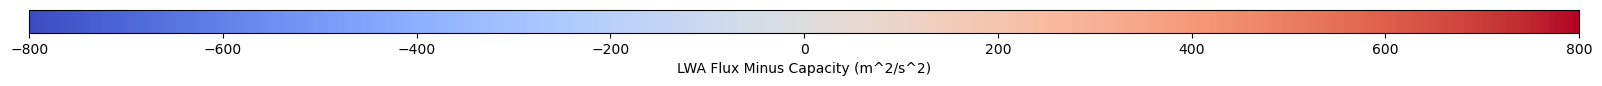

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 创建一个ScalarMappable对象，用于colorbar
norm = plt.Normalize(vmin=-800, vmax=800)
sm = cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  # 你可能需要设置一个空数组，只是为了满足函数要求

# 创建一个figure对象
fig, ax = plt.subplots(figsize=(20, 0.3))  # figsize根据需要进行调整

# 创建横向colorbar
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')

# 设置colorbar的标签
cbar.set_label('LWA Flux Minus Capacity (m^2/s^2)')

plt.show()


In [12]:
# 0221 Update: weighted center, tree nodes
# 0308 Update: prob calculation
# 0313 Update: only do poster 2013 session, NH

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import matplotlib.patches as patches

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(2013_01_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            return time_stamp, total_flux
    return None, None

def remove_enclosed_rectangles(large_rectangles):
    # Create a new list for rectangles that are not fully enclosed
    filtered_rectangles = []
    
    for i, rect1 in enumerate(large_rectangles):
        rect1_area = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])  # Calculate area of rect1
        is_enclosed = False
        
        for j, rect2 in enumerate(large_rectangles):
            if i != j:  # Don't compare a rectangle with itself
                # Calculate overlap area
                overlap_left = max(rect1[0], rect2[0])
                overlap_right = min(rect1[1], rect2[1])
                overlap_bottom = max(rect1[2], rect2[2])
                overlap_top = min(rect1[3], rect2[3])
                
                if overlap_right > overlap_left and overlap_top > overlap_bottom:
                    overlap_area = (overlap_right - overlap_left) * (overlap_top - overlap_bottom)
                    if overlap_area / rect1_area >= 0.7:
                        is_enclosed = True
                        break

        if not is_enclosed:
            filtered_rectangles.append(rect1)
    return filtered_rectangles


def update_large_rectangles(box):
    global large_rectangles
    box_left, box_right, box_bottom, box_top = box

    # Adjust for wrap around
    if box_right < box_left:
        box_right += flux_difference.shape[1]

    new_rect_area = (box_right - box_left) * (box_top - box_bottom)

    for large_rect in large_rectangles:
        rect_left, rect_right, rect_bottom, rect_top = large_rect

        # Adjust for wrap around
        if rect_right < rect_left:
            rect_right += flux_difference.shape[1]

        # Calculate overlap area
        overlap_left = max(box_left, rect_left)
        overlap_right = min(box_right, rect_right)
        overlap_bottom = max(box_bottom, rect_bottom)
        overlap_top = min(box_top, rect_top)

        # Ensure there is an overlap
        if overlap_right > overlap_left and overlap_top > overlap_bottom:
            overlap_area = (overlap_right - overlap_left) * (overlap_top - overlap_bottom)
        else:
            overlap_area = 0

        # Check if the new rectangle is mostly enclosed by an existing one
        if overlap_area / new_rect_area >= 0.8:
            return  # Skip adding this rectangle

        # Update the large rectangle's boundaries if there's overlap
        if not (box_right < rect_left or box_left > rect_right or box_top < rect_bottom or box_bottom > rect_top):
            large_rect[0] = min(rect_left, box_left)
            large_rect[1] = max(rect_right, box_right)
            large_rect[2] = min(rect_bottom, box_bottom)
            large_rect[3] = max(rect_top, box_top)
            return

    # If the rectangle is not mostly enclosed by any existing rectangle, add it
    large_rectangles.append([box_left, box_right % flux_difference.shape[1], box_bottom, box_top])

    
    large_rectangles.append([box_left, box_right % flux_difference.shape[1], box_bottom, box_top])

def draw_rectangles(ax, rectangles, flux_difference_shape):
    for rect in rectangles:
        left, right, bottom, top = rect
        
        # Adjust coordinates to match the longitude and latitude scales
        left_lon = left * 1.5
        right_lon = right * 1.5 if right <= flux_difference_shape else (right % flux_difference_shape) * 1.5
        bottom_lat = -90 + (bottom * 1.5)  # Convert steps to latitude
        top_lat = -90 + (top * 1.5)  # Convert steps to latitude
        
        if right_lon < left_lon:
            # Draw wrap-around rectangles
            rect_left = patches.Rectangle((left_lon, bottom_lat), 360 - left_lon, top_lat - bottom_lat + 1, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect_left)
            rect_right = patches.Rectangle((0, bottom_lat), right_lon, top_lat - bottom_lat + 1, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect_right)
        else:
            rect = patches.Rectangle((left_lon, bottom_lat), right_lon - left_lon, top_lat - bottom_lat + 1, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

# Update figure setup and axis labels for longitude and latitude
def setup_figure_and_axes():
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title('2D Heatmap of Flux Difference')
    ax.set_xlabel('Longitude (0E to 360E)')
    ax.set_ylabel('Latitude (0N to 90N)')
#     ax.set_xticks(np.arange(0, 361, 30))  # Longitude labels every 30 degrees
#     ax.set_yticks(np.arange(0, 91, 10))  # Latitude labels every 10 degrees
#     ax.set_xticklabels([f'{i}E' for i in range(0, 361, 30)])
#     ax.set_yticklabels([f'{90-i}N' for i in range(0, 91, 10)])  # Convert steps to latitude labels
    return fig, ax


def calculate_weighted_center(rectangle, flux_difference):
    left, right, bottom, top = rectangle
    # Handle wrap-around by adjusting the indices
    if right < left:
        if (right - 0) > (240 - left):
            weighted_center_x = (0+right) / 2
            weighted_center_y = (top + bottom) / 2
        else:
            weighted_center_x = (240+left) / 2
            weighted_center_y = (top + bottom) / 2
    else:    
        x_indices, y_indices = np.meshgrid(np.arange(left, right) % flux_difference.shape[1], np.arange(bottom, top+1))
        area_values = flux_difference[bottom:top+1, left:right] if right <= flux_difference.shape[1] else np.hstack((flux_difference[bottom:top+1, left:], flux_difference[bottom:top+1, :right % flux_difference.shape[1]]))
        total_weight = np.sum(area_values)
        weighted_center_x = np.sum(x_indices.flatten() * area_values.flatten()) / total_weight
        weighted_center_y = np.sum(y_indices.flatten() * area_values.flatten()) / total_weight
        # Adjust the weighted center x-coordinate for wrap-around
        weighted_center_x = weighted_center_x % flux_difference.shape[1]
    return weighted_center_x, weighted_center_y


input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0314/"
os.makedirs(output_directory, exist_ok=True)

pattern = re.compile(r'F[1]_2013_2013_01_[\d]{2}_(00|06|12|18).npy')

f1_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

results = Parallel(n_jobs=-2)(delayed(load_single_flux_data)(input_directory, f, pattern) for f in tqdm(f1_files))

flux_data = {time_stamp: flux for time_stamp, flux in results if time_stamp is not None}

flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")

rectangle_data = []

# Inside the loop where you generate the heatmap and rectangles
for time_stamp, total_flux in flux_data.items():
    large_rectangles = []
    flux_difference = total_flux - flux_capacity_2d

    fig, ax = setup_figure_and_axes()
    heatmap = ax.imshow(flux_difference[60:121, :], cmap='coolwarm', aspect='auto', vmin=-800, vmax=800, origin='lower')  # Adjusted to include only 60-120 steps
    plt.colorbar(heatmap, label='Flux Difference (m^2/s^2)')
    ax.set_title(f'2D Heatmap of Flux Difference: {time_stamp}')
    
    num_squares = 0  # Initialize counter for squares

    square_size = 8
    dim2_range = range(76, 97)
    
    for i in dim2_range:
        for j in range(flux_difference.shape[1]):
            left = j
            right = (j + square_size) % flux_difference.shape[1]
            bottom = i
            top = i + square_size - 1

            if right > left:
                box_values = flux_difference[bottom:top+1, left:right]
            else:
                box_values_left = flux_difference[bottom:top+1, left:]
                box_values_right = flux_difference[bottom:top+1, :right]
                box_values = np.hstack((box_values_left, box_values_right))

            if np.sum(box_values > 100) / box_values.size >= 0.8:
                update_large_rectangles((left, right % flux_difference.shape[1], bottom, top))
                num_squares += 1  # Update counter for squares

    # Filter large rectangles for enclosures here after they are all added
    large_rectangles = remove_enclosed_rectangles(large_rectangles)

    draw_rectangles(ax, large_rectangles, flux_difference.shape[1])
    
    plt.savefig(os.path.join(output_directory, f"flux_difference_{time_stamp}.png"))
    plt.close()

    print(f"Total number of squares with all positive flux difference for {time_stamp}: {num_squares}")
    print(f"Total number of large rectangles for {time_stamp}: {len(large_rectangles)}")  # Use len() for accurate count

    for rect in large_rectangles:
        wc_x, wc_y = calculate_weighted_center(rect, flux_difference)
        rectangle_data.append([time_stamp, rect[0] % flux_difference.shape[1], rect[1] % flux_difference.shape[1], rect[2], rect[3], wc_x, wc_y])

# Convert rectangle_data to DataFrame and save to CSV as before, including the new weighted center columns
df = pd.DataFrame(rectangle_data, columns=['TimeStamp', 'Left', 'Right', 'Bottom', 'Top', 'WeightedCenterX', 'WeightedCenterY'])
df['MinLon'] = df['Left'] * 1.5
df['MaxLon'] = df['Right'] * 1.5
df['MinLat'] = (df['Bottom'] * 1.5) - 90
df['MaxLat'] = (df['Top'] * 1.5) - 90

df['MaxLon'] = df['MaxLon'].apply(lambda x: x - 360 if x > 360 else x)

csv_file = os.path.join(output_directory, "flux_difference_rectangles.csv")
df.to_csv(csv_file, index=False)
print(f"Data written to {csv_file}")


100%|██████████| 124/124 [00:00<00:00, 11866.97it/s]


Total number of squares with all positive flux difference for 2013_01_28_18: 468
Total number of large rectangles for 2013_01_28_18: 5
Total number of squares with all positive flux difference for 2013_01_11_12: 261
Total number of large rectangles for 2013_01_11_12: 4
Total number of squares with all positive flux difference for 2013_01_24_12: 252
Total number of large rectangles for 2013_01_24_12: 3
Total number of squares with all positive flux difference for 2013_01_29_00: 423
Total number of large rectangles for 2013_01_29_00: 4
Total number of squares with all positive flux difference for 2013_01_08_12: 73
Total number of large rectangles for 2013_01_08_12: 2
Total number of squares with all positive flux difference for 2013_01_03_12: 190
Total number of large rectangles for 2013_01_03_12: 4
Total number of squares with all positive flux difference for 2013_01_29_06: 384
Total number of large rectangles for 2013_01_29_06: 3
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2013_01_30_00: 334
Total number of large rectangles for 2013_01_30_00: 5
Total number of squares with all positive flux difference for 2013_01_10_00: 72
Total number of large rectangles for 2013_01_10_00: 1
Total number of squares with all positive flux difference for 2013_01_23_18: 268
Total number of large rectangles for 2013_01_23_18: 4
Total number of squares with all positive flux difference for 2013_01_05_12: 147
Total number of large rectangles for 2013_01_05_12: 3
Total number of squares with all positive flux difference for 2013_01_16_00: 296
Total number of large rectangles for 2013_01_16_00: 3
Total number of squares with all positive flux difference for 2013_01_17_06: 147
Total number of large rectangles for 2013_01_17_06: 3
Total number of squares with all positive flux difference for 2013_01_24_06: 296
Total number of large rectangles for 2013_01_24_06: 2
Total number of squares with all positive flux differenc

Total number of squares with all positive flux difference for 2013_01_01_18: 345
Total number of large rectangles for 2013_01_01_18: 4
Total number of squares with all positive flux difference for 2013_01_16_18: 159
Total number of large rectangles for 2013_01_16_18: 5
Data written to /scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0314/flux_difference_rectangles.csv


In [10]:
# assign id num

df = pd.read_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/flux_difference_rectangles.csv")


# Sorting the DataFrame by the TimeStamp column.
df_sorted = df.sort_values('TimeStamp')

# Adding the 'event_id' column by using the index + 1 (since index starts from 0).
df_sorted['event_id'] = range(1, len(df_sorted) + 1)

# Saving the updated DataFrame to a new CSV file.
updated_csv_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/flux_difference_rectangles.csv"
df_sorted.to_csv(updated_csv_path, index=False)

In [11]:
import pandas as pd
from datetime import datetime, timedelta

# Step 1: Read the CSV File
df = pd.read_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/flux_difference_rectangles.csv")

# Step 2: Prepare the Data
# Convert 'TimeStamp' to datetime and filter for DJF months
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d_%H')
df = df[df['TimeStamp'].dt.month.isin([12, 1, 2])]

# Function to check if a rectangle is within another
def is_within(current_rect, earlier_rect):
    cx, cy = current_rect['WeightedCenterX'], current_rect['WeightedCenterY']
    return earlier_rect['Left'] <= cx <= earlier_rect['Right'] and earlier_rect['Bottom'] <= cy <= earlier_rect['Top']

# Step 3: Track Exceedance Events
# Initialize a dictionary to store the top-most node and duration of each tree
event_trees = {}

# Iterate through each rectangle in the DataFrame
for index, current_rect in df.iterrows():
    current_time = current_rect['TimeStamp']
    current_id = current_rect['event_id']
    
    # start of DJF does not have earlier time
    if current_time.month == 12 and current_time.day == 1 and current_time.hour == 0:
        # This is the start of DJF, so it's a new event by default
        event_trees[current_id] = current_id
        continue  # Skip this iteration
    earlier_time = current_time - timedelta(hours=6)
    
    # Filter rectangles from six hours earlier
    earlier_rects = df[(df['TimeStamp'] == earlier_time)]
    
    found_parent = False
    for _, earlier_rect in earlier_rects.iterrows():
        if is_within(current_rect, earlier_rect):
            # This rectangle is part of an ongoing exceedance event
            parent_id = event_trees[earlier_rect['event_id']]
            event_trees[current_id] = parent_id
            break
    
    if not found_parent:
        # This rectangle is the start of a new exceedance event
        event_trees[current_time] = {'duration': 1, 'node': current_rect}
        event_trees[current_id] = current_id
    else:
        # Update the duration of the ongoing exceedance event
        if earlier_time in event_trees:
            event_trees[earlier_time]['duration'] += 1
            event_trees[current_id] = current_id
            
# Update the df with the parent event_id for each rectangle
for index, row in df.iterrows():
    df.at[index, 'event_id'] = event_trees[row['event_id']]
    
# Step 4 & 5: Output Results
# Prepare the data for the new CSV
output_data = []
for start_time, info in event_trees.items():
    node = info['node']
    output_data.append([start_time, node['Left'], node['Right'], node['Bottom'], node['Top'], node['WeightedCenterX'], node['WeightedCenterY'], info['duration']])

# Convert to DataFrame and save to new CSV
output_df = pd.DataFrame(output_data, columns=['StartTime', 'Left', 'Right', 'Bottom', 'Top', 'WeightedCenterX', 'WeightedCenterY', 'Duration'])
output_df.to_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/exceedance_event_trees.csv", index=False)

# Step 6: Print the Tree Structure for DJF 2016-2017
# This step requires a specific visualization or text representation which can be quite complex.
# As an example, we'll just print out the start times and durations of the trees for now.
print("Exceedance Event Trees for DJF 2016-2017:")
for start_time, info in event_trees.items():
    if (start_time.year == 2016 and start_time.month in [12]) or (start_time.year == 2017 and start_time.month in [1, 2]):
        print(f"Start Time: {start_time}, Duration: {info['duration']}")


TypeError: 'int' object is not subscriptable

In [12]:


import pandas as pd
from datetime import datetime, timedelta

# Step 1: Read the CSV File
df = pd.read_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/flux_difference_rectangles.csv")

# Step 2: Prepare the Data
# Convert 'TimeStamp' to datetime and filter for DJF months
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d_%H')
df = df[df['TimeStamp'].dt.month.isin([12, 1, 2])]

# Function to check if a rectangle is within another
def is_within(current_rect, earlier_rect):
    cx, cy = current_rect['WeightedCenterX'], current_rect['WeightedCenterY']
    return earlier_rect['Left'] <= cx <= earlier_rect['Right'] and earlier_rect['Bottom'] <= cy <= earlier_rect['Top']

# Step 3: Track Exceedance Events
event_trees = {}  # Dictionary to store the earliest event_id for ongoing events

for index, current_rect in df.iterrows():
    current_time = current_rect['TimeStamp']
    current_id = current_rect['event_id']
    found_parent = False
    
    # Check for earlier events
    earlier_time = current_time - timedelta(hours=6)
    earlier_rects = df[(df['TimeStamp'] == earlier_time)]
    
    for _, earlier_rect in earlier_rects.iterrows():
        if is_within(current_rect, earlier_rect):
            parent_id = event_trees.get(earlier_rect['event_id'])
            if parent_id:
                event_trees[current_id] = parent_id
                found_parent = True
                break
    
    if not found_parent:
        event_trees[current_id] = current_id  # New event starts

# Update the event_id in the DataFrame
df['event_id'] = df['event_id'].map(event_trees)
            
# Update the df with the parent event_id for each rectangle
for index, row in df.iterrows():
    df.at[index, 'event_id'] = event_trees[row['event_id']]
    
# Step 4 & 5: Output Results
# Prepare the data for the new CSV
output_data = []
for start_time, info in event_trees.items():
    node = info['node']
    output_data.append([start_time, node['Left'], node['Right'], node['Bottom'], node['Top'], node['WeightedCenterX'], node['WeightedCenterY'], info['duration']])

# Convert to DataFrame and save to new CSV
output_df = pd.DataFrame(output_data, columns=['StartTime', 'Left', 'Right', 'Bottom', 'Top', 'WeightedCenterX', 'WeightedCenterY', 'Duration'])
output_df.to_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/exceedance_event_trees.csv", index=False)

# Step 6: Print the Tree Structure for DJF 2016-2017
# This step requires a specific visualization or text representation which can be quite complex.
# As an example, we'll just print out the start times and durations of the trees for now.
print("Exceedance Event Trees for DJF 2016-2017:")
for start_time, info in event_trees.items():
    if (start_time.year == 2016 and start_time.month in [12]) or (start_time.year == 2017 and start_time.month in [1, 2]):
        print(f"Start Time: {start_time}, Duration: {info['duration']}")


TypeError: 'int' object is not subscriptable

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import re

def process_flux_difference(time_stamp, total_flux, flux_capacity_2d, event_trees_df, heatmap_directory):
    # Calculate the flux difference
    flux_difference = total_flux - flux_capacity_2d
    
    # Calculate the 1st and 99th percentiles for color scaling
    vmin, vmax = np.percentile(flux_difference, 1), np.percentile(flux_difference, 99)
    
    # Initialize plot for this timestamp
    plt.figure(figsize=(20, 12))
    plt.imshow(flux_difference, cmap='coolwarm', aspect='auto', vmin=-1000, vmax=500, origin='lower')
    plt.colorbar(label='Flux Difference')
    plt.title(f'Flux Difference with Rectangles: {time_stamp}')
    plt.xlabel('Dimension 1 - lon steps')
    plt.ylabel('Dimension 2 - lat steps')

    # Filter rectangles for the current timestamp from the event tracking DataFrame
    current_rectangles = event_trees_df[event_trees_df['StartTime'] == pd.to_datetime(time_stamp, format='%Y_%m_%d_%H')]

    
    # Draw and annotate rectangles with duration
    for idx, row in current_rectangles.iterrows():
        left, right = row['Left'], row['Right']
        bottom, top = row['Bottom'], row['Top']
        duration = row['Duration']
        
        # Check and adjust for rectangles that might exceed the plotting boundary
        if right > 240:
            right -= 240  # Adjust right boundary for wrap-around rectangles
        
        # Plot rectangle
        rect = patches.Rectangle((left, bottom), right - left, top - bottom, linewidth=1, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Annotate duration inside the rectangle
        plt.text(left + 0.5, bottom + 0.5, f'Duration: {duration}', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Save the plot as a PNG file in the heatmap subdirectory
    output_png = os.path.join(heatmap_directory, f"flux_difference_{time_stamp}.png")
    plt.savefig(output_png)
    plt.close()  # Close the plot after saving

# Load the event tracking data

event_trees_csv = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0310/exceedance_event_trees.csv"
event_trees_df = pd.read_csv(event_trees_csv)
# Correctly convert 'StartTime' to datetime objects with the specified format
event_trees_df['StartTime'] = pd.to_datetime(event_trees_df['StartTime'])


# Define the heatmap directory where the output images will be saved
heatmap_directory = os.path.join(output_directory, "heatmaps_with_durations")
os.makedirs(heatmap_directory, exist_ok=True)

# Process each flux difference file to generate and save annotated heatmaps
Parallel(n_jobs=-1)(
    delayed(process_flux_difference)(time_stamp, flux_data[time_stamp], flux_capacity_2d, event_trees_df, heatmap_directory)
    for time_stamp in tqdm(flux_data.keys(), desc="Processing heatmaps")
)

print(f"Heatmaps with annotated rectangles saved in {heatmap_directory}")


KeyError: 'StartTime'

In [8]:
import pandas as pd
import os


output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/"
csv_file = os.path.join(output_directory, "exceedance_event_trees.csv")

df = pd.read_csv(csv_file)


df['MinLon'] = df['Left'] * 1.5
df['MaxLon'] = df['Right'] * 1.5
df['MinLat'] = (df['Bottom'] * 1.5) - 90
df['MaxLat'] = (df['Top'] * 1.5) - 90
df['LonCenter'] = df['WeightedCenterX'] * 1.5
df['LatCenter'] = df['WeightedCenterY'] * 1.5 - 90


df['MaxLon'] = df['MaxLon'].apply(lambda x: x - 360 if x > 360 else x)
df['LonCenter'] = df['LonCenter'].apply(lambda x: x - 360 if x > 360 else x)


print('done!')


df.to_csv(csv_file, index=False)


done!


StartTime	Left	Right	Bottom	Top	WeightedCenterX	WeightedCenterY	Duration	MinLon	MaxLon	MinLat	MaxLat	LonCenter	LatCenter

1979/1/2 6:00	220	4	78	87	211.1312921	82.57805232	3	330	6	27	40.5	316.6969382	33.86707848341865


In [7]:
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

# Combine the data from both files
combined_data = np.concatenate((data1, data2))

# Filter for events within 30-60°N, in Dec, Jan, or Feb, and year >= 1979
filtered_events = []
for event in combined_data:
    event_date = event[0]
    event_lat = float(event[3].split(': ')[1])
    if 30 <= event_lat <= 60 and event_date.month in [12, 1, 2] and event_date.year >= 1979 and event_date.year <= 2016:
        filtered_events.append(event)
        
print(filtered_events)

[array([datetime.datetime(1979, 1, 12, 0, 0), 'duration: 5', 'Lon: 333',
       'Lat: 59'], dtype=object), array([datetime.datetime(1979, 12, 9, 0, 0), 'duration: 5', 'Lon: 1',
       'Lat: 40'], dtype=object), array([datetime.datetime(1980, 1, 15, 0, 0), 'duration: 6', 'Lon: 189',
       'Lat: 48'], dtype=object), array([datetime.datetime(1980, 1, 17, 0, 0), 'duration: 5', 'Lon: 11',
       'Lat: 56'], dtype=object), array([datetime.datetime(1980, 2, 4, 0, 0), 'duration: 7', 'Lon: 52',
       'Lat: 49'], dtype=object), array([datetime.datetime(1980, 2, 20, 0, 0), 'duration: 9', 'Lon: 2',
       'Lat: 51'], dtype=object), array([datetime.datetime(1980, 12, 6, 0, 0), 'duration: 6', 'Lon: 215',
       'Lat: 43'], dtype=object), array([datetime.datetime(1980, 12, 8, 0, 0), 'duration: 5', 'Lon: 162',
       'Lat: 46'], dtype=object), array([datetime.datetime(1980, 12, 12, 0, 0), 'duration: 6', 'Lon: 215',
       'Lat: 37'], dtype=object), array([datetime.datetime(1980, 12, 17, 0, 0), 'dura


Checking events: 100%|██████████| 139/139 [00:29<00:00,  4.69it/s]


Match Ratio: 0.4316546762589928
Match Counts: 60
Non-Match Ratio: 0.5683453237410072
Non-Match Counts: 79
Exceedance Ratio: 0.9932142049310111
Exceedance Counts: 8782


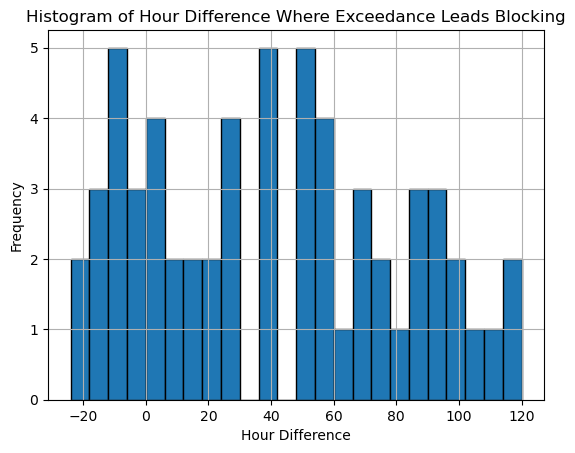

Data written to /scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv


In [12]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import os

# Ignore specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load data
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

combined_data = np.concatenate((data1, data2))

# Filter events
filtered_events = [
    event for event in combined_data
    if 30 <= float(event[3].split(': ')[1]) <= 60 and
       event[0].month in [12, 1, 2] and
       1979 <= event[0].year <= 2016
]

# Load rectangle data
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/"
filtered_csv_file = os.path.join(output_directory, "exceedance_event_trees.csv")
csv_data = pd.read_csv(filtered_csv_file)

# Correctly convert 'StartTime' to datetime objects with the specified format
csv_data['StartTime'] = pd.to_datetime(csv_data['StartTime'], format='%Y-%m-%d %H:%M:%S')


# Initialize counts and results DataFrame with an additional column for Hour Difference
results_df = pd.DataFrame(columns=['Latitude', 'Longitude', 'EventType', 'Time', 'Hour Difference'])
match_count = 0  # Initialize match counter
non_match_count = 0  # Initialize non-match counter
exceedance_count = 0  # Initialize exceedance counter


# Check for matches
for event in tqdm(filtered_events, desc="Checking events"):
    event_date = event[0]
    event_lon, event_lat = float(event[2].split(': ')[1]), float(event[3].split(': ')[1])
    event_matched = False
    hour_difference = None  # Initialize hour difference
    
    for index, row in csv_data.iterrows():
        row_date = row['StartTime'] 
        
        # Check if event_date is within the specific window
        if row_date - timedelta(days=1) <= event_date <= row_date + timedelta(days=5):
            time_delta = event_date - row_date
            hour_difference = time_delta.total_seconds() / 3600  # Calculate hour difference
            
            # Additional checks for longitude and latitude
            if row['MaxLon'] < row['MinLon']:  # Wrapping around longitude 0
                if ((row['MinLon'] <= event_lon <= 360) or (0 <= event_lon <= row['MaxLon'])) and (row['MinLat'] <= event_lat <= row['MaxLat']):
                    event_matched = True
                    break
            else:
                if (row['MinLon'] <= event_lon <= row['MaxLon']) and (row['MinLat'] <= event_lat <= row['MaxLat']):
                    event_matched = True
                    break
    
    new_row = pd.DataFrame({
        'Latitude': [event_lat],
        'Longitude': [event_lon],
        'EventType': ['Match' if event_matched else 'Non-Match'],
        'Time': [event_date],
        'Hour Difference': [hour_difference]  # Store the hour difference
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    if event_matched:
        match_count += 1
    else:
        non_match_count += 1


# Identify exceedance rectangles
exceedance_rectangles = set(range(len(csv_data))) - set(results_df[results_df['EventType'] == 'Match'].index)
for rect_index in exceedance_rectangles:
    row = csv_data.iloc[rect_index]
    new_row = pd.DataFrame({
        'Latitude': [row['LatCenter']],
        'Longitude': [row['LonCenter']],
        'EventType': ['Exceedance'],
        'Time': [row['StartTime']]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    exceedance_count += 1

# Calculate ratios and print results
match_ratio = match_count / len(filtered_events) if filtered_events else 0
non_match_ratio = non_match_count / len(filtered_events) if filtered_events else 0
exceedance_ratio = exceedance_count / len(csv_data) if not csv_data.empty else 0

print(f"Match Ratio: {match_ratio}")
print(f"Match Counts: {match_count}")
print(f"Non-Match Ratio: {non_match_ratio}")
print(f"Non-Match Counts: {non_match_count}")
print(f"Exceedance Ratio: {exceedance_ratio}")
print(f"Exceedance Counts: {exceedance_count}")


# Save results to CSV
results_file = os.path.join(output_directory, "filtered_results_with_hour_difference.csv")
results_df.to_csv(results_file, index=False)

# Generate histogram for Hour Difference for matches
matches = results_df[results_df['EventType'] == 'Match']
plt.hist(matches['Hour Difference'].dropna(), bins=range(-24, 121, 6), edgecolor='black')
plt.title('Histogram of Hour Difference Where Exceedance Leads Blocking')
plt.xlabel('Hour Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Data written to {results_file}")


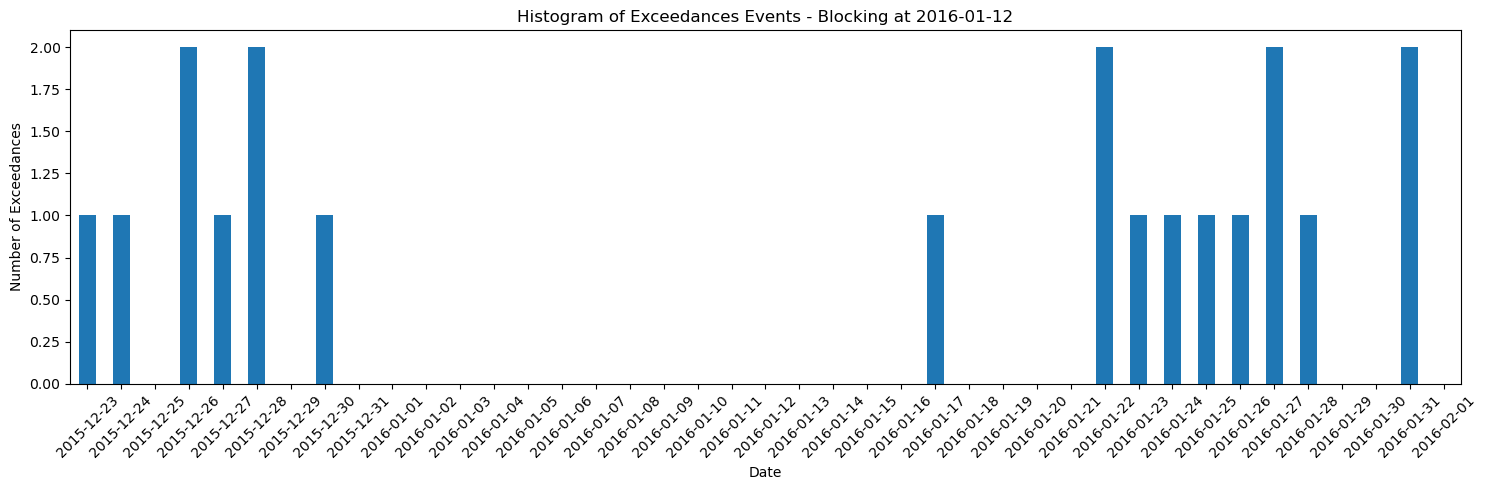

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/exceedance_event_trees.csv')  

# Define the target location
target_lon = 356
target_lat = 50

# Convert the 'StartTime' to datetime for comparison
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%Y/%m/%d %H:%M')

# Define the date range
start_date = datetime(2016, 1, 12) - timedelta(days=20)
end_date = datetime(2016, 1, 12) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['StartTime'] >= start_date) &
                     (df['StartTime'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['StartTime'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances Events - Blocking at 2016-01-12')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


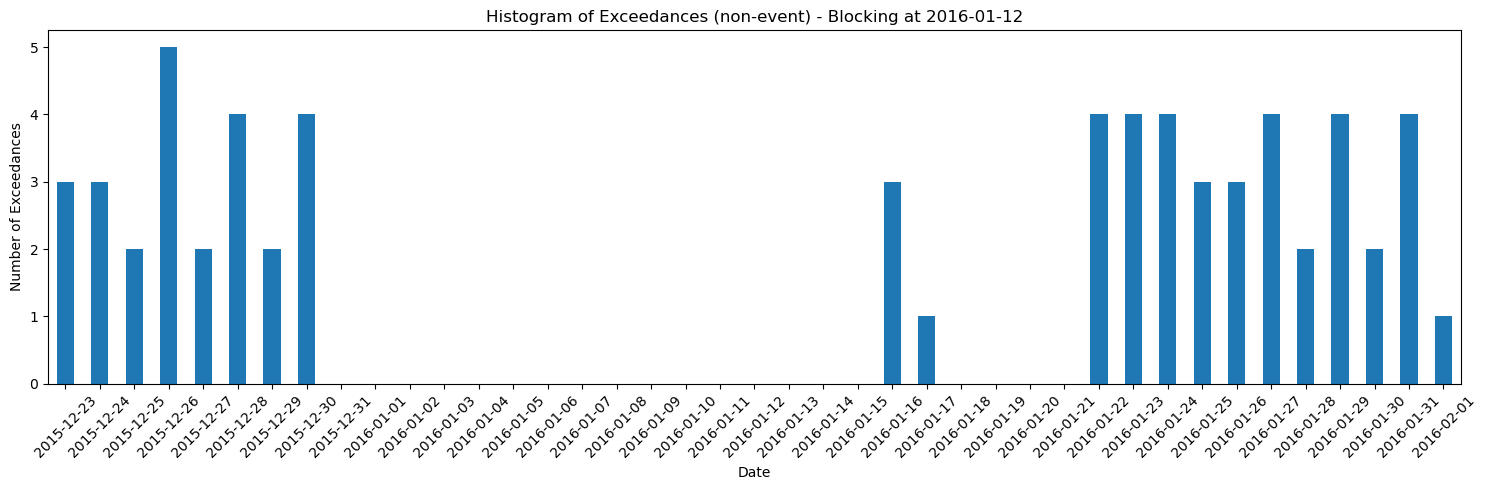

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/flux_difference_rectangles.csv')  # Replace with the actual path

# Define the target location
target_lon = 356
target_lat = 50

# Convert the 'TimeStamp' to datetime for comparison
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d_%H')

# Define the date range
start_date = datetime(2016, 1, 12) - timedelta(days=20)
end_date = datetime(2016, 1, 12) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['TimeStamp'] >= start_date) &
                     (df['TimeStamp'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['TimeStamp'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances (non-event) - Blocking at 2016-01-12')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


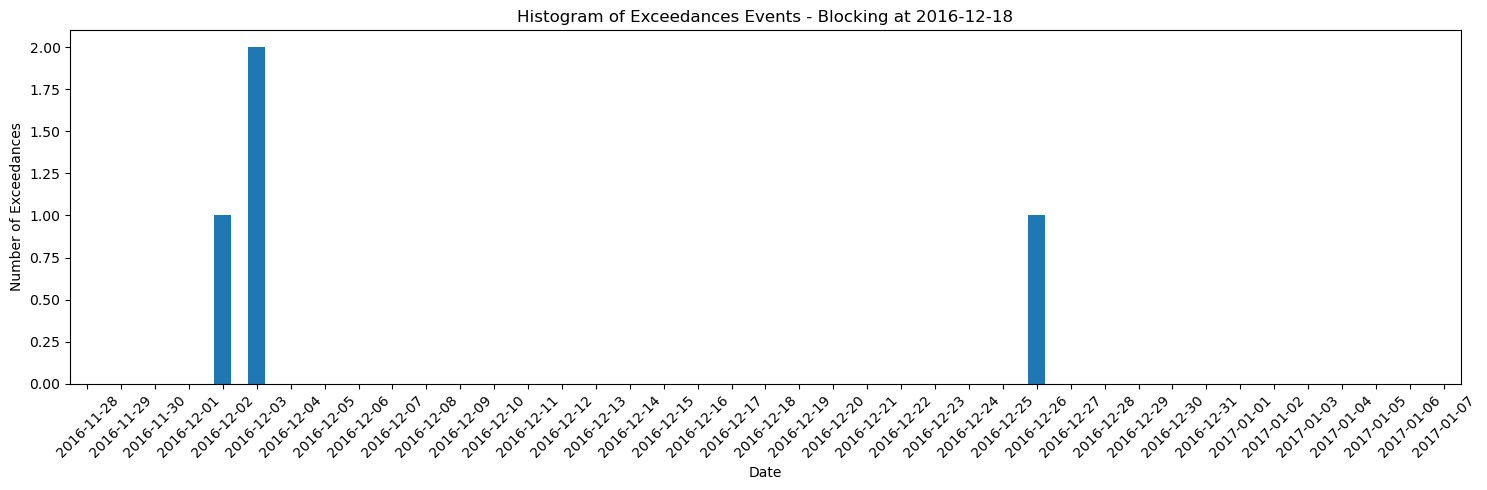

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/exceedance_event_trees.csv')  # Replace with the actual path

# Define the target location
target_lon = 213
target_lat = 42

# Convert the 'StartTime' to datetime for comparison
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%Y/%m/%d %H:%M')

# Define the date range
start_date = datetime(2016, 12, 18) - timedelta(days=20)
end_date = datetime(2016, 12, 18) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['StartTime'] >= start_date) &
                     (df['StartTime'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['StartTime'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances Events - Blocking at 2016-12-18')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


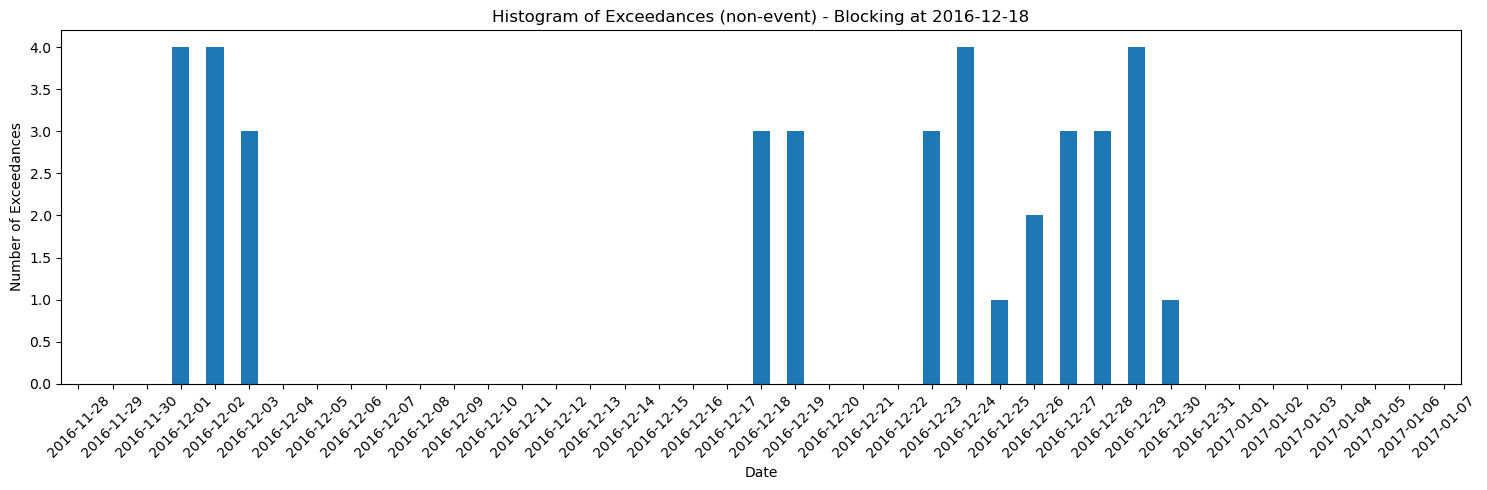

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/flux_difference_rectangles.csv')  # Replace with the actual path

# Define the target location
target_lon = 213
target_lat = 42

# Convert the 'TimeStamp' to datetime for comparison
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d_%H')

# Define the date range
start_date = datetime(2016, 12, 18) - timedelta(days=20)
end_date = datetime(2016, 12, 18) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['TimeStamp'] >= start_date) &
                     (df['TimeStamp'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['TimeStamp'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances (non-event) - Blocking at 2016-12-18')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


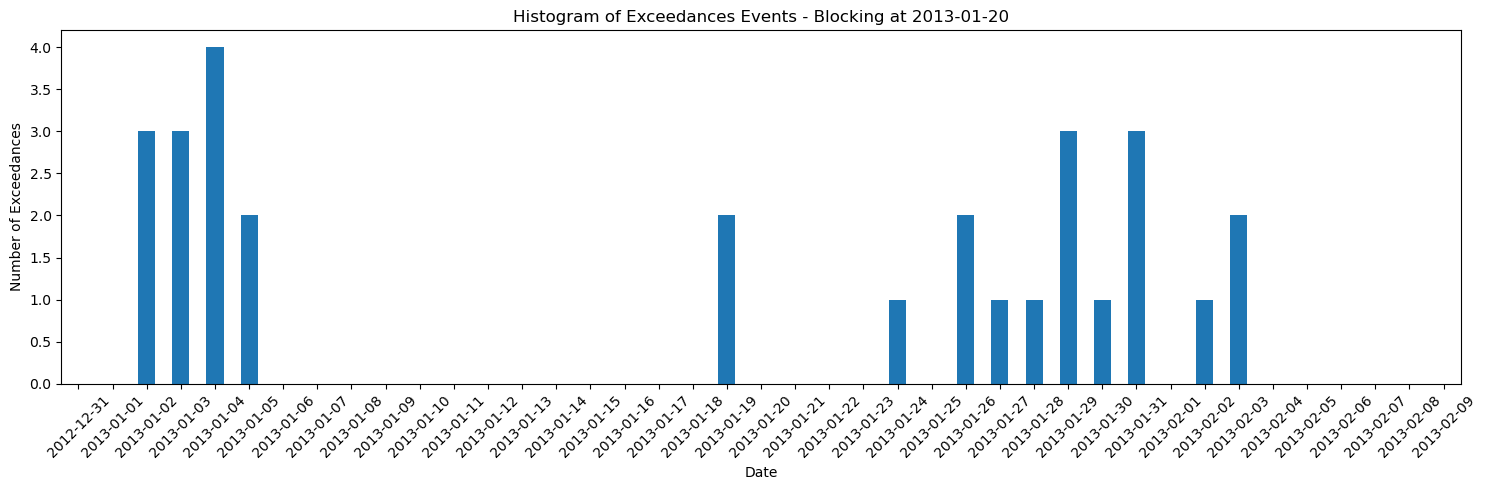

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/exceedance_event_trees.csv')  # Replace with the actual path

# Define the target location
target_lon = 340
target_lat = 42

# Convert the 'StartTime' to datetime for comparison
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%Y/%m/%d %H:%M')

# Define the date range
start_date = datetime(2013, 1, 20) - timedelta(days=20)
end_date = datetime(2013, 1, 20) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['StartTime'] >= start_date) &
                     (df['StartTime'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['StartTime'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances Events - Blocking at 2013-01-20')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


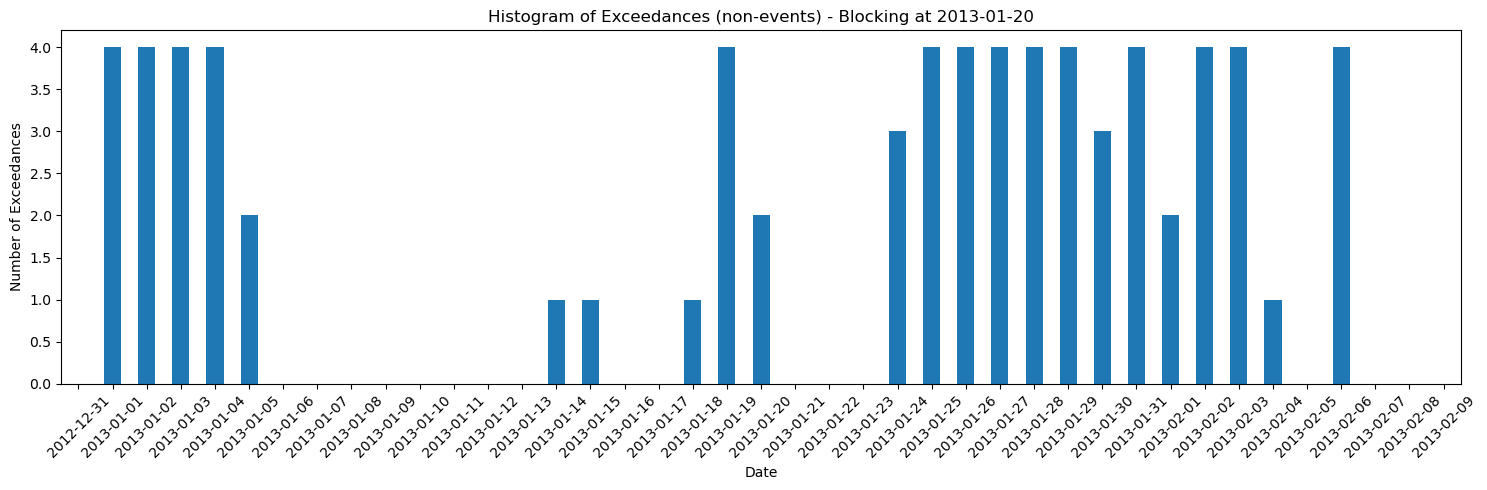

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/flux_difference_rectangles.csv')  # Replace with the actual path

# Define the target location
target_lon = 340
target_lat = 42

# Convert the 'TimeStamp' to datetime for comparison
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d_%H')

# Define the date range
start_date = datetime(2013, 1, 20) - timedelta(days=20)
end_date = datetime(2013, 1, 20) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['TimeStamp'] >= start_date) &
                     (df['TimeStamp'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['TimeStamp'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances (non-events) - Blocking at 2013-01-20')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


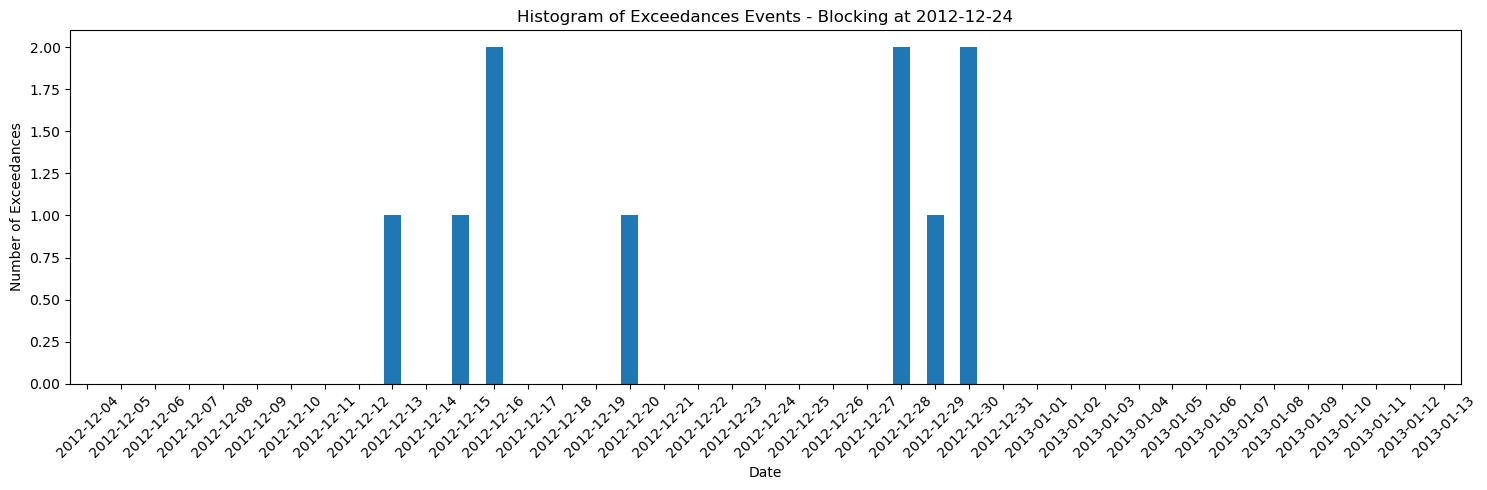

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/exceedance_event_trees.csv')  # Replace with the actual path

# Define the target location
target_lon = 174
target_lat = 55

# Convert the 'StartTime' to datetime for comparison
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%Y/%m/%d %H:%M')

# Define the date range
start_date = datetime(2012, 12, 24) - timedelta(days=20)
end_date = datetime(2012, 12, 24) + timedelta(days=20)

# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['StartTime'] >= start_date) &
                     (df['StartTime'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['StartTime'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances Events - Blocking at 2012-12-24')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


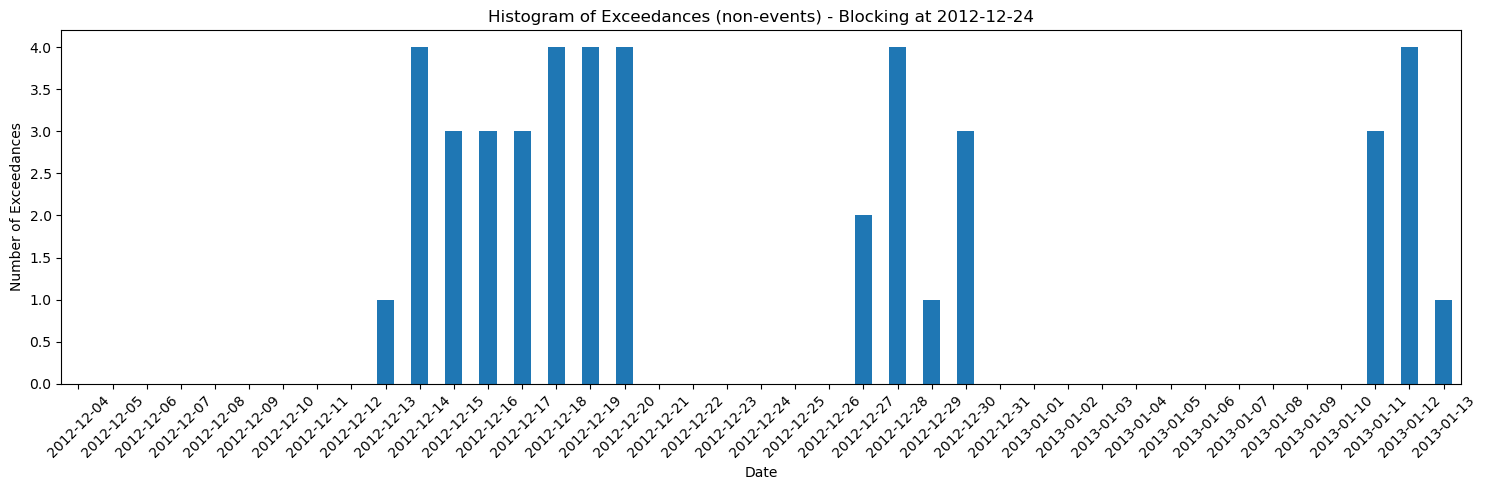

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/flux_difference_rectangles.csv')  # Replace with the actual path

# Define the target location
target_lon = 174
target_lat = 55

# Convert the 'TimeStamp' to datetime for comparison
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y_%m_%d_%H')

# Define the date range
start_date = datetime(2012, 12, 24) - timedelta(days=20)
end_date = datetime(2012, 12, 24) + timedelta(days=20)


# Create a date range that includes all days from start to end
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Filter the dataframe for the date range and location with additional wrap-around logic
filtered_df = df.loc[(df['TimeStamp'] >= start_date) &
                     (df['TimeStamp'] <= end_date) &
                     (((df['MinLon'] <= df['MaxLon']) & 
                       (df['MinLon'] <= target_lon) & 
                       (df['MaxLon'] >= target_lon)) |
                      ((df['MinLon'] > df['MaxLon']) & 
                       (((target_lon >= 0) & (target_lon <= df['MaxLon'])) |
                        ((df['MinLon'] <= target_lon) & (target_lon <= 360)))))
                     & (df['MinLat'] <= target_lat) & 
                     (df['MaxLat'] >= target_lat)].copy()

# Create a new column 'Date' that contains just the date part of 'StartTime'
filtered_df['Date'] = filtered_df['TimeStamp'].dt.floor('D')

# Count the exceedances for each date, assuming each row in the filtered_df is an exceedance
date_counts = filtered_df.groupby('Date').size()

# Reindex the date_counts with all_dates to ensure all days are included
date_counts = date_counts.reindex(all_dates, fill_value=0)

# No need to divide by 4, as we're counting the occurrences per day
daily_counts = date_counts.reset_index(name='Exceedances')

# Plotting
ax = daily_counts.plot(x='index', y='Exceedances', kind='bar', figsize=(15, 5), legend=False)

# Format x-axis labels to show only the date
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts['index']])

# Show the histogram
plt.xlabel('Date')
plt.ylabel('Number of Exceedances')
plt.title('Histogram of Exceedances (non-events) - Blocking at 2012-12-24')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()  # Adjust layout to fit labels
plt.show()



 49%|████▉     | 4380/8921 [00:30<00:31, 144.41it/s]


 98%|█████████▊| 8760/8921 [01:00<00:01, 143.84it/s]


100%|██████████| 8921/8921 [01:02<00:00, 143.75it/s]
/tmp/ipykernel_144025/27537357.py:163: UserWarning: No contour levels were found within the data range.
  contours = ax.contour(Heaviside_data, levels=[0.50, 0.80], colors='black', extent=[-30, 30, -9, 9])


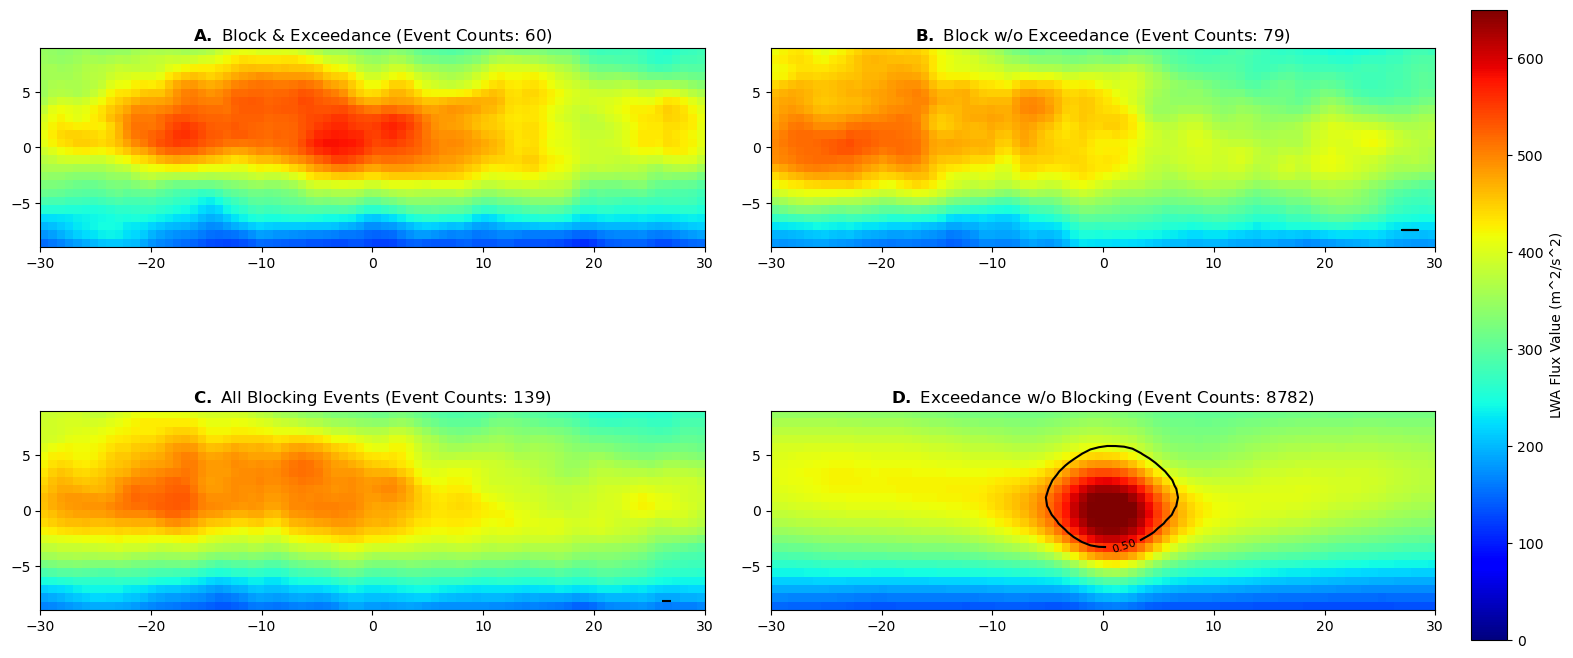

In [19]:
### FIG3

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, Heaviside_data, title, event_count):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels,
    and add Heaviside function contours with labels.
    """
    im = ax.imshow(data, cmap='jet', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=0, vmax=650)
    ax.set_title(f"{title} (Event Counts: {event_count})")

    # Draw contour lines
    contours = ax.contour(Heaviside_data, levels=[0.50, 0.80], colors='black', extent=[-30, 30, -9, 9])
    
    # Label contours
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.2f')

    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, composite_Heaviside_match, r"$\mathbf{A.}$ Block & Exceedance", count_match)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, composite_Heaviside_non_match, r"$\mathbf{B.}$ Block w/o Exceedance", count_non_match)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, composite_Heaviside_both, r"$\mathbf{C.}$ All Blocking Events", count_both)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, composite_Heaviside_exceedance, r"$\mathbf{D.}$ Exceedance w/o Blocking", count_exceedance)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax).set_label('LWA Flux Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()




 49%|████▉     | 4380/8921 [00:30<00:31, 144.31it/s]


 98%|█████████▊| 8760/8921 [01:00<00:01, 144.42it/s]


100%|██████████| 8921/8921 [01:01<00:00, 144.73it/s]
/tmp/ipykernel_144025/621422315.py:163: UserWarning: No contour levels were found within the data range.
  contours = ax.contour(Heaviside_data, levels=[0.50, 0.80], colors='black', extent=[-30, 30, -9, 9])


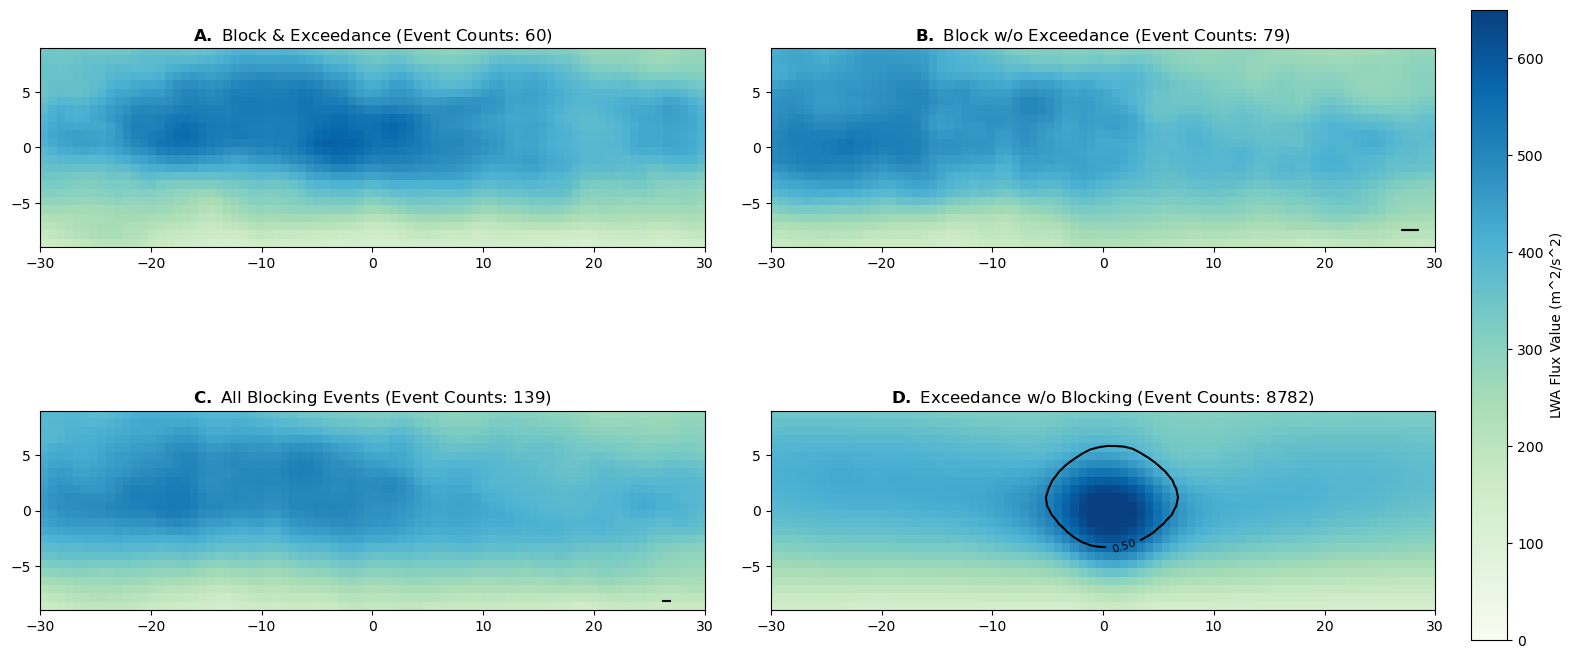

In [21]:
### FIG3

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, Heaviside_data, title, event_count):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels,
    and add Heaviside function contours with labels.
    """
    im = ax.imshow(data, cmap='GnBu', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=0, vmax=650)
    ax.set_title(f"{title} (Event Counts: {event_count})")

    # Draw contour lines
    contours = ax.contour(Heaviside_data, levels=[0.50, 0.80], colors='black', extent=[-30, 30, -9, 9])
    
    # Label contours
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.2f')

    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, composite_Heaviside_match, r"$\mathbf{A.}$ Block & Exceedance", count_match)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, composite_Heaviside_non_match, r"$\mathbf{B.}$ Block w/o Exceedance", count_non_match)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, composite_Heaviside_both, r"$\mathbf{C.}$ All Blocking Events", count_both)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, composite_Heaviside_exceedance, r"$\mathbf{D.}$ Exceedance w/o Blocking", count_exceedance)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax).set_label('LWA Flux Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()




100%|██████████| 8921/8921 [00:20<00:00, 429.50it/s]


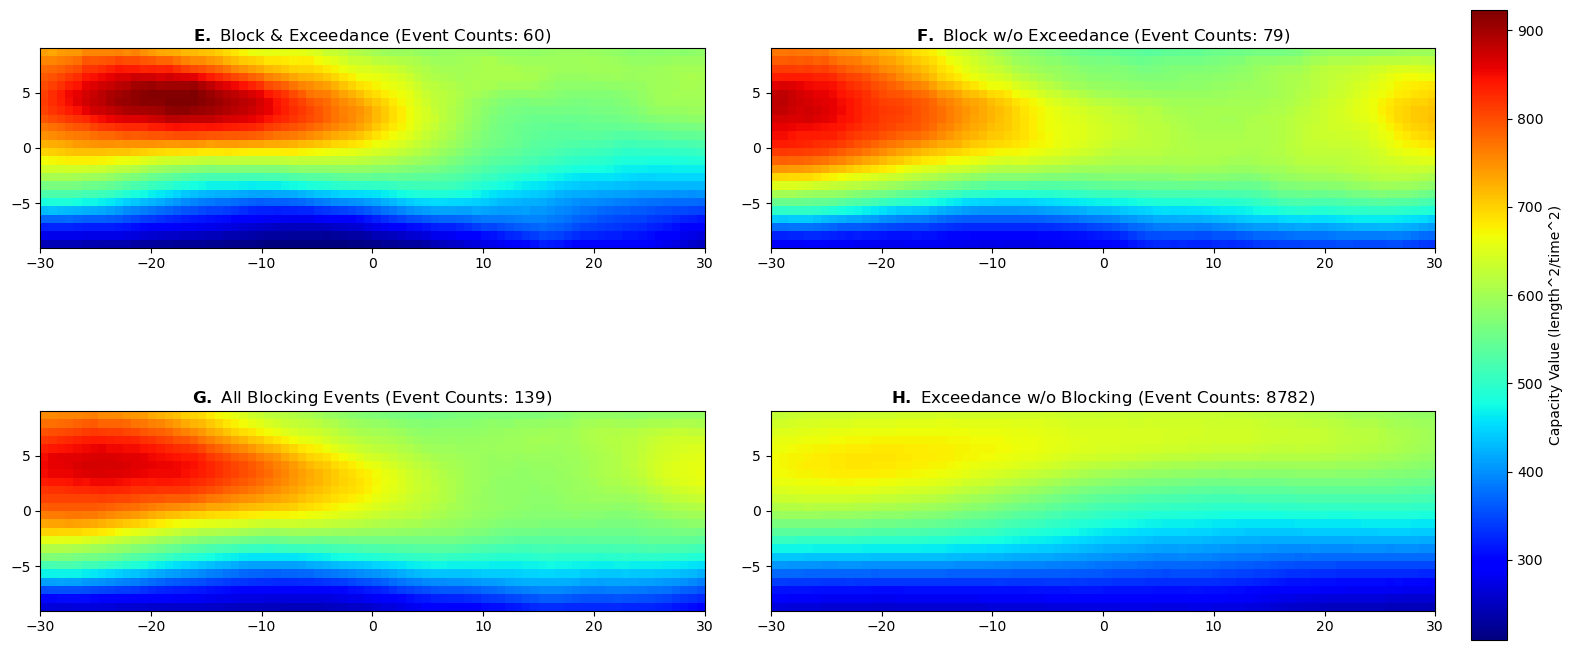

In [20]:
## Fig 4

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Extracting the block from flux capacity data
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    
    return event_type, extracted_block, (year, month, day, hour), (lat, lon)

# Read the results CSV
# results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis/results.csv')
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

global_min = min(composite_heatmap_match.min(), composite_heatmap_non_match.min(), 
                 composite_heatmap_both.min(), composite_heatmap_exceedance.min())
global_max = max(composite_heatmap_match.max(), composite_heatmap_non_match.max(), 
                 composite_heatmap_both.max(), composite_heatmap_exceedance.max())

# Function to plot a heatmap with relative coordinates and global color range
def plot_composite_heatmap(ax, data, title, event_count, vmin, vmax):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels and a global color range.
    """
    im = ax.imshow(data, cmap='jet', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} (Event Counts: {event_count})")
    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and store the return value of imshow from one of them
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, r"$\mathbf{E.}$ Block & Exceedance", count_match, global_min, global_max)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, r"$\mathbf{F.}$ Block w/o Exceedance", count_non_match, global_min, global_max)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, r"$\mathbf{G.}$ All Blocking Events", count_both, global_min, global_max)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, r"$\mathbf{H.}$ Exceedance w/o Blocking", count_exceedance, global_min, global_max)

# Add a colorbar on the right side of the grid using the imshow object 'im'
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Capacity Value (length^2/time^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()


100%|██████████| 8921/8921 [00:20<00:00, 432.30it/s]


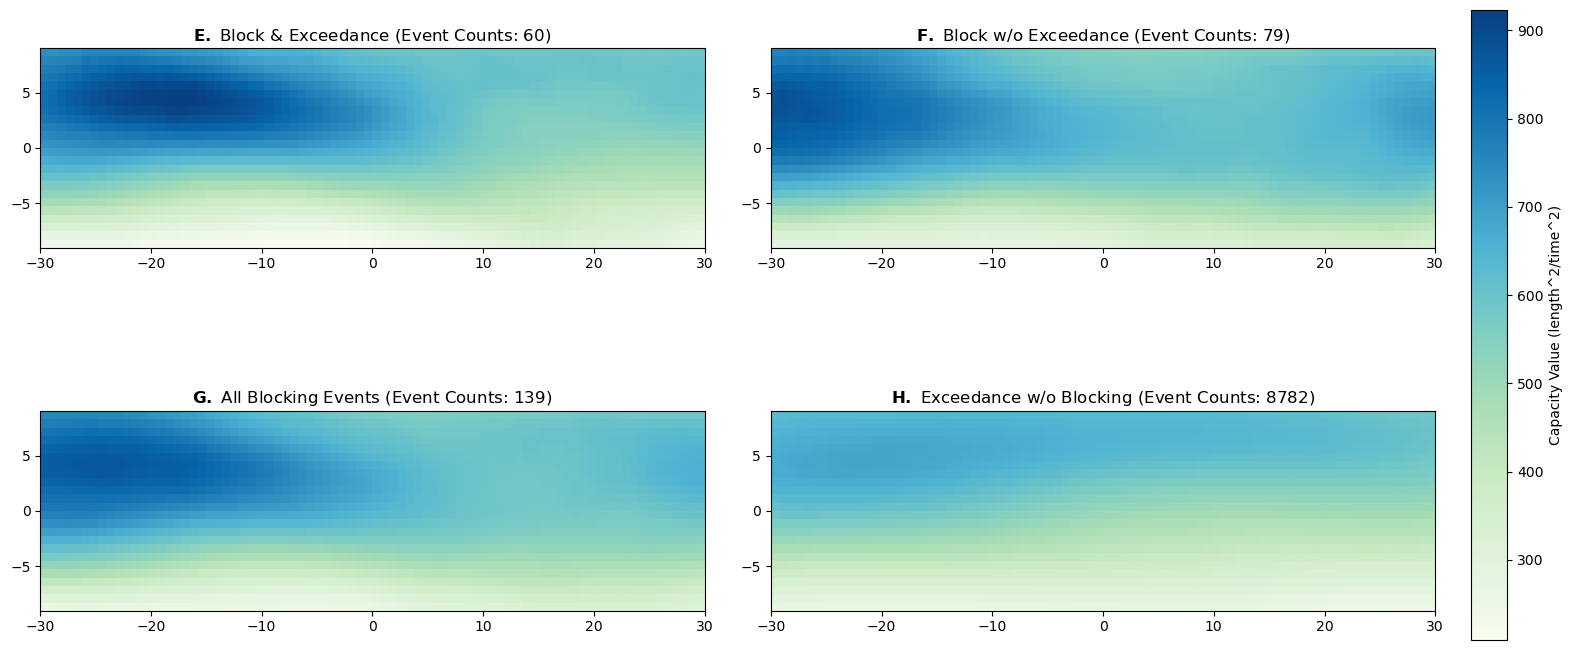

In [22]:
## Fig 4

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Extracting the block from flux capacity data
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    
    return event_type, extracted_block, (year, month, day, hour), (lat, lon)

# Read the results CSV
# results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis/results.csv')
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

global_min = min(composite_heatmap_match.min(), composite_heatmap_non_match.min(), 
                 composite_heatmap_both.min(), composite_heatmap_exceedance.min())
global_max = max(composite_heatmap_match.max(), composite_heatmap_non_match.max(), 
                 composite_heatmap_both.max(), composite_heatmap_exceedance.max())

# Function to plot a heatmap with relative coordinates and global color range
def plot_composite_heatmap(ax, data, title, event_count, vmin, vmax):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels and a global color range.
    """
    im = ax.imshow(data, cmap='GnBu', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} (Event Counts: {event_count})")
    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and store the return value of imshow from one of them
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, r"$\mathbf{E.}$ Block & Exceedance", count_match, global_min, global_max)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, r"$\mathbf{F.}$ Block w/o Exceedance", count_non_match, global_min, global_max)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, r"$\mathbf{G.}$ All Blocking Events", count_both, global_min, global_max)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, r"$\mathbf{H.}$ Exceedance w/o Blocking", count_exceedance, global_min, global_max)

# Add a colorbar on the right side of the grid using the imshow object 'im'
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Capacity Value (length^2/time^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

100%|██████████| 8921/8921 [00:20<00:00, 429.82it/s]


209.13248863855657 922.9809035868313


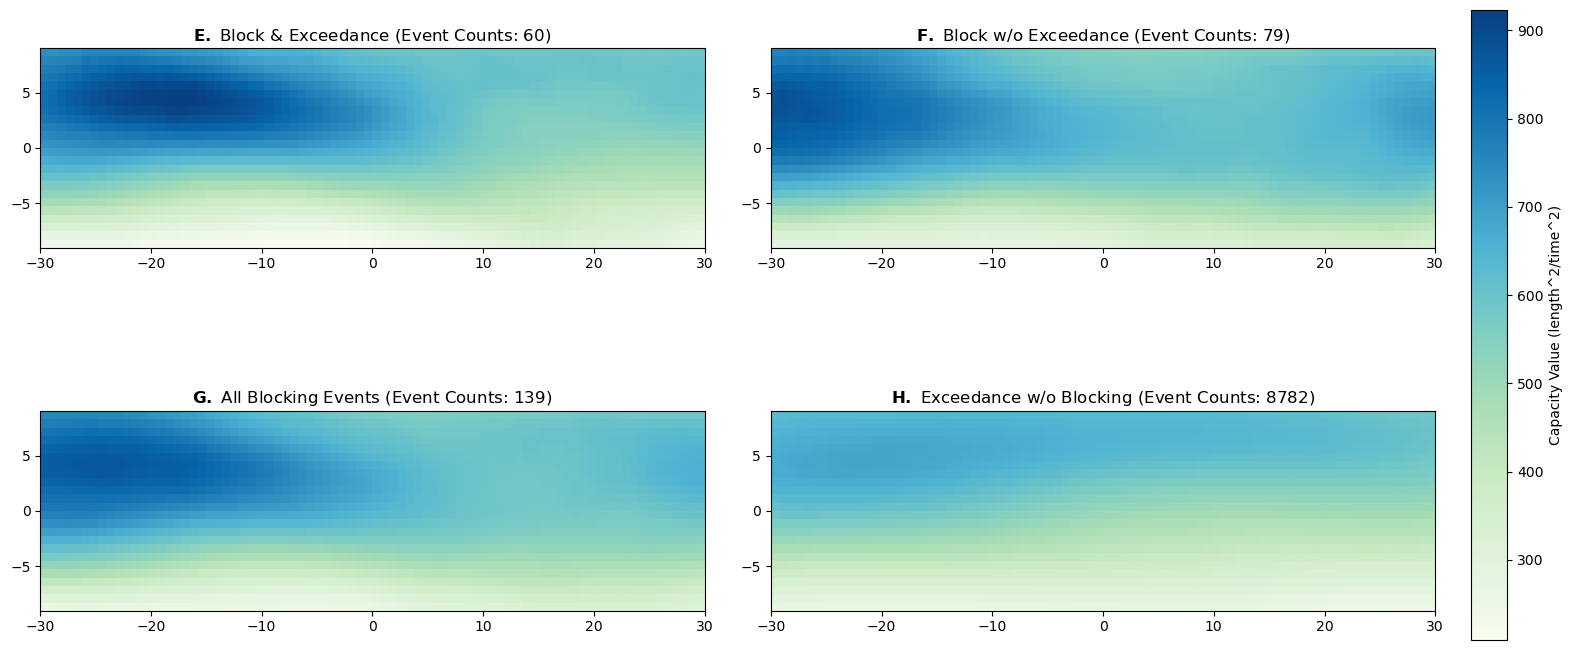

In [2]:
## Fig 4

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Extracting the block from flux capacity data
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    
    return event_type, extracted_block, (year, month, day, hour), (lat, lon)

# Read the results CSV
# results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis/results.csv')
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

global_min = min(composite_heatmap_match.min(), composite_heatmap_non_match.min(), 
                 composite_heatmap_both.min(), composite_heatmap_exceedance.min())
global_max = max(composite_heatmap_match.max(), composite_heatmap_non_match.max(), 
                 composite_heatmap_both.max(), composite_heatmap_exceedance.max())
print(global_min, global_max)

# Function to plot a heatmap with relative coordinates and global color range
def plot_composite_heatmap(ax, data, title, event_count, vmin, vmax):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels and a global color range.
    """
    im = ax.imshow(data, cmap='GnBu', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} (Event Counts: {event_count})")
    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and store the return value of imshow from one of them
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, r"$\mathbf{E.}$ Block & Exceedance", count_match, global_min, global_max)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, r"$\mathbf{F.}$ Block w/o Exceedance", count_non_match, global_min, global_max)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, r"$\mathbf{G.}$ All Blocking Events", count_both, global_min, global_max)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, r"$\mathbf{H.}$ Exceedance w/o Blocking", count_exceedance, global_min, global_max)

# Add a colorbar on the right side of the grid using the imshow object 'im'
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Capacity Value (length^2/time^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

100%|██████████| 19226/19226 [02:17<00:00, 140.10it/s]


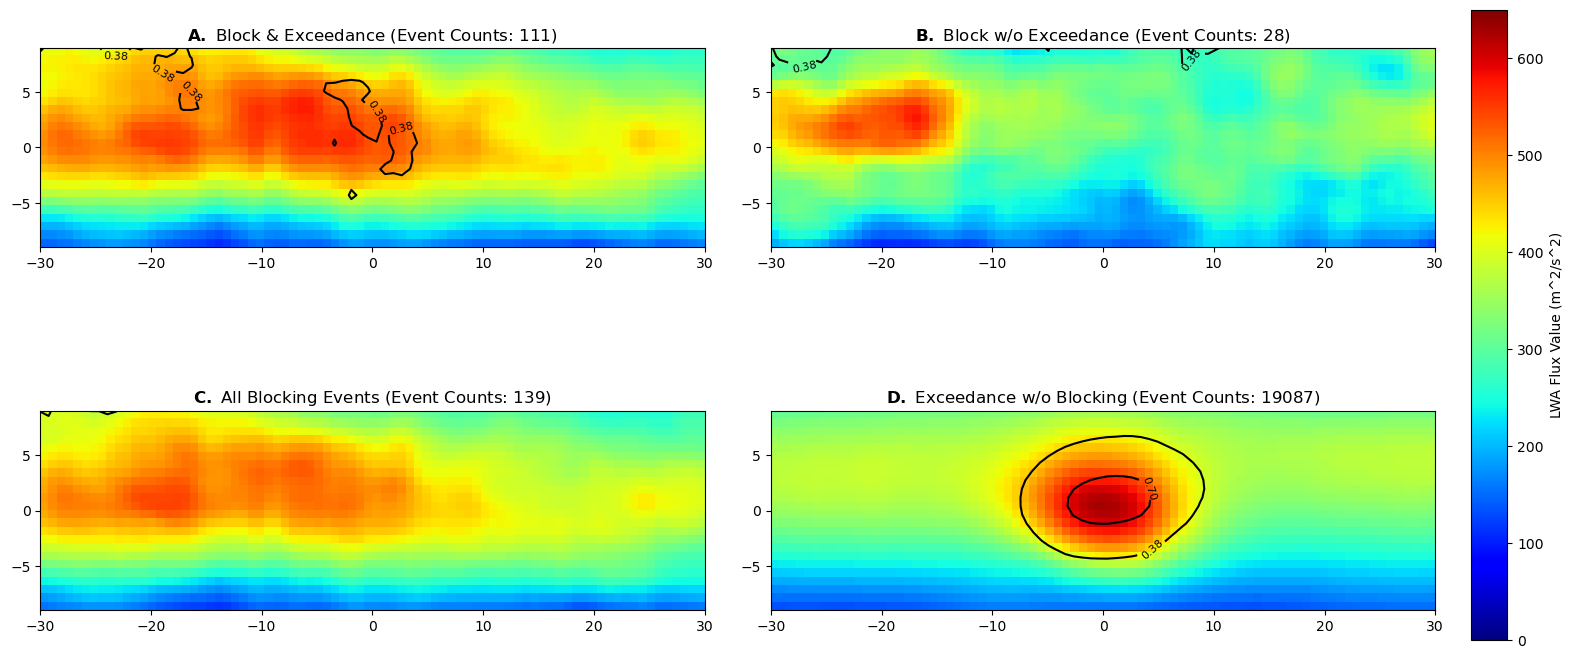

In [26]:
### FIG3

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)

    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0111/filtered_results.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, Heaviside_data, title, event_count):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels,
    and add Heaviside function contours with labels.
    """
    im = ax.imshow(data, cmap='jet', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=0, vmax=650)
    ax.set_title(f"{title} (Event Counts: {event_count})")

    # Draw contour lines
    contours = ax.contour(Heaviside_data, levels=[0.38, 0.7], colors='black', extent=[-30, 30, -9, 9])
    
    # Label contours
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.2f')

    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, composite_Heaviside_match, r"$\mathbf{A.}$ Block & Exceedance", count_match)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, composite_Heaviside_non_match, r"$\mathbf{B.}$ Block w/o Exceedance", count_non_match)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, composite_Heaviside_both, r"$\mathbf{C.}$ All Blocking Events", count_both)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, composite_Heaviside_exceedance, r"$\mathbf{D.}$ Exceedance w/o Blocking", count_exceedance)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax).set_label('LWA Flux Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()



100%|██████████| 19226/19226 [00:38<00:00, 500.40it/s]


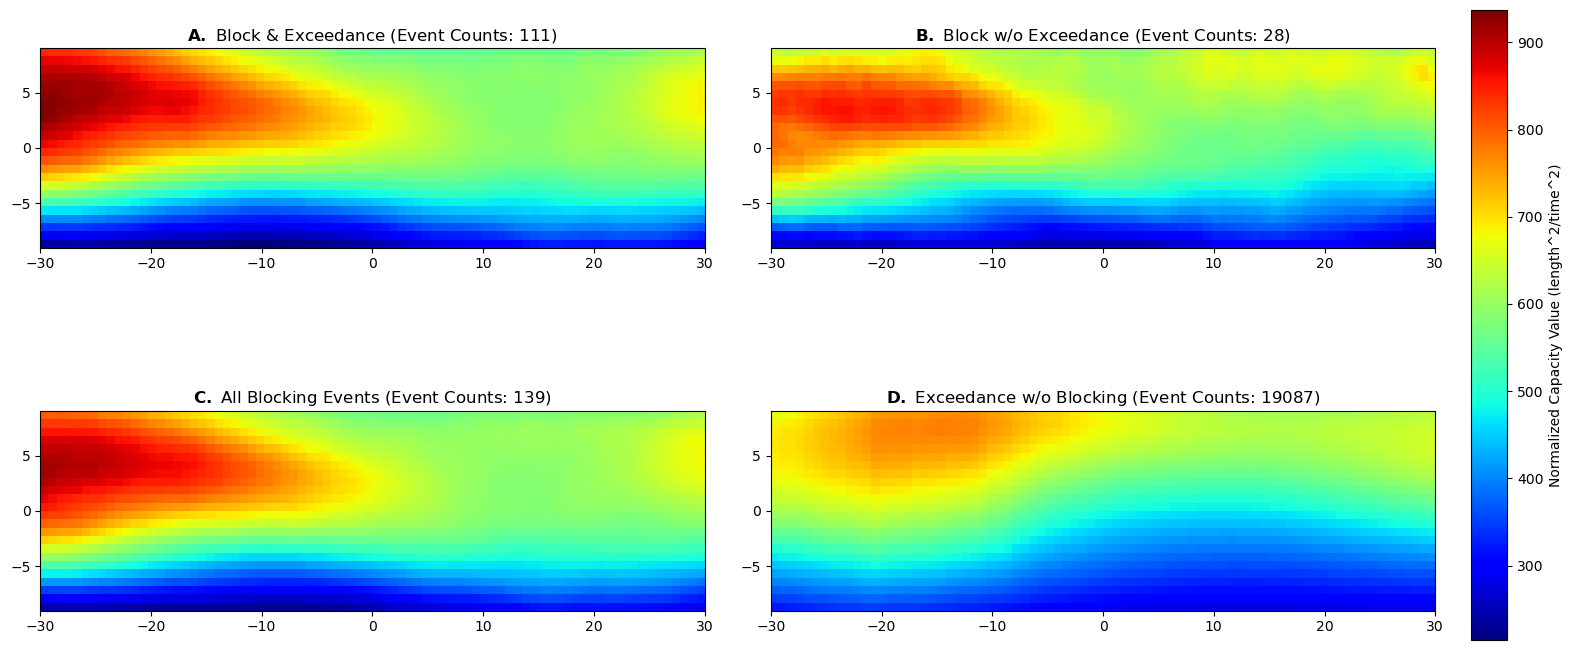

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Extracting the block from flux capacity data
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]

    return event_type, extracted_block, (year, month, day, hour), (lat, lon)

# Read the results CSV
# results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis/results.csv')
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0111/filtered_results.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

global_min = min(composite_heatmap_match.min(), composite_heatmap_non_match.min(), 
                 composite_heatmap_both.min(), composite_heatmap_exceedance.min())
global_max = max(composite_heatmap_match.max(), composite_heatmap_non_match.max(), 
                 composite_heatmap_both.max(), composite_heatmap_exceedance.max())

# Function to plot a heatmap with relative coordinates and global color range
def plot_composite_heatmap(ax, data, title, event_count, vmin, vmax):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels and a global color range.
    """
    im = ax.imshow(data, cmap='jet', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} (Event Counts: {event_count})")
    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and store the return value of imshow from one of them
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, r"$\mathbf{A.}$ Block & Exceedance", count_match, global_min, global_max)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, r"$\mathbf{B.}$ Block w/o Exceedance", count_non_match, global_min, global_max)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, r"$\mathbf{C.}$ All Blocking Events", count_both, global_min, global_max)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, r"$\mathbf{D.}$ Exceedance w/o Blocking", count_exceedance, global_min, global_max)

# Add a colorbar on the right side of the grid using the imshow object 'im'
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Capacity Value (length^2/time^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

100%|██████████| 41065/41065 [01:23<00:00, 493.75it/s]


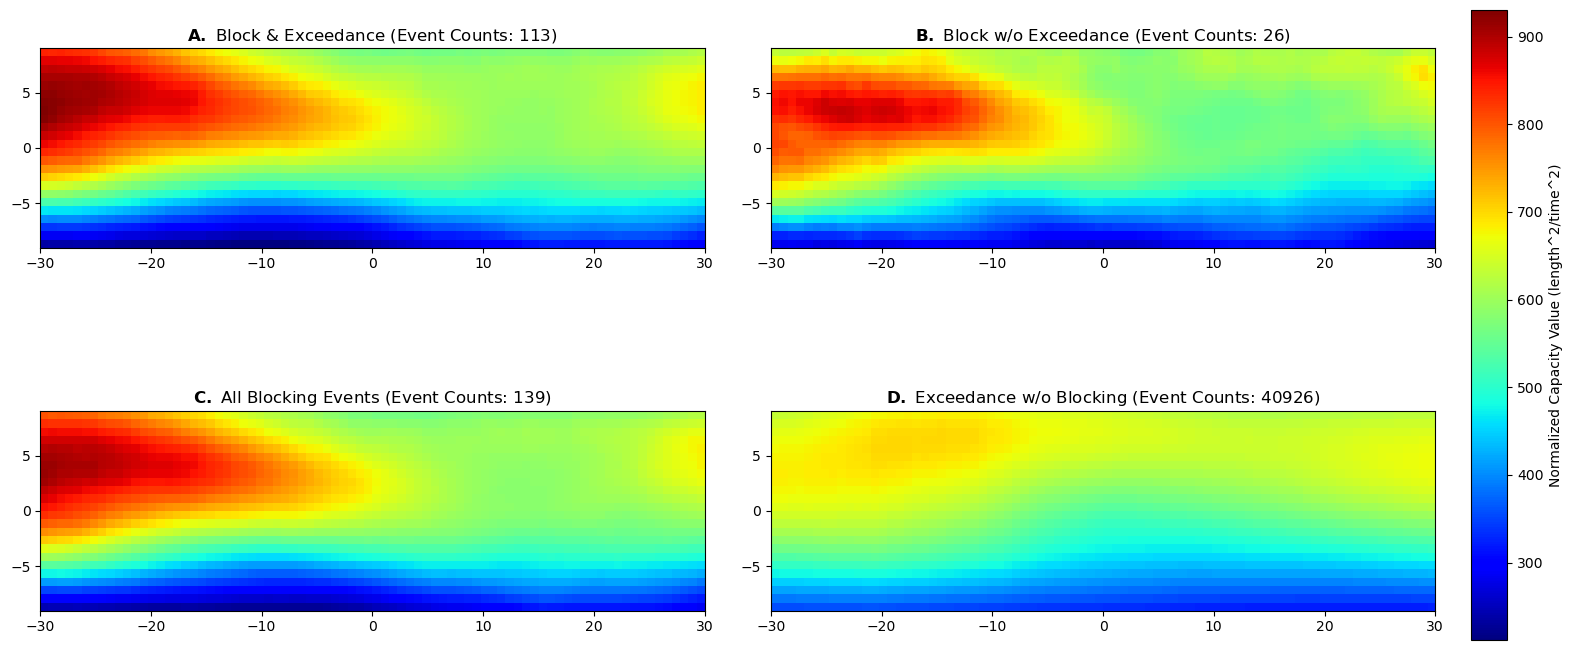

In [18]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Extracting the block from flux capacity data
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]

    return event_type, extracted_block, (year, month, day, hour), (lat, lon)

# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0111/results.csv')
# results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis/filtered_results.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

global_min = min(composite_heatmap_match.min(), composite_heatmap_non_match.min(), 
                 composite_heatmap_both.min(), composite_heatmap_exceedance.min())
global_max = max(composite_heatmap_match.max(), composite_heatmap_non_match.max(), 
                 composite_heatmap_both.max(), composite_heatmap_exceedance.max())

# Function to plot a heatmap with relative coordinates and global color range
def plot_composite_heatmap(ax, data, title, event_count, vmin, vmax):
    """
    Plot a heatmap for the composite data with relative latitude and longitude labels and a global color range.
    """
    im = ax.imshow(data, cmap='jet', interpolation='nearest', extent=[-30, 30, -9, 9], vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} (Event Counts: {event_count})")
    return im

# Setup the 2x2 grid layout
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2)

# Plot each subplot with a bold title and store the return value of imshow from one of them
ax1 = fig.add_subplot(gs[0, 0])
im = plot_composite_heatmap(ax1, composite_heatmap_match, r"$\mathbf{A.}$ Block & Exceedance", count_match, global_min, global_max)

ax2 = fig.add_subplot(gs[0, 1])
plot_composite_heatmap(ax2, composite_heatmap_non_match, r"$\mathbf{B.}$ Block w/o Exceedance", count_non_match, global_min, global_max)

ax3 = fig.add_subplot(gs[1, 0])
plot_composite_heatmap(ax3, composite_heatmap_both, r"$\mathbf{C.}$ All Blocking Events", count_both, global_min, global_max)

ax4 = fig.add_subplot(gs[1, 1])
plot_composite_heatmap(ax4, composite_heatmap_exceedance, r"$\mathbf{D.}$ Exceedance w/o Blocking", count_exceedance, global_min, global_max)

# Add a colorbar on the right side of the grid using the imshow object 'im'
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Normalized Capacity Value (length^2/time^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()